# A Simple Parameter Inference with Transformers
# Task
Consider the simple periodic function:
$y_i(A_i,w_i;t)=A_i*sin(w_it)$
where A represents the amplitude,  the frequency, and t is the time variable.

Restrict the time variable to the interval $t[0,2*\pi/w]$.

To create the dataset, produce N discrete representations of $y_i$, i.e., N-number of 1D vectors, called $V_i(A_i,w_i)$, by creating a grid of reasonable combinations of A and . Assume that it is sampled with 100 points, meaning each 1D vector consists of 100 points. Initially, N can be on the order of $10^3$ and then progressively increase to test the model’s accuracy against this choice.

Inference:
Using the dataset, start with an encoder-only transformer model (e.g., a Bert-like model) and train it to predict $(A, w)$ from a given $V_i$. In this case, the vector $V_i$ is the input, and the output (or “labels”) will be the pairs $(A_i,w_i)$, i.e., $V_i \rightarrow (A_i,w_i)$.

Questions to consider:
- How does the model perform?
- How does the performance/accuracy vary by changing the dataset size N, or by adjusting the transformer model’s hyperparameters?
- What if a different transformer architecture is used, such as a decoder-only or encoder-decoder model?
- If the training set is restricted to a single parameter (e.g., fixing the amplitude A = 1 and varying only , does this improve inference accuracy?

# Data Generation and Simple Encoder example

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 22.0 MB/s eta 0:00:00


In [ ]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import optuna
import plotly
import seaborn as sns
from torchmetrics import R2Score
from sklearn.model_selection import KFold
import time
from tabulate import tabulate

In [ ]:
def generate_sine_data(A_range, omega_range, t_points, N):
    """
    Function to generate N sine waves based on random combinations of amplitude and frequency.

    Parameters:
    - A_range: tuple, (min, max) for the amplitude A
    - omega_range: tuple, (min, max) for the frequency omega
    - t_points: int, number of time points for the sine waves
    - N: int, number of sine waves to generate

    Returns:
    - sine_waves: Tensor of shape (N, t_points) representing the sine waves
    - labels: Tensor of shape (N, 2) representing the amplitude and frequency for each sine wave
    """
    # Generate time points (t) for plotting
    t = torch.linspace(0, 2 * torch.pi, t_points)

    # Generate random amplitudes and frequencies
    A_values = torch.empty(N).uniform_(*A_range)  # Amplitude values in range [A_min, A_max]
    omega_values = torch.empty(N).uniform_(*omega_range)  # Frequency values in range [omega_min, omega_max]

    # Create sine waves (V_i), each corresponding to a combination of A and omega
    sine_waves = A_values.unsqueeze(1) * torch.sin(omega_values.unsqueeze(1) * t)  # Efficient broadcasting

    # Labels: pairs (A_i, omega_i)
    labels = torch.stack([A_values, omega_values], dim=1)

    return sine_waves, labels

In [ ]:
# Example usage
A_range = (0.1, 10)  # Range for amplitude A
omega_range = (0.1, 10)  # Range for frequency omega
t_points = 100  # Number of discretization points
N = 1000  # Initial dataset size

sine_waves, labels = generate_sine_data(A_range, omega_range, t_points, N)

# Check the result
print(f"Shape of sine waves: {sine_waves.shape}, Shape of labels: {labels.shape}")

Shape of sine waves: torch.Size([1000, 100]), Shape of labels: torch.Size([1000, 2])


In [ ]:
def visualize_sine_waves(sine_waves, labels, selected_indices, t_points=100):
    """
    Function to visualize sine waves from the dataset based on provided indices.

    Parameters:
    - sine_waves: Tensor, 2D tensor with the generated sine waves
    - labels: Tensor, corresponding labels (amplitude and frequency) for each sine wave
    - selected_indices: list or tensor, indices of the sine waves to plot
    - t_points: int, number of time points (default is 100)
    """

    # Generate the time values (t) for plotting inside the function
    t = torch.linspace(0, 2 * torch.pi, t_points)

    # Number of waves to visualize
    num_waves = len(selected_indices)

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(num_waves, 1, figsize=(10, 12))

    for i, ax in enumerate(axes):
        index = selected_indices[i]
        ax.plot(t.numpy(), sine_waves[index].numpy(), label=f"A = {labels[index, 0]:.2f}, ω = {labels[index, 1]:.2f}")
        ax.legend(loc="upper right")
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)

    # Layout adjustments and display the plot
    plt.tight_layout()
    plt.show()

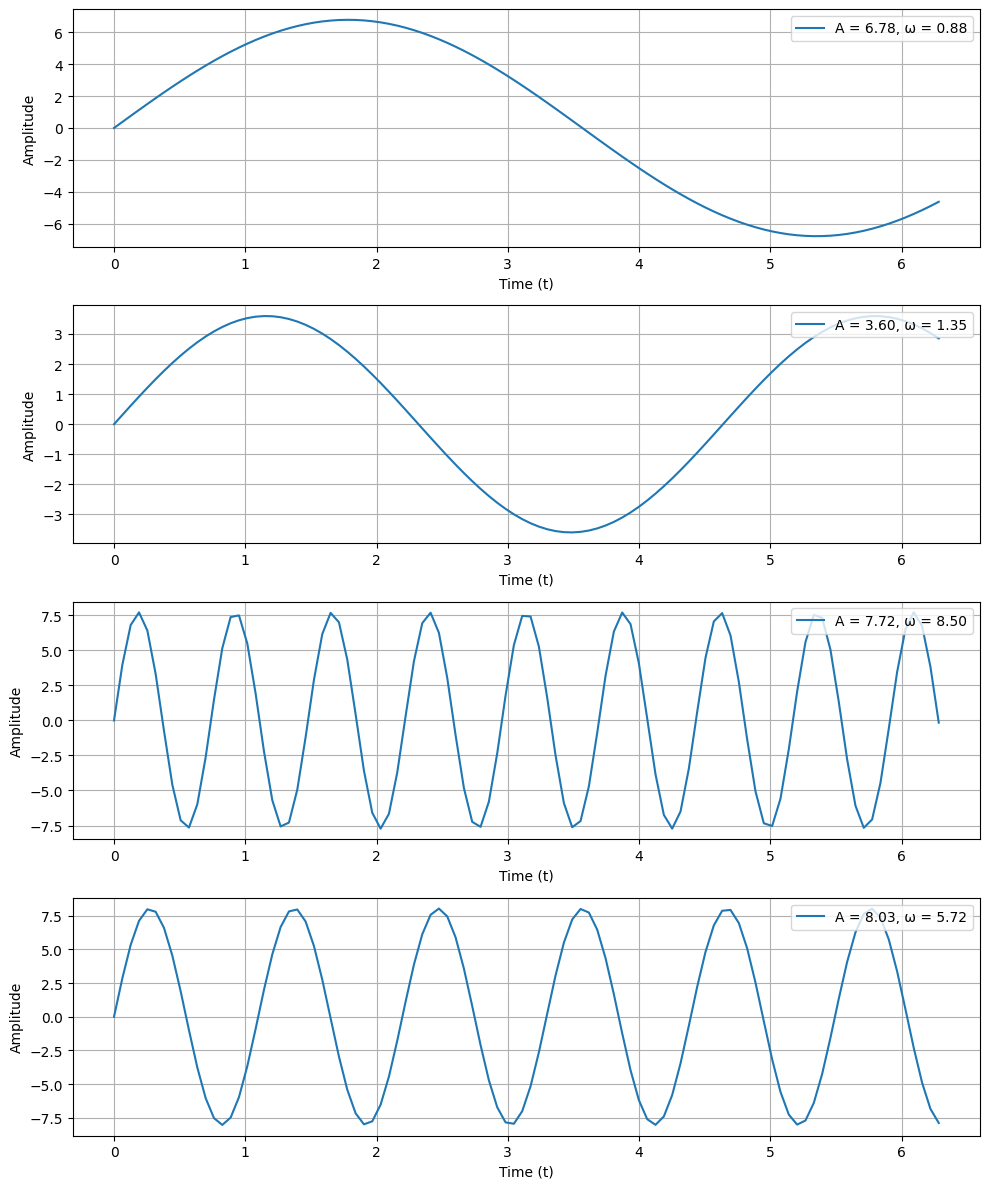

In [ ]:

# Select specific sine waves to visualize (e.g., waves with indices 0, 5, 6, 60)
selected_indices = [0, 5, 6, 60]

# Call the function to visualize the selected sine waves
visualize_sine_waves(sine_waves, labels, selected_indices)

In [ ]:
def prepare_data(sine_waves, labels, test_size=0.2, batch_size=32):
    """
    Split and prepare data for training.

    Parameters:
    - sine_waves: Tensor of shape (N, t_points)
    - labels: Tensor of shape (N, 2)
    - test_size: float, proportion of data for testing
    - batch_size: int, batch size for DataLoader

    Returns:
    - train_loader, val_loader: DataLoader objects
    - scalers: tuple of (input_scaler, label_scaler)
    """

    # Convert to numpy for sklearn preprocessing
    X = sine_waves.numpy()
    y = labels.numpy()

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

    # Scale the input data (sine waves)
    input_scaler = MinMaxScaler()  # Use MinMaxScaler instead of StandardScaler
    X_train_scaled = input_scaler.fit_transform(X_train)
    X_val_scaled = input_scaler.transform(X_val)

    # Scale the labels (A, omega)
    label_scaler = MinMaxScaler()  # Use MinMaxScaler for labels as well
    y_train_scaled = label_scaler.fit_transform(y_train)
    y_val_scaled = label_scaler.transform(y_val)

    # Convert back to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train_scaled)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val_scaled)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, (input_scaler, label_scaler)

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

class SineWaveTransformer(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2, dim_feedforward=512, dropout=0.1):
        super().__init__()

        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))

        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)  # Output for A and w

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        x = self.embedding(x)
        x = x + self.pos_encoding

        x = x.transpose(0, 1)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x


In [ ]:
import time

def train_model(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        epoch_time = time.time() - start_time
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')

    return train_losses, val_losses

def evaluate_model(model, val_loader, label_scaler, device='cuda'):
    """
    Evaluate model performance and visualize predictions.
    """
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            all_preds.append(outputs.cpu().numpy())
            all_true.append(batch_y.cpu().numpy())

    # Combine predictions and true values
    predictions = np.vstack(all_preds)
    true_values = np.vstack(all_true)

    # Inverse transform the scaled values
    predictions = label_scaler.inverse_transform(predictions)
    true_values = label_scaler.inverse_transform(true_values)

    # Calculate metrics
    mse = np.mean((predictions - true_values) ** 2, axis=0)
    mae = np.mean(np.abs(predictions - true_values), axis=0)

    print(f"MSE - Amplitude: {mse[0]:.4f}, Frequency: {mse[1]:.4f}")
    print(f"MAE - Amplitude: {mae[0]:.4f}, Frequency: {mae[1]:.4f}")
    print("\n")


    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.scatter(true_values[:, 0], predictions[:, 0], alpha=0.5)
    ax1.plot([true_values[:, 0].min(), true_values[:, 0].max()],
             [true_values[:, 0].min(), true_values[:, 0].max()], 'r--')
    ax1.set_xlabel('True Amplitude')
    ax1.set_ylabel('Predicted Amplitude')
    ax1.set_title('Amplitude Predictions')

    ax2.scatter(true_values[:, 1], predictions[:, 1], alpha=0.5)
    ax2.plot([true_values[:, 1].min(), true_values[:, 1].max()],
             [true_values[:, 1].min(), true_values[:, 1].max()], 'r--')
    ax2.set_xlabel('True Frequency')
    ax2.set_ylabel('Predicted Frequency')
    ax2.set_title('Frequency Predictions')

    plt.tight_layout()
    plt.show()

    return mse, mae

Epoch [10/100], Train Loss: 0.0072, Val Loss: 0.0103, Time: 0.25s
Epoch [20/100], Train Loss: 0.0034, Val Loss: 0.0042, Time: 0.30s
Epoch [30/100], Train Loss: 0.0025, Val Loss: 0.0016, Time: 0.29s
Epoch [40/100], Train Loss: 0.0020, Val Loss: 0.0012, Time: 0.41s
Epoch [50/100], Train Loss: 0.0022, Val Loss: 0.0013, Time: 0.15s
Epoch [60/100], Train Loss: 0.0015, Val Loss: 0.0022, Time: 0.22s
Epoch [70/100], Train Loss: 0.0017, Val Loss: 0.0009, Time: 0.17s
Epoch [80/100], Train Loss: 0.0016, Val Loss: 0.0009, Time: 0.16s
Epoch [90/100], Train Loss: 0.0013, Val Loss: 0.0010, Time: 0.16s
Epoch [100/100], Train Loss: 0.0017, Val Loss: 0.0011, Time: 0.16s
MSE - Amplitude: 0.0402, Frequency: 0.1970
MAE - Amplitude: 0.1167, Frequency: 0.2357




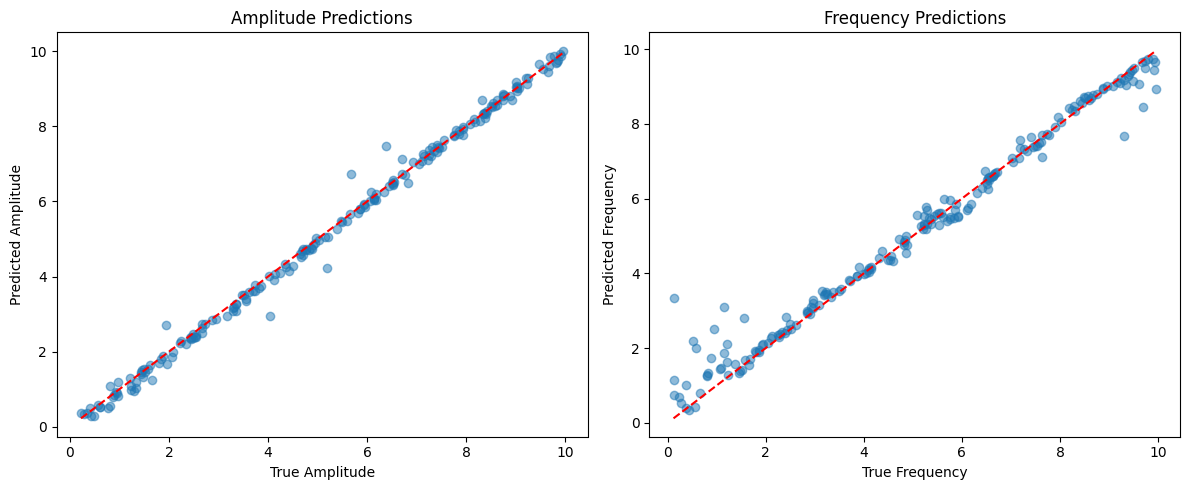

In [ ]:
# Usage example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate data
sine_waves, labels = generate_sine_data(A_range=(0.1, 10), omega_range=(0.1, 10), t_points=100, N=1000)

# Prepare data
train_loader, val_loader, scalers = prepare_data(sine_waves, labels)

# Initialize model
model = SineWaveTransformer(seq_len=t_points)

# Optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, optimizer=optimizer_adam, device=device)

# Evaluate model
mse, mae = evaluate_model(model, val_loader, scalers[1], device=device)

## What if N = 5000 or 10000?

Training with N = 1000...
Epoch [10/100], Train Loss: 0.0065, Val Loss: 0.0081, Time: 0.17s
Epoch [20/100], Train Loss: 0.0039, Val Loss: 0.0061, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 0.2852, Frequency: 0.8973
MAE - Amplitude: 0.4379, Frequency: 0.6207


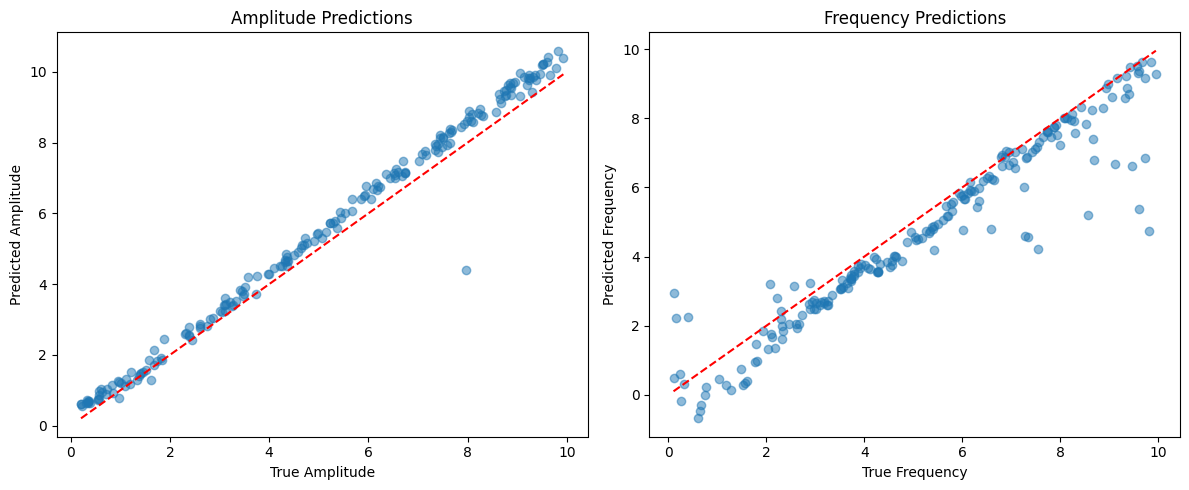

Training with N = 5000...
Early stopping triggered
MSE - Amplitude: 0.0749, Frequency: 0.2405
MAE - Amplitude: 0.2095, Frequency: 0.2990


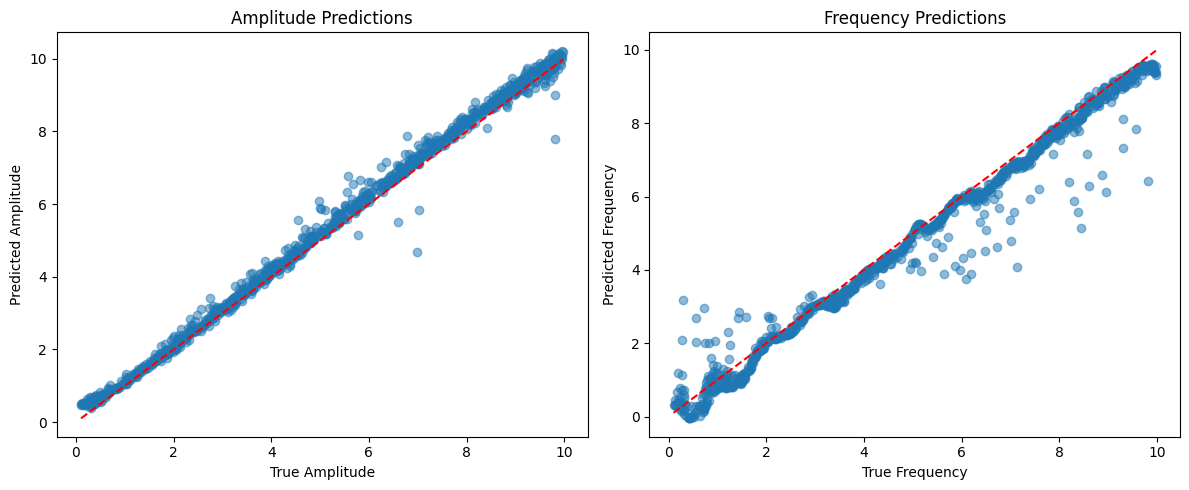

Training with N = 10000...
Early stopping triggered
MSE - Amplitude: 0.0644, Frequency: 0.2236
MAE - Amplitude: 0.2006, Frequency: 0.3305


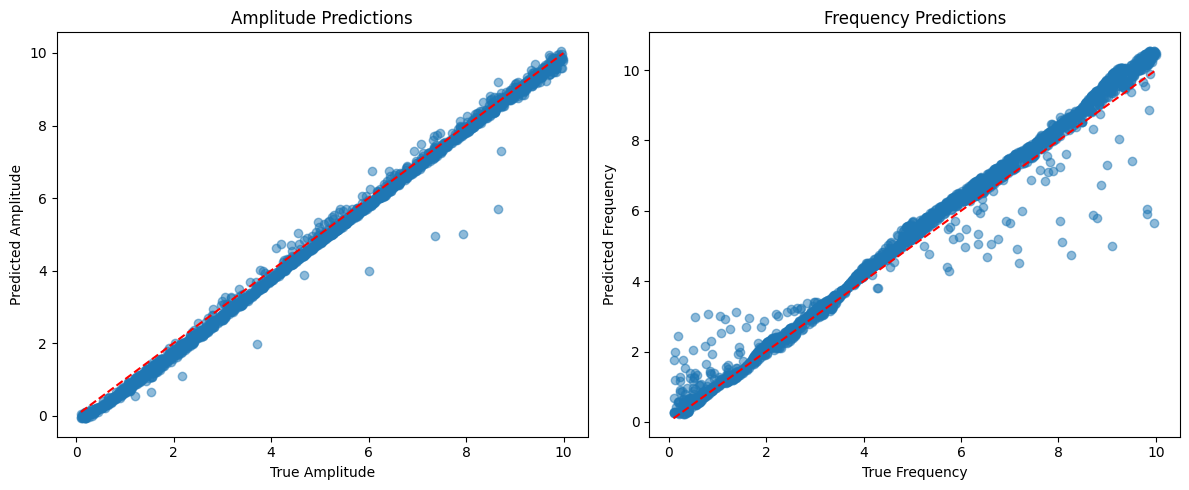

       N  MSE - Amplitude  MSE - Frequency  MAE - Amplitude  MAE - Frequency
0   1000         0.285183         0.897267         0.437861         0.620652
1   5000         0.074917         0.240480         0.209462         0.299023
2  10000         0.064354         0.223621         0.200572         0.330547


In [ ]:
# Define the different values for N
N_values = [1000, 5000, 10000]

# Step 1: Generate data
A_range = (0.1, 10)  # Example amplitude range
omega_range = (0.1, 10)  # Example frequency range
t_points = 100

# Store results
results = []

# Loop over different values of N
for N in N_values:
    print(f"Training with N = {N}...")

    # Step 1: Generate data
    sine_waves, labels = generate_sine_data(A_range, omega_range, t_points, N)

    # Step 2: Prepare data
    train_loader, val_loader, scalers = prepare_data(sine_waves, labels)

    # Step 3: Initialize model
    model = SineWaveTransformer(seq_len=t_points)

    # Step 4: Initialize optimizer
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Step 5: Train model
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, optimizer=optimizer_adam, device=device)

    # Step 6: Evaluate model
    mse, mae = evaluate_model(model, val_loader, scalers[1], device=device)

    # Store results in the list
    results.append({
        'N': N,
        'MSE - Amplitude': mse[0],
        'MSE - Frequency': mse[1],
        'MAE - Amplitude': mae[0],
        'MAE - Frequency': mae[1]
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df)

In [ ]:
results_df

N  MSE - Amplitude  MSE - Frequency  MAE - Amplitude  MAE - Frequency
0   1000         0.169506         0.424508         0.210607         0.396127
1   5000         0.085746         0.072368         0.214267         0.187124
2  10000         0.068625         0.244228         0.209638         0.372586

### Wider range for A and w?

Epoch [10/100], Train Loss: 0.0232, Val Loss: 0.0128, Time: 0.18s
Early stopping triggered
MSE - Amplitude: 47.4194, Frequency: 210.7099
MAE - Amplitude: 5.5867, Frequency: 10.2315


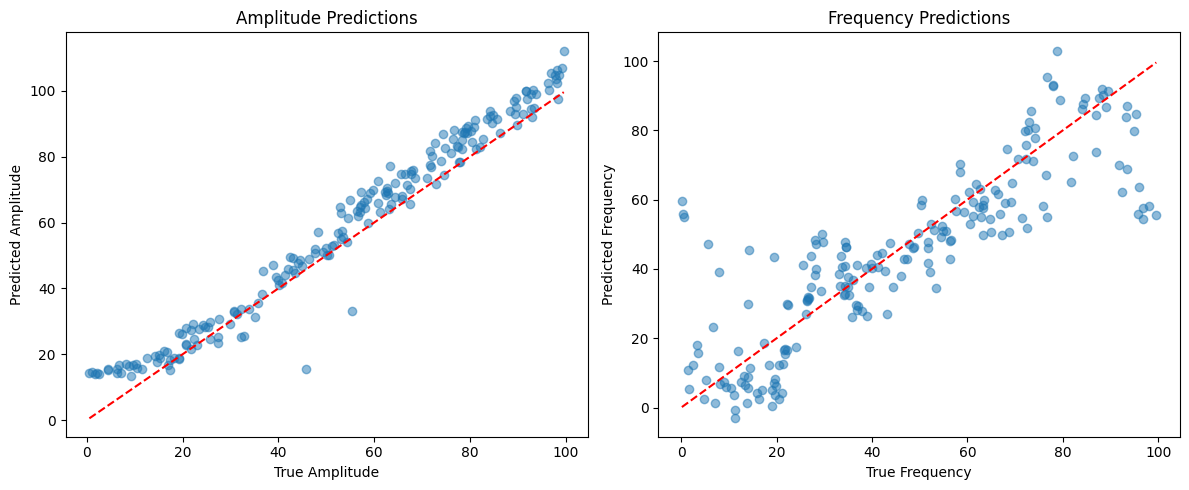

In [ ]:
sine_waves, labels = generate_sine_data((0.01, 100), (0.01, 100), t_points= 100, N = 1000)

# Usage example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
train_loader, val_loader, scalers = prepare_data(sine_waves, labels)

# Initialize model
model = SineWaveTransformer(seq_len=t_points)

# Optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, optimizer=optimizer_adam, device=device)

# Evaluate model
mse, mae = evaluate_model(model, val_loader, scalers[1], device=device)

# Hyperparameter Optimization

## Hyperparameter Optimization N=1000, first iteration

In [ ]:
def objective(trial):
    """
    Objective function for Optuna - defines search space and evaluates model
    Tracks both best and worst performing hyperparameter configurations
    """
    # Define hyperparameter search space
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    d_model = trial.suggest_categorical('d_model', [32, 64, 128, 256])
    nhead = trial.suggest_categorical('nhead', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 2, 4, step=1)
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [128, 256, 512])
    dropout = trial.suggest_categorical('dropout', [0.2, 0.3, 0.4])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)

    # Generate data
    sine_waves, labels = generate_sine_data(
        A_range=(0.1, 10),
        omega_range=(0.1, 10),
        t_points=100,
        N=1000
    )

    # Prepare data
    train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(
        sine_waves, labels,
        test_size=0.2,
        batch_size=batch_size
    )

    # Initialize model
    model = SineWaveTransformer(
        seq_len=100,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        epochs=100,
        optimizer=optimizer
    )

    # Evaluate model
    mse, mae = evaluate_model(model, val_loader, label_scaler)

    # Set user attributes for detailed tracking
    trial.set_user_attr('amplitude_mse', mse[0])
    trial.set_user_attr('frequency_mse', mse[1])

    return mse[0], mse[1]

def optimize_hyperparameters(n_trials=50):
    """
    Function to run hyperparameter optimization with Optuna
    Tracks and prints both best and worst trials
    """
    study = optuna.create_study(directions=["minimize", "minimize"])

    def callback(study, trial):
        if len(study.trials) == n_trials:
            # Track and print worst trials
            print("\n--- Worst Performing Trials ---")
            # Sort trials by total MSE (sum of amplitude and frequency MSE)
            worst_trials = sorted(study.trials, key=lambda t: sum(t.values) if t.values else float('inf'), reverse=True)

            for i, worst_trial in enumerate(worst_trials[:5], 1):
                print(f"\nWorst Trial {i}:")
                print(f" Amplitude MSE: {worst_trial.values[0] if worst_trial.values else 'N/A':.6f}")
                print(f" Frequency MSE: {worst_trial.values[1] if worst_trial.values else 'N/A':.6f}")
                print(" Params:")
                for key, value in worst_trial.params.items():
                    print(f"  {key}: {value}")

    # Run optimization
    study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    print("\n--- Optuna Hyperparameter Optimization Results ---")

    # Print best trials
    if study.best_trials:
        for i, best_trial in enumerate(study.best_trials[:5], 1):
            print(f"\nBest Trial {i}:")
            print(f" Amplitude MSE: {best_trial.values[0]:.6f}")
            print(f" Frequency MSE: {best_trial.values[1]:.6f}")
            print(" Params:")
            for key, value in best_trial.params.items():
                print(f"  {key}: {value}")
    else:
        print("No successful trials were completed.")

    return study.best_trials[0].params if study.best_trials else None

[I 2024-11-29 21:02:36,472] A new study created in memory with name: no-name-3c7c67c3-eb1b-4508-a3ac-fac57de34051


Epoch [10/100], Train Loss: 0.0106, Val Loss: 0.0121, Time: 0.17s
Epoch [20/100], Train Loss: 0.0077, Val Loss: 0.0093, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 0.4648, Frequency: 0.9247
MAE - Amplitude: 0.5800, Frequency: 0.8000


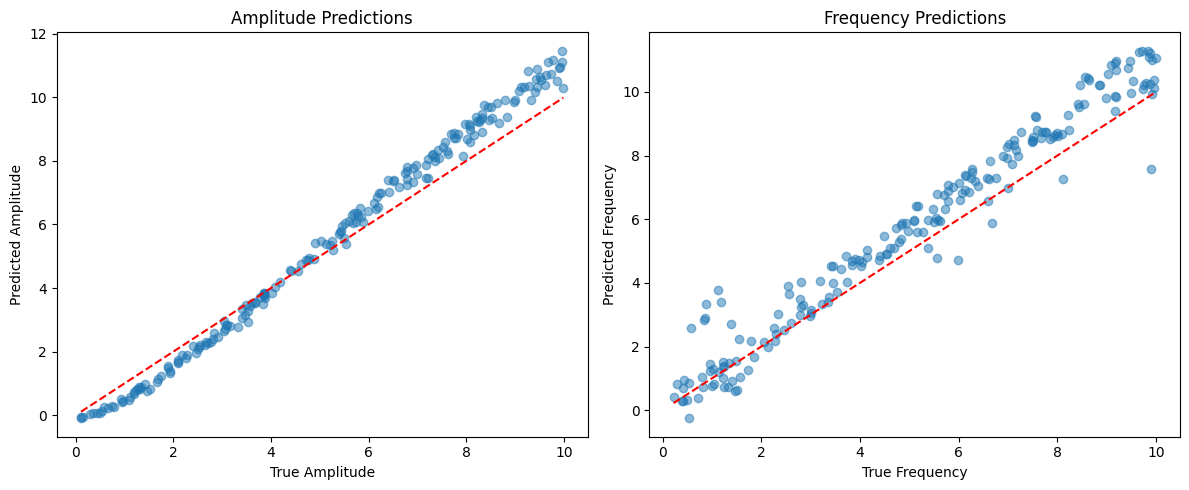

[I 2024-11-29 21:02:41,901] Trial 0 finished with values: [0.46475276350975037, 0.924679160118103] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.0006349204532487732}.


Epoch [10/100], Train Loss: 0.0114, Val Loss: 0.0157, Time: 0.29s
Early stopping triggered
MSE - Amplitude: 2.3245, Frequency: 1.2303
MAE - Amplitude: 1.2923, Frequency: 0.9180


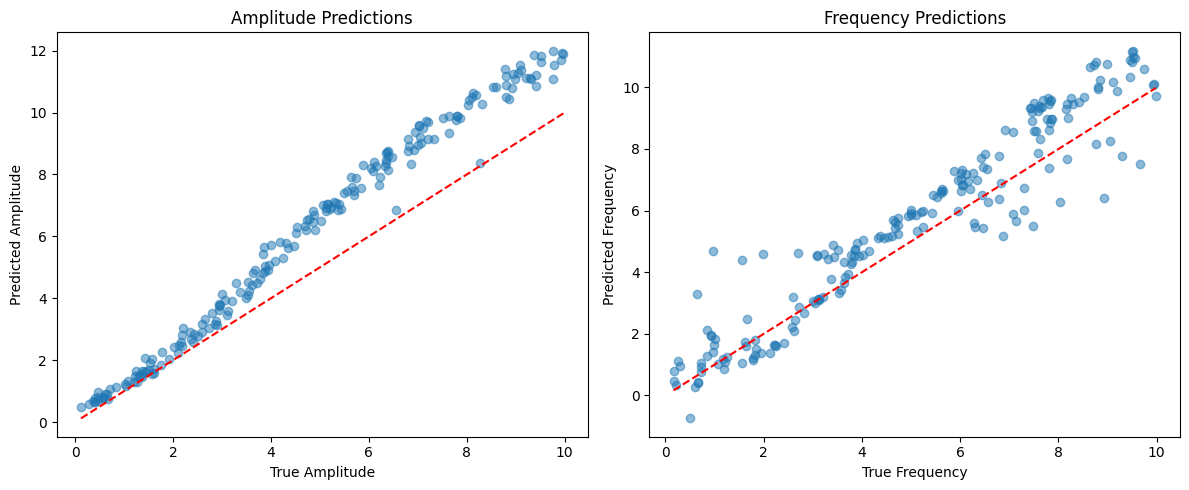

[I 2024-11-29 21:02:46,493] Trial 1 finished with values: [2.324510335922241, 1.2303004264831543] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.4, 'learning_rate': 0.0005955333365037545}.


Epoch [10/100], Train Loss: 0.0203, Val Loss: 0.0209, Time: 0.55s
Epoch [20/100], Train Loss: 0.0068, Val Loss: 0.0090, Time: 0.56s
Epoch [30/100], Train Loss: 0.0057, Val Loss: 0.0086, Time: 0.56s
Early stopping triggered
MSE - Amplitude: 0.8436, Frequency: 0.9142
MAE - Amplitude: 0.7419, Frequency: 0.6997


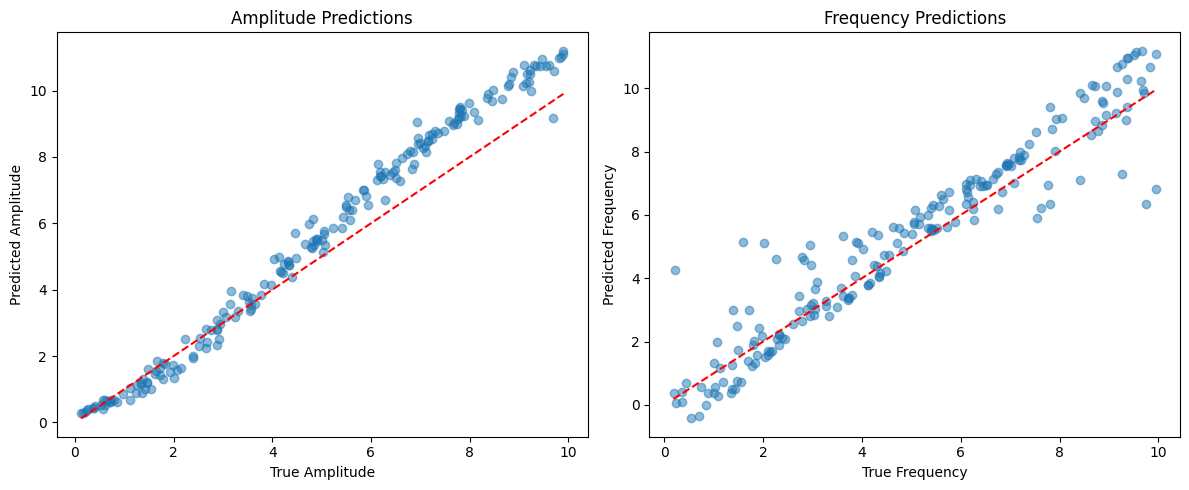

[I 2024-11-29 21:03:06,672] Trial 2 finished with values: [0.8436465263366699, 0.9142423868179321] and parameters: {'batch_size': 16, 'd_model': 32, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00040623657765615287}.


Epoch [10/100], Train Loss: 0.0083, Val Loss: 0.0067, Time: 0.71s
Epoch [20/100], Train Loss: 0.0044, Val Loss: 0.0043, Time: 0.56s
Early stopping triggered
MSE - Amplitude: 0.1497, Frequency: 0.7675
MAE - Amplitude: 0.3138, Frequency: 0.6858


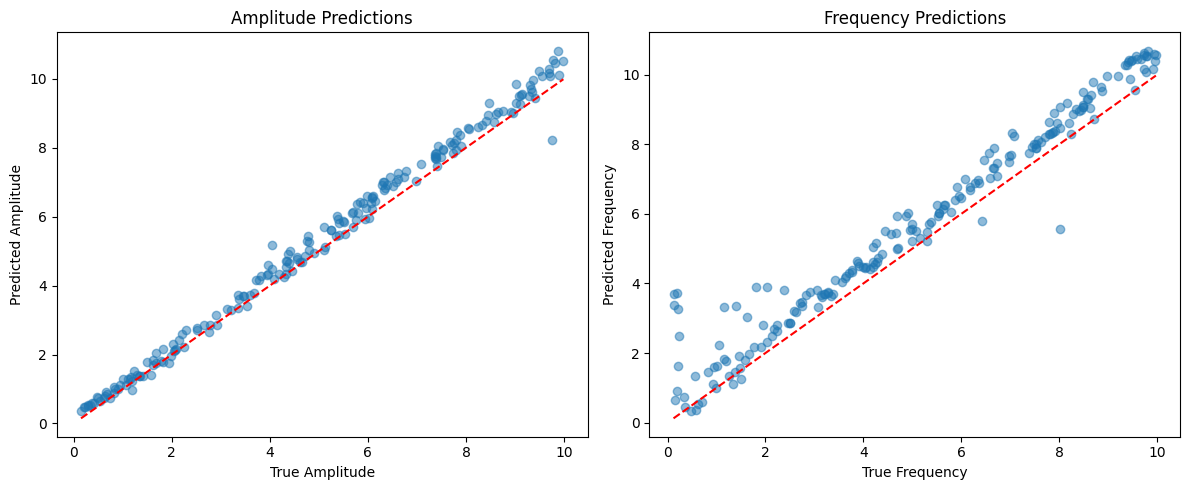

[I 2024-11-29 21:03:23,194] Trial 3 finished with values: [0.14965389668941498, 0.7674732208251953] and parameters: {'batch_size': 16, 'd_model': 64, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.0006645002736547817}.


Epoch [10/100], Train Loss: 0.0119, Val Loss: 0.0111, Time: 0.34s
Epoch [20/100], Train Loss: 0.0056, Val Loss: 0.0042, Time: 0.33s
Epoch [30/100], Train Loss: 0.0063, Val Loss: 0.0063, Time: 0.33s
Early stopping triggered
MSE - Amplitude: 0.6171, Frequency: 0.6747
MAE - Amplitude: 0.7460, Frequency: 0.5642


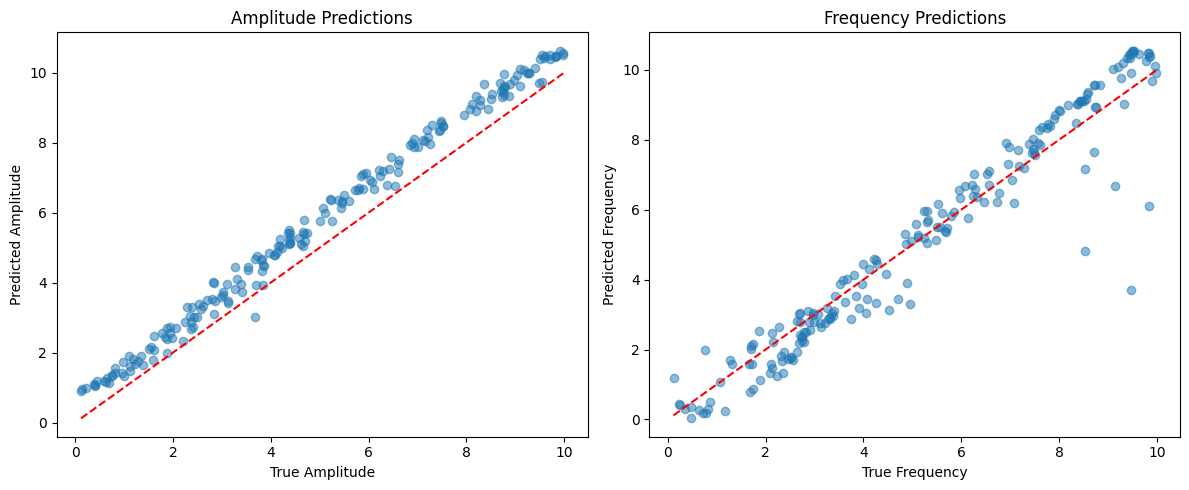

[I 2024-11-29 21:03:33,757] Trial 4 finished with values: [0.6171275973320007, 0.6747362017631531] and parameters: {'batch_size': 64, 'd_model': 128, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.0007804114782705504}.


Epoch [10/100], Train Loss: 0.0089, Val Loss: 0.0086, Time: 0.24s
Epoch [20/100], Train Loss: 0.0077, Val Loss: 0.0082, Time: 0.26s
Epoch [30/100], Train Loss: 0.0035, Val Loss: 0.0051, Time: 0.24s
Early stopping triggered
MSE - Amplitude: 0.0484, Frequency: 2.0087
MAE - Amplitude: 0.1777, Frequency: 1.2812


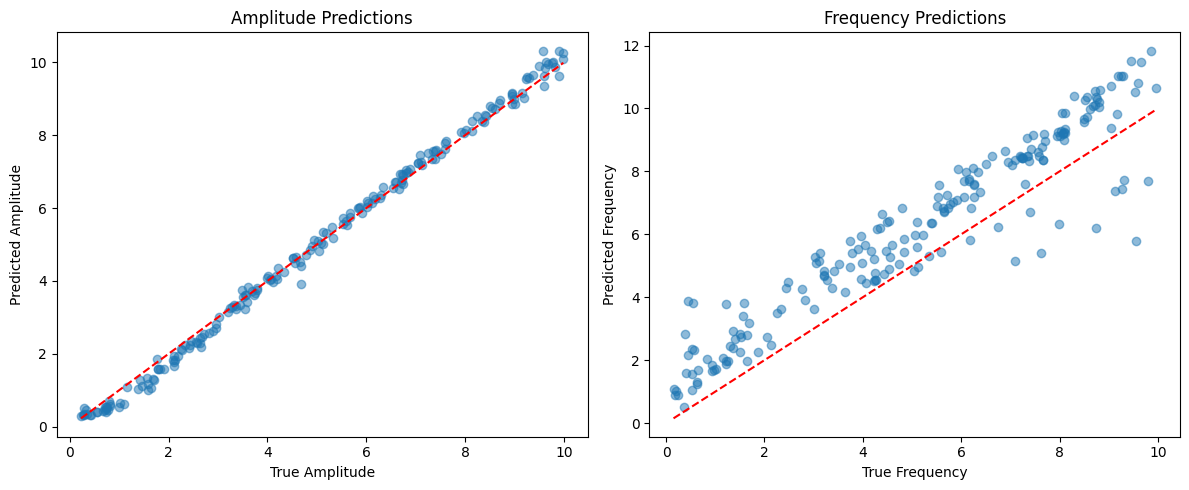

[I 2024-11-29 21:03:42,126] Trial 5 finished with values: [0.04844009503722191, 2.008676052093506] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0004401353420592745}.


Epoch [10/100], Train Loss: 0.0116, Val Loss: 0.0117, Time: 0.18s
Epoch [20/100], Train Loss: 0.0060, Val Loss: 0.0058, Time: 0.18s
Early stopping triggered
MSE - Amplitude: 0.9897, Frequency: 1.2630
MAE - Amplitude: 0.8205, Frequency: 0.9344


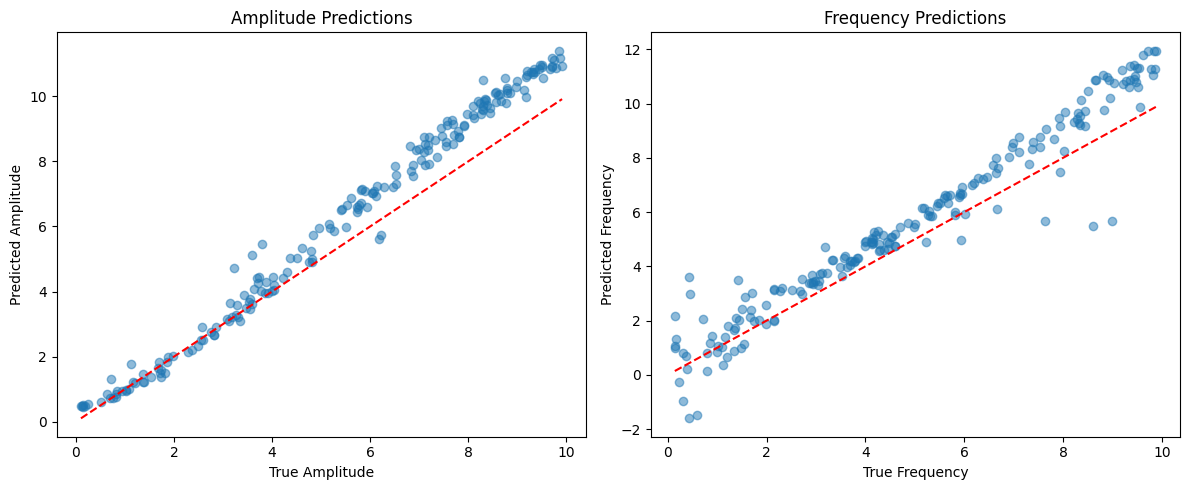

[I 2024-11-29 21:03:47,110] Trial 6 finished with values: [0.9897268414497375, 1.2630177736282349] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.0008563544551238757}.


Epoch [10/100], Train Loss: 0.0756, Val Loss: 0.0706, Time: 0.17s
Epoch [20/100], Train Loss: 0.0243, Val Loss: 0.0191, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 3.8964, Frequency: 2.7819
MAE - Amplitude: 1.7859, Frequency: 1.1925


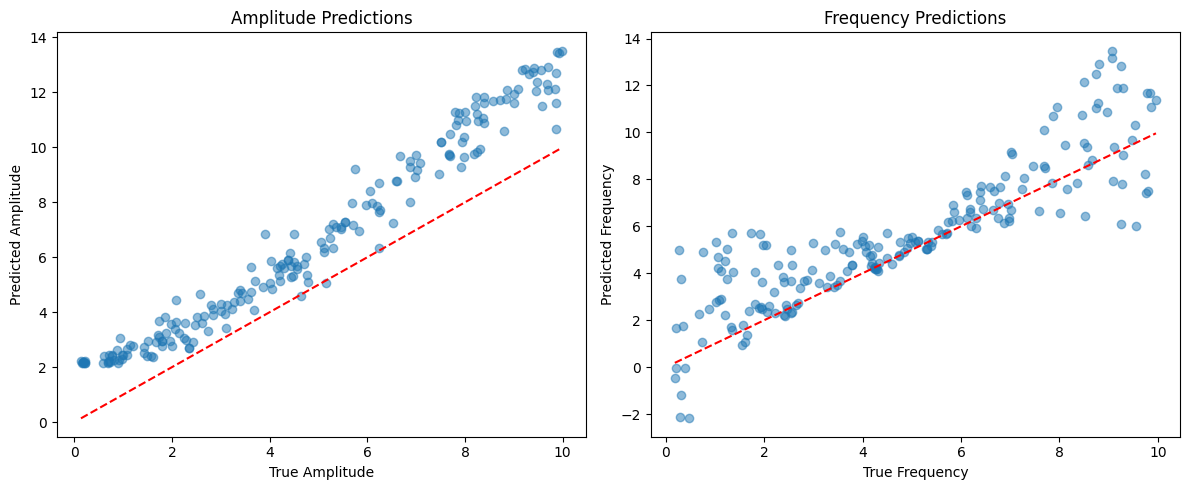

[I 2024-11-29 21:03:52,480] Trial 7 finished with values: [3.896437644958496, 2.7819249629974365] and parameters: {'batch_size': 32, 'd_model': 32, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.0002564061734527641}.


Epoch [10/100], Train Loss: 0.0373, Val Loss: 0.0220, Time: 0.15s
Early stopping triggered
MSE - Amplitude: 1.3731, Frequency: 1.2275
MAE - Amplitude: 0.9654, Frequency: 0.7817


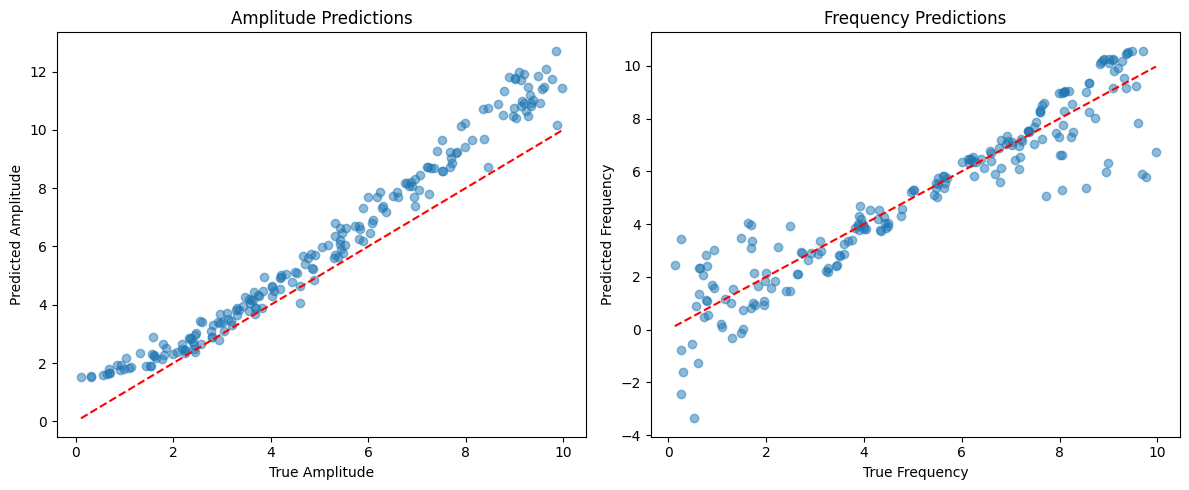

[I 2024-11-29 21:03:55,465] Trial 8 finished with values: [1.3731069564819336, 1.2274789810180664] and parameters: {'batch_size': 64, 'd_model': 64, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.0006161743742733897}.


Epoch [10/100], Train Loss: 0.0072, Val Loss: 0.0102, Time: 0.30s
Early stopping triggered
MSE - Amplitude: 0.1918, Frequency: 1.7881
MAE - Amplitude: 0.3756, Frequency: 1.1727


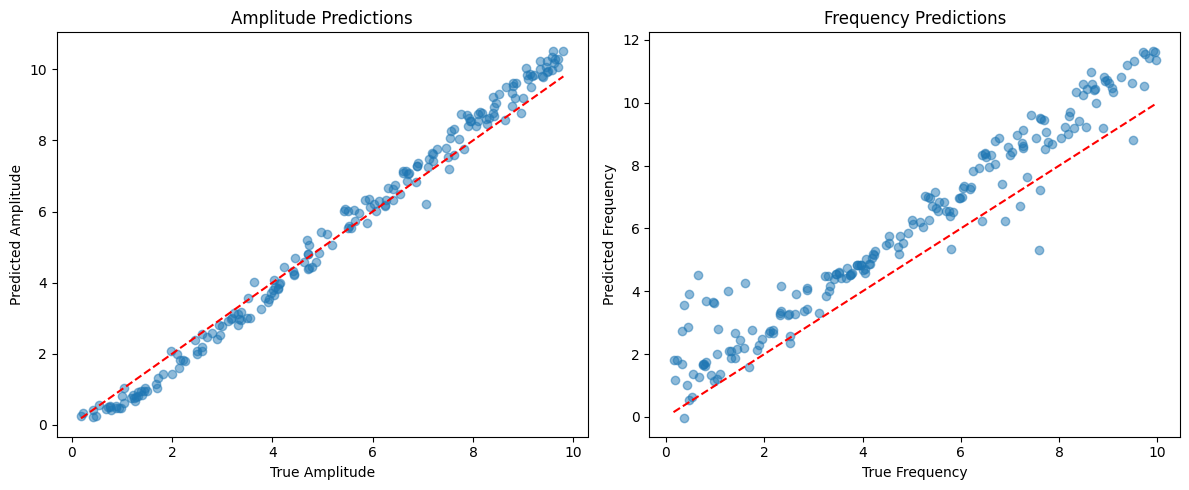

[I 2024-11-29 21:03:58,904] Trial 9 finished with values: [0.19179634749889374, 1.7881355285644531] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.4, 'learning_rate': 0.0005629973877955281}.


Epoch [10/100], Train Loss: 0.0162, Val Loss: 0.0141, Time: 0.17s
Epoch [20/100], Train Loss: 0.0086, Val Loss: 0.0072, Time: 0.18s
Epoch [30/100], Train Loss: 0.0082, Val Loss: 0.0060, Time: 0.23s
Early stopping triggered
MSE - Amplitude: 0.1790, Frequency: 0.6230
MAE - Amplitude: 0.3132, Frequency: 0.4809


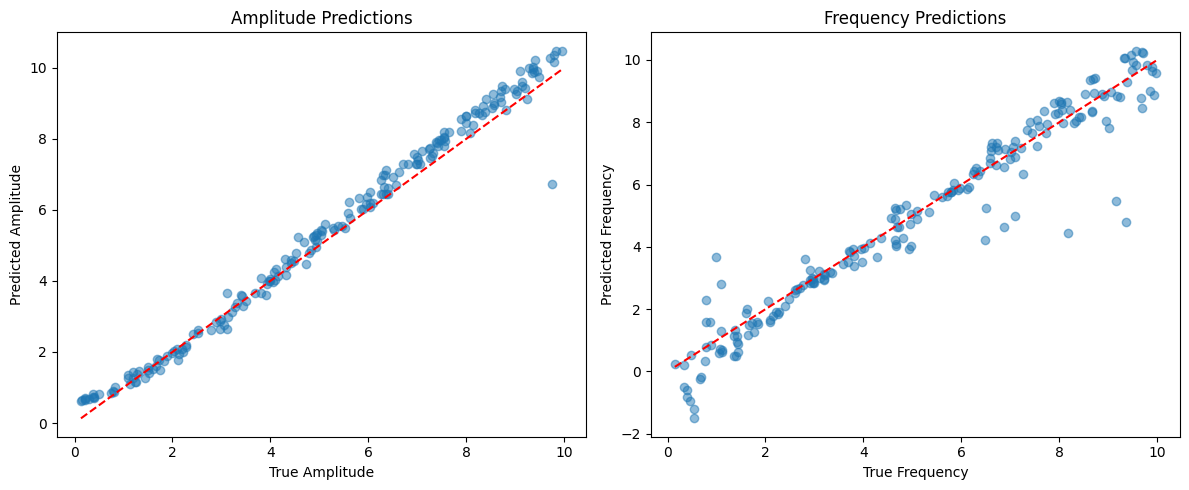

[I 2024-11-29 21:04:06,886] Trial 10 finished with values: [0.17899774014949799, 0.623034656047821] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.0002603389464269385}.


Epoch [10/100], Train Loss: 0.0118, Val Loss: 0.0187, Time: 0.27s
Early stopping triggered
MSE - Amplitude: 3.3097, Frequency: 1.3579
MAE - Amplitude: 1.6545, Frequency: 0.8666


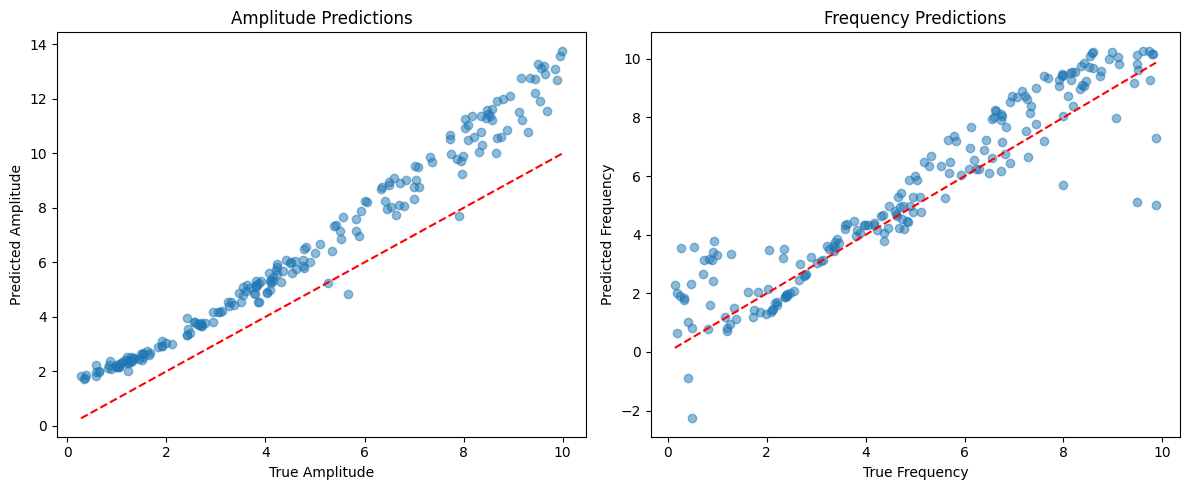

[I 2024-11-29 21:04:11,112] Trial 11 finished with values: [3.309694290161133, 1.3578746318817139] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.4, 'learning_rate': 0.00010109164180594765}.


Epoch [10/100], Train Loss: 0.0147, Val Loss: 0.0195, Time: 0.29s
Epoch [20/100], Train Loss: 0.0076, Val Loss: 0.0082, Time: 0.43s
Early stopping triggered
MSE - Amplitude: 0.5789, Frequency: 0.6784
MAE - Amplitude: 0.6297, Frequency: 0.5090


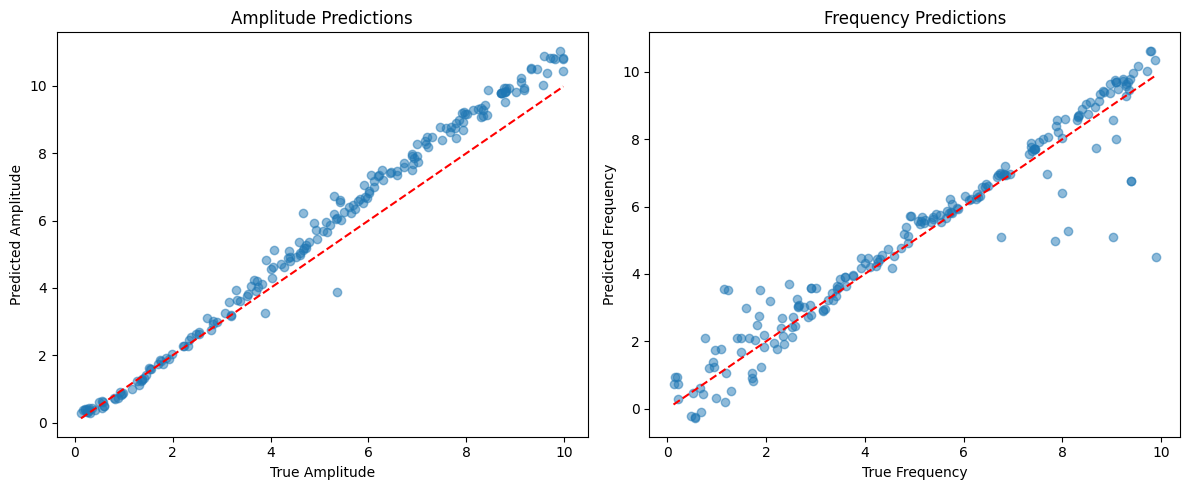

[I 2024-11-29 21:04:20,522] Trial 12 finished with values: [0.5789337754249573, 0.6784400343894958] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 512, 'dropout': 0.2, 'learning_rate': 0.00045101848972501214}.


Epoch [10/100], Train Loss: 0.0062, Val Loss: 0.0122, Time: 0.37s
Epoch [20/100], Train Loss: 0.0049, Val Loss: 0.0111, Time: 0.36s
Early stopping triggered
MSE - Amplitude: 0.4533, Frequency: 1.2213
MAE - Amplitude: 0.5148, Frequency: 0.9447


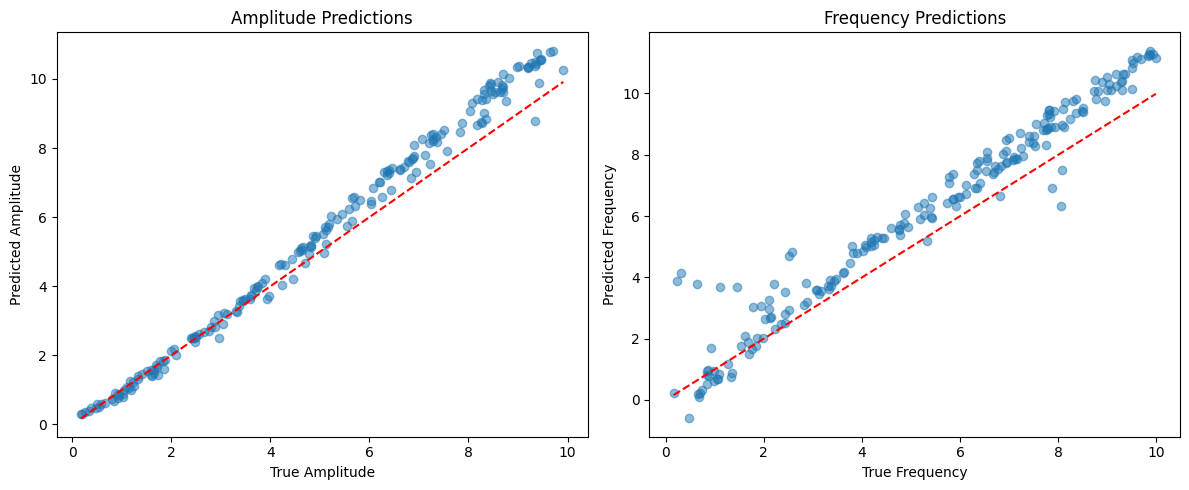

[I 2024-11-29 21:04:28,725] Trial 13 finished with values: [0.453257292509079, 1.221291184425354] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.00018578962152726857}.


Epoch [10/100], Train Loss: 0.0146, Val Loss: 0.0122, Time: 0.34s
Epoch [20/100], Train Loss: 0.0093, Val Loss: 0.0099, Time: 0.33s
Early stopping triggered
MSE - Amplitude: 0.2974, Frequency: 1.4101
MAE - Amplitude: 0.3852, Frequency: 0.9168


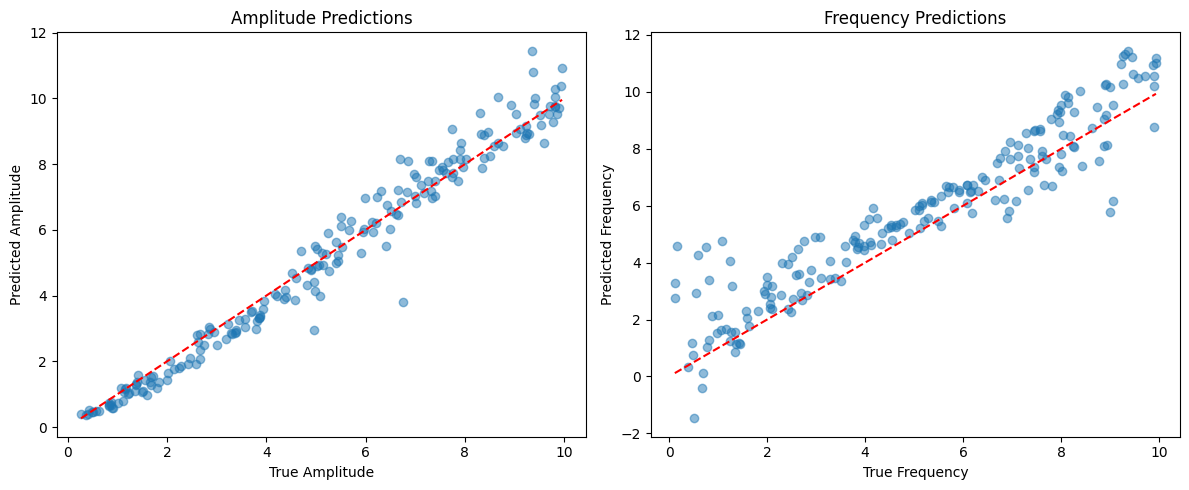

[I 2024-11-29 21:04:37,733] Trial 14 finished with values: [0.29742175340652466, 1.4101451635360718] and parameters: {'batch_size': 16, 'd_model': 32, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0003217343837813944}.


Epoch [10/100], Train Loss: 0.0090, Val Loss: 0.0144, Time: 0.73s
Epoch [20/100], Train Loss: 0.0053, Val Loss: 0.0149, Time: 0.57s
Early stopping triggered
MSE - Amplitude: 0.6211, Frequency: 0.7567
MAE - Amplitude: 0.6673, Frequency: 0.6916


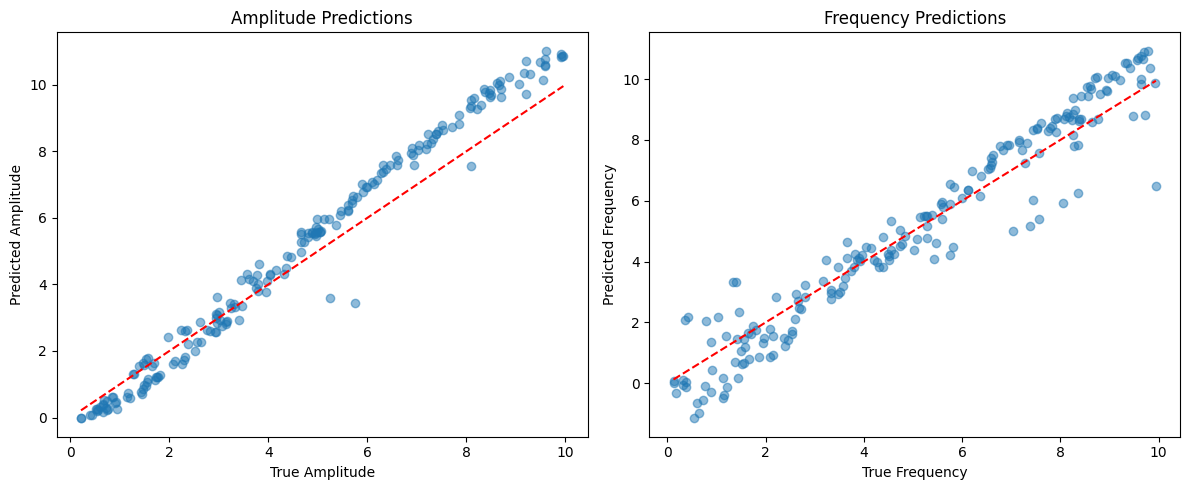

[I 2024-11-29 21:04:53,796] Trial 15 finished with values: [0.6211293935775757, 0.7566520571708679] and parameters: {'batch_size': 16, 'd_model': 64, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.00023789972613196727}.


Epoch [10/100], Train Loss: 0.0084, Val Loss: 0.0132, Time: 0.49s
Early stopping triggered
MSE - Amplitude: 0.4468, Frequency: 1.1065
MAE - Amplitude: 0.5338, Frequency: 0.7852


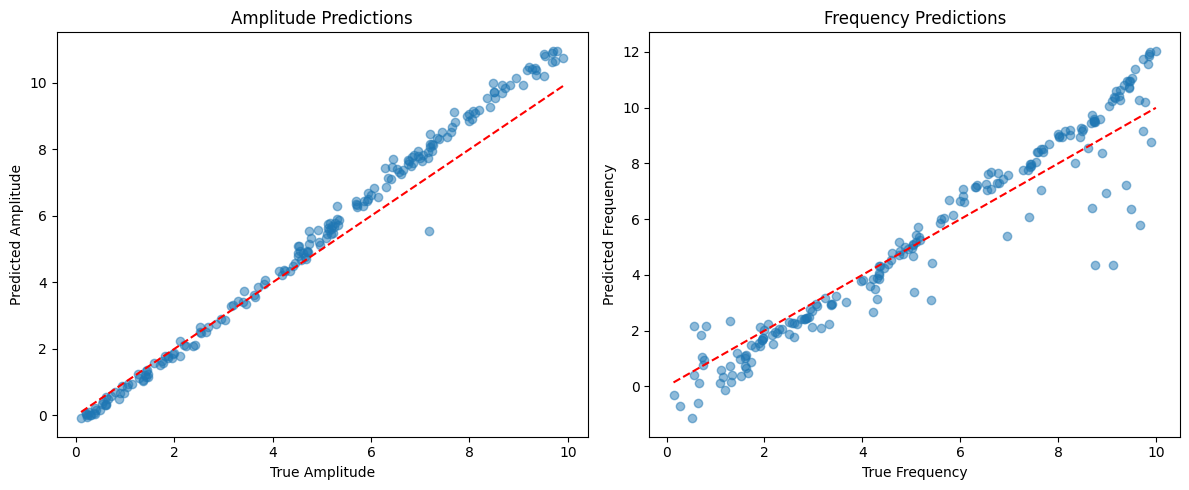

[I 2024-11-29 21:05:03,738] Trial 16 finished with values: [0.4467858374118805, 1.1064709424972534] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.0004881489484491663}.


Epoch [10/100], Train Loss: 0.0061, Val Loss: 0.0035, Time: 0.35s
Epoch [20/100], Train Loss: 0.0039, Val Loss: 0.0037, Time: 0.35s
Early stopping triggered
MSE - Amplitude: 0.0892, Frequency: 0.4087
MAE - Amplitude: 0.2336, Frequency: 0.4239


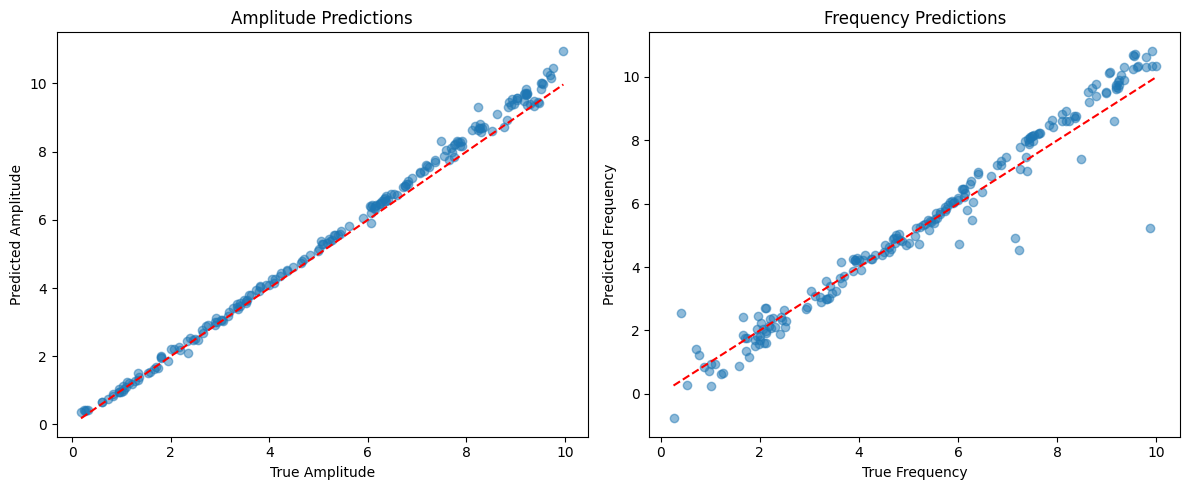

[I 2024-11-29 21:05:12,821] Trial 17 finished with values: [0.08920704573392868, 0.4086543023586273] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00015394582150067627}.


Epoch [10/100], Train Loss: 0.0125, Val Loss: 0.0156, Time: 0.23s
Epoch [20/100], Train Loss: 0.0070, Val Loss: 0.0079, Time: 0.24s
Early stopping triggered
MSE - Amplitude: 0.5901, Frequency: 0.8345
MAE - Amplitude: 0.7114, Frequency: 0.6357


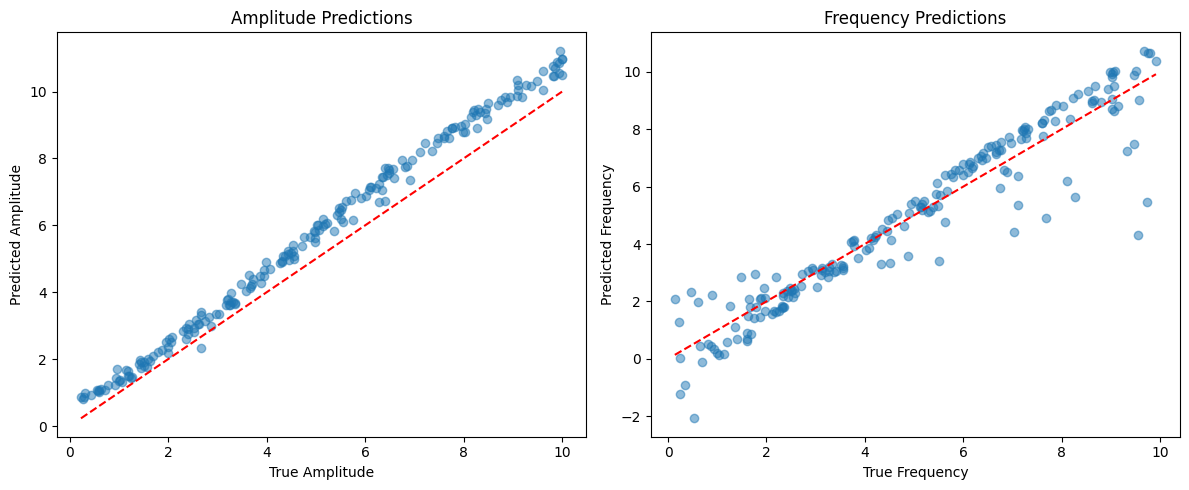

[I 2024-11-29 21:05:18,782] Trial 18 finished with values: [0.5901432037353516, 0.8344827890396118] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.0004570587174535073}.


Epoch [10/100], Train Loss: 0.0127, Val Loss: 0.0150, Time: 0.32s
Epoch [20/100], Train Loss: 0.0085, Val Loss: 0.0082, Time: 0.32s
Early stopping triggered
MSE - Amplitude: 0.7453, Frequency: 1.1342
MAE - Amplitude: 0.7436, Frequency: 0.8362


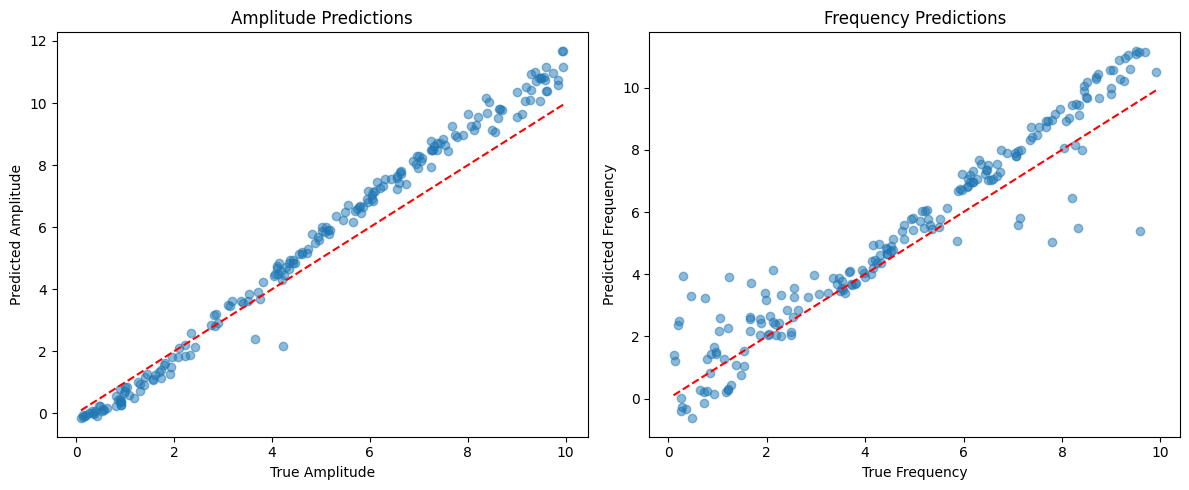

[I 2024-11-29 21:05:27,249] Trial 19 finished with values: [0.7453259825706482, 1.1341723203659058] and parameters: {'batch_size': 64, 'd_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.0004708195284263573}.


Epoch [10/100], Train Loss: 0.0857, Val Loss: 0.0875, Time: 0.17s
Epoch [20/100], Train Loss: 0.0808, Val Loss: 0.0771, Time: 0.17s
Epoch [30/100], Train Loss: 0.0633, Val Loss: 0.0577, Time: 0.17s
Epoch [40/100], Train Loss: 0.0200, Val Loss: 0.0163, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 0.8059, Frequency: 2.1471
MAE - Amplitude: 0.7072, Frequency: 1.1703


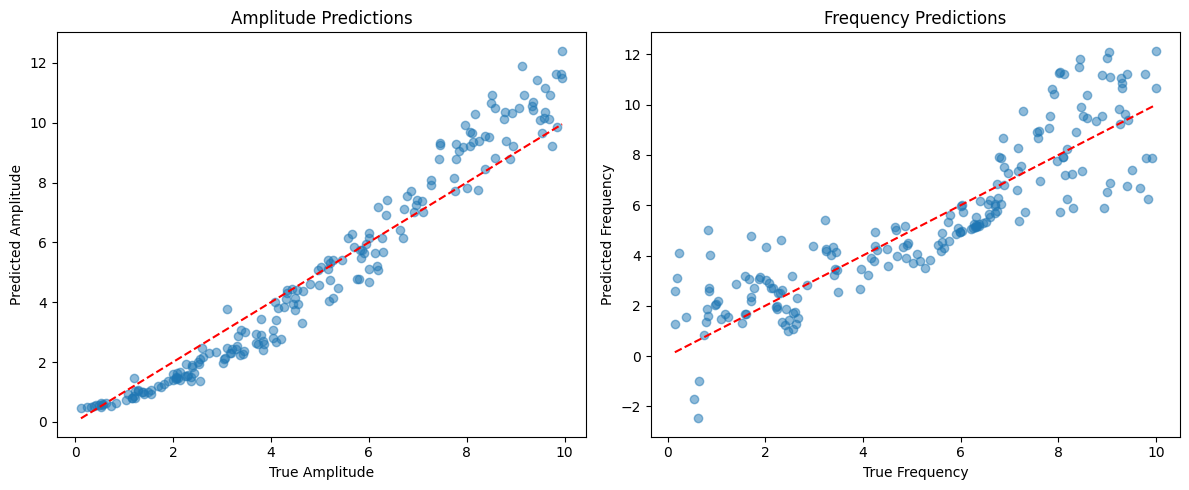

[I 2024-11-29 21:05:35,080] Trial 20 finished with values: [0.8059419393539429, 2.1471292972564697] and parameters: {'batch_size': 64, 'd_model': 32, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 256, 'dropout': 0.4, 'learning_rate': 0.00019969149785415333}.


Epoch [10/100], Train Loss: 0.0119, Val Loss: 0.0203, Time: 0.41s
Early stopping triggered
MSE - Amplitude: 0.9060, Frequency: 1.3791
MAE - Amplitude: 0.6914, Frequency: 0.9082


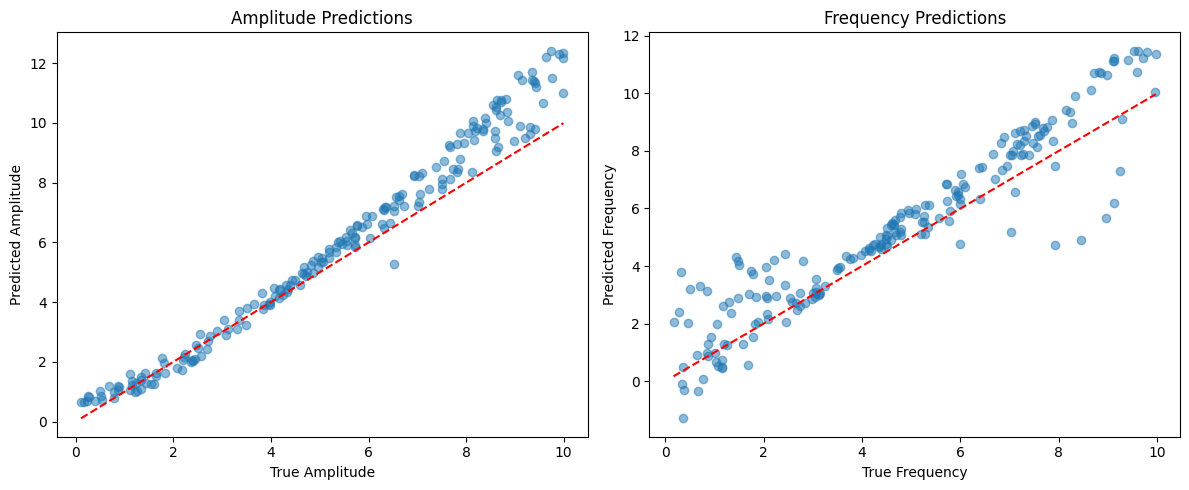

[I 2024-11-29 21:05:43,328] Trial 21 finished with values: [0.9059556722640991, 1.3790980577468872] and parameters: {'batch_size': 64, 'd_model': 256, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.00012478240825951586}.


Epoch [10/100], Train Loss: 0.0119, Val Loss: 0.0139, Time: 0.28s
Early stopping triggered
MSE - Amplitude: 0.6947, Frequency: 1.2603
MAE - Amplitude: 0.7003, Frequency: 0.7491


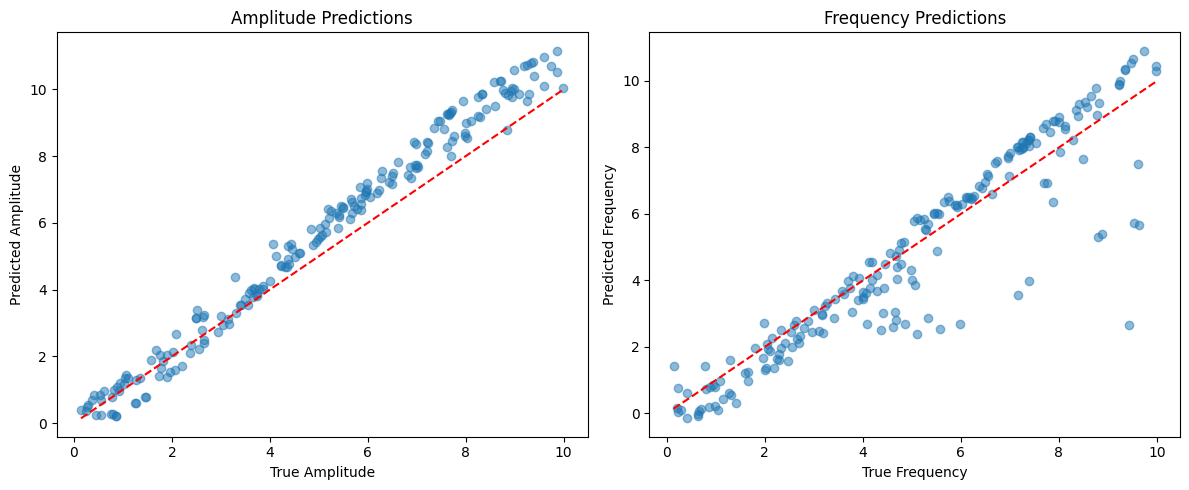

[I 2024-11-29 21:05:49,377] Trial 22 finished with values: [0.6946691870689392, 1.2602858543395996] and parameters: {'batch_size': 64, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.000914975475932256}.


Epoch [10/100], Train Loss: 0.0115, Val Loss: 0.0152, Time: 0.56s
Epoch [20/100], Train Loss: 0.0062, Val Loss: 0.0151, Time: 0.57s
Epoch [30/100], Train Loss: 0.0052, Val Loss: 0.0117, Time: 0.55s
Early stopping triggered
MSE - Amplitude: 0.8921, Frequency: 1.0133
MAE - Amplitude: 0.7880, Frequency: 0.8109


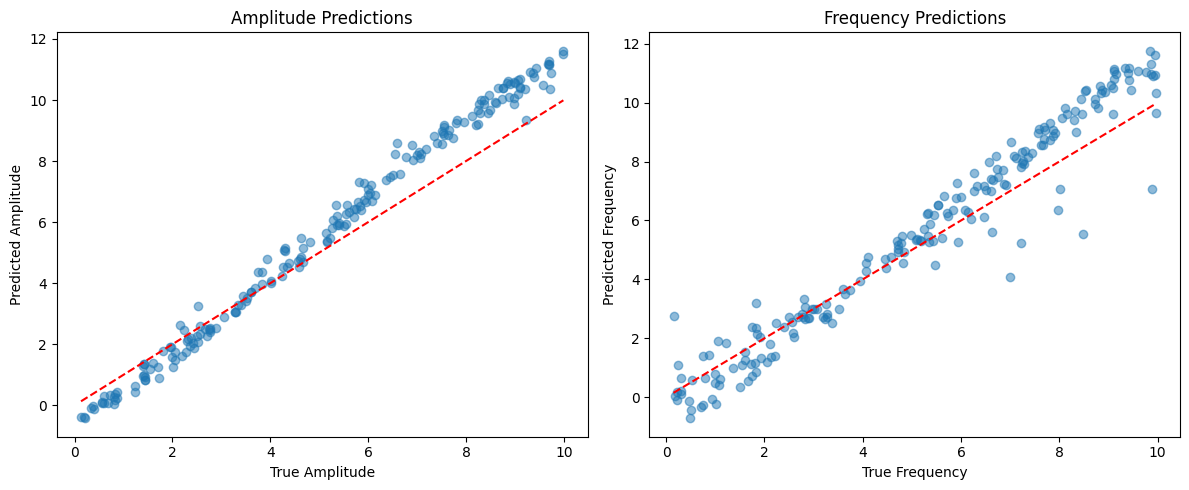

[I 2024-11-29 21:06:09,399] Trial 23 finished with values: [0.8921223282814026, 1.0132514238357544] and parameters: {'batch_size': 16, 'd_model': 64, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.4, 'learning_rate': 0.0002779170378583336}.


Epoch [10/100], Train Loss: 0.0743, Val Loss: 0.0780, Time: 0.29s
Epoch [20/100], Train Loss: 0.0219, Val Loss: 0.0218, Time: 0.40s
Epoch [30/100], Train Loss: 0.0090, Val Loss: 0.0127, Time: 0.28s
Early stopping triggered
MSE - Amplitude: 0.6215, Frequency: 1.0734
MAE - Amplitude: 0.6830, Frequency: 0.7997


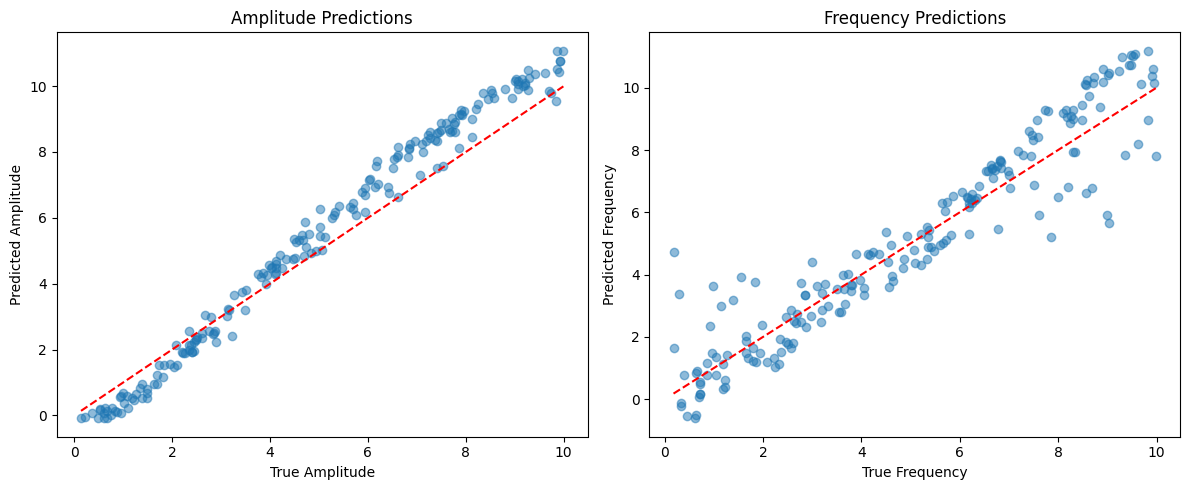

[I 2024-11-29 21:06:21,444] Trial 24 finished with values: [0.6215211749076843, 1.0734436511993408] and parameters: {'batch_size': 32, 'd_model': 32, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.00034132126383724817}.


Epoch [10/100], Train Loss: 0.0074, Val Loss: 0.0106, Time: 0.33s
Epoch [20/100], Train Loss: 0.0063, Val Loss: 0.0049, Time: 0.43s
Epoch [30/100], Train Loss: 0.0038, Val Loss: 0.0027, Time: 0.35s
Early stopping triggered
MSE - Amplitude: 0.1556, Frequency: 0.3887
MAE - Amplitude: 0.3006, Frequency: 0.3956


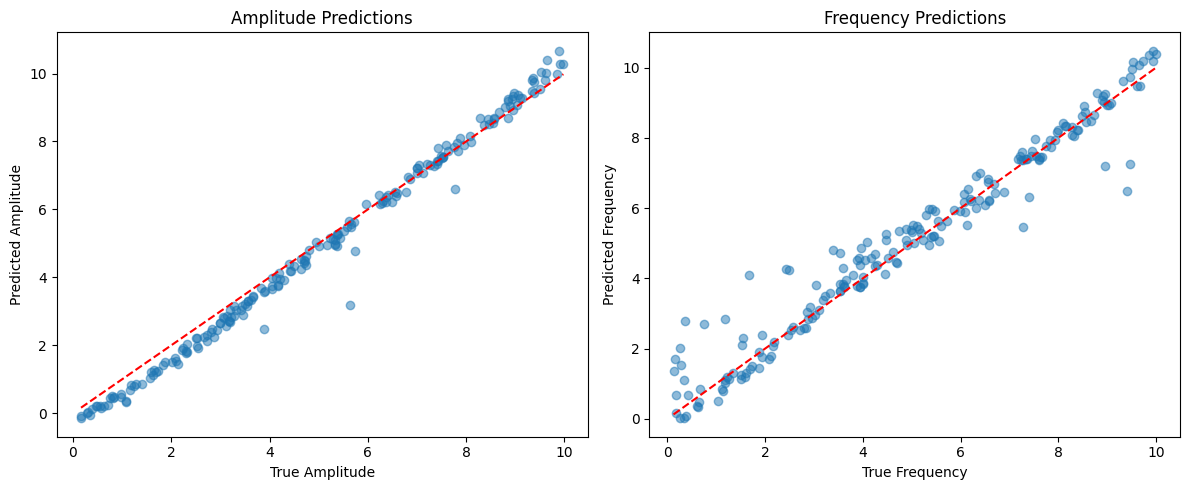

[I 2024-11-29 21:06:34,550] Trial 25 finished with values: [0.1556224822998047, 0.38872185349464417] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.0004047380966868934}.


Epoch [10/100], Train Loss: 0.0056, Val Loss: 0.0046, Time: 0.80s
Epoch [20/100], Train Loss: 0.0062, Val Loss: 0.0049, Time: 0.65s
Early stopping triggered
MSE - Amplitude: 0.5494, Frequency: 0.4835
MAE - Amplitude: 0.6828, Frequency: 0.5998


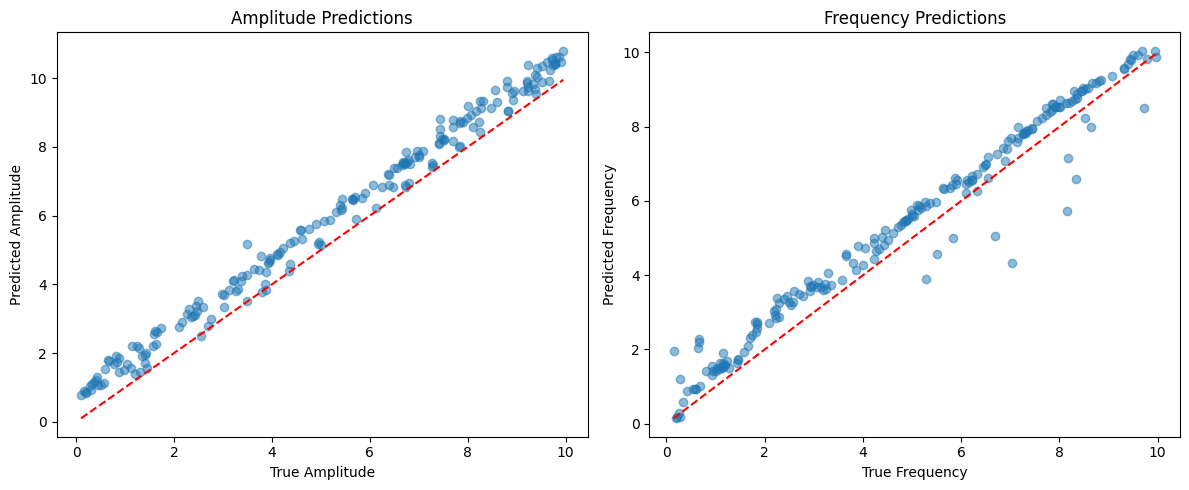

[I 2024-11-29 21:06:49,888] Trial 26 finished with values: [0.5493514537811279, 0.48347872495651245] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.0005901374017036438}.


Epoch [10/100], Train Loss: 0.0692, Val Loss: 0.0656, Time: 0.13s
Epoch [20/100], Train Loss: 0.0180, Val Loss: 0.0207, Time: 0.13s
Early stopping triggered
MSE - Amplitude: 0.7378, Frequency: 2.7206
MAE - Amplitude: 0.6735, Frequency: 1.3519


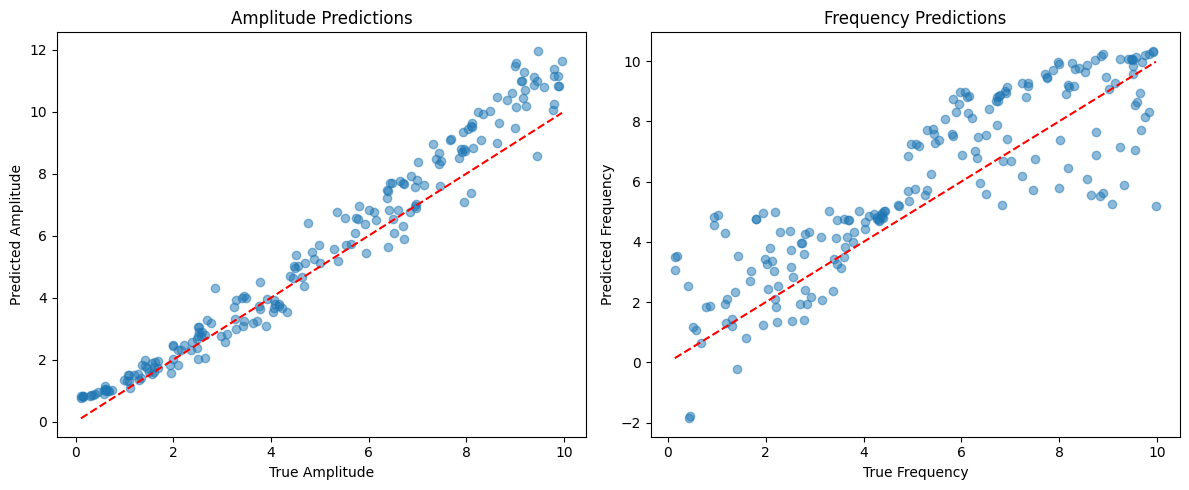

[I 2024-11-29 21:06:54,258] Trial 27 finished with values: [0.7378183007240295, 2.720597743988037] and parameters: {'batch_size': 64, 'd_model': 32, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00035488170027256653}.


Epoch [10/100], Train Loss: 0.0096, Val Loss: 0.0267, Time: 0.57s
Epoch [20/100], Train Loss: 0.0060, Val Loss: 0.0164, Time: 0.65s
Early stopping triggered
MSE - Amplitude: 0.9685, Frequency: 1.9788
MAE - Amplitude: 0.8401, Frequency: 1.1691


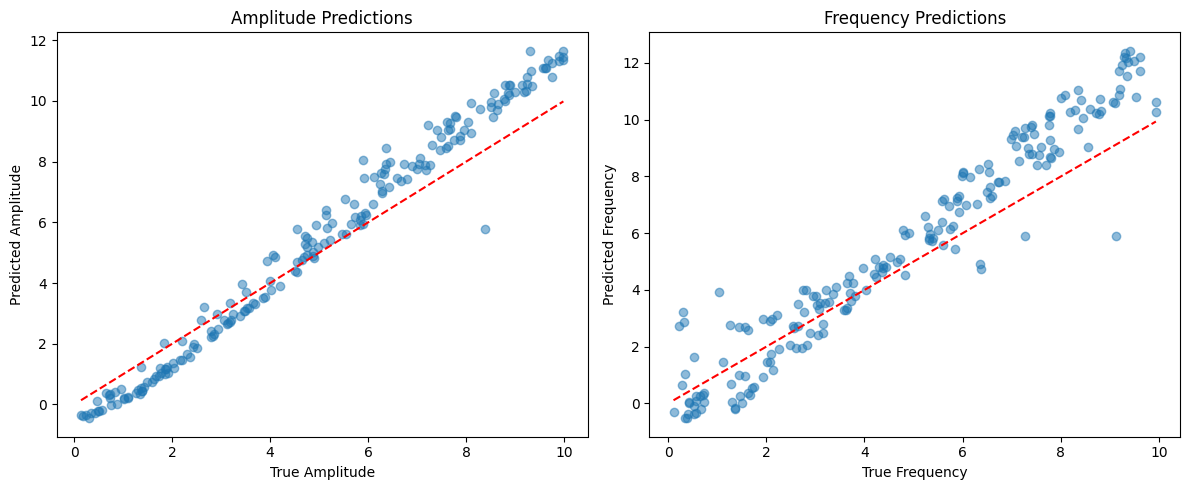

[I 2024-11-29 21:07:11,020] Trial 28 finished with values: [0.9684666395187378, 1.9787511825561523] and parameters: {'batch_size': 16, 'd_model': 64, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.4, 'learning_rate': 0.00023221269107055634}.


Epoch [10/100], Train Loss: 0.0099, Val Loss: 0.0174, Time: 0.35s
Epoch [20/100], Train Loss: 0.0066, Val Loss: 0.0106, Time: 0.36s
Early stopping triggered
MSE - Amplitude: 0.3139, Frequency: 0.7059
MAE - Amplitude: 0.4551, Frequency: 0.6717


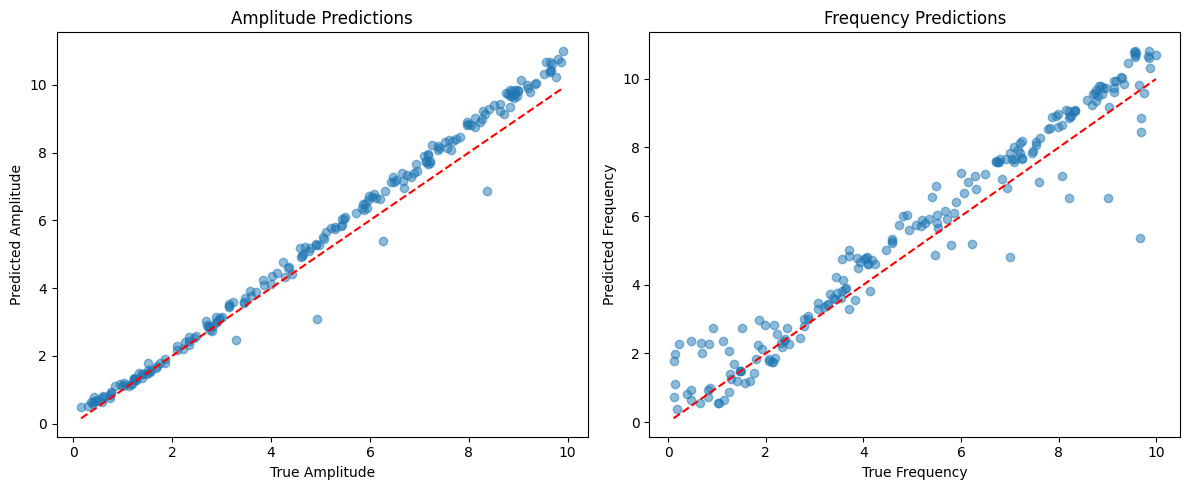

[I 2024-11-29 21:07:21,373] Trial 29 finished with values: [0.3139127492904663, 0.7058863639831543] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00010949682281717149}.


Epoch [10/100], Train Loss: 0.0647, Val Loss: 0.0751, Time: 0.19s
Epoch [20/100], Train Loss: 0.0342, Val Loss: 0.0297, Time: 0.20s
Epoch [30/100], Train Loss: 0.0135, Val Loss: 0.0111, Time: 0.20s
Early stopping triggered
MSE - Amplitude: 0.5542, Frequency: 1.6837
MAE - Amplitude: 0.6341, Frequency: 1.0490


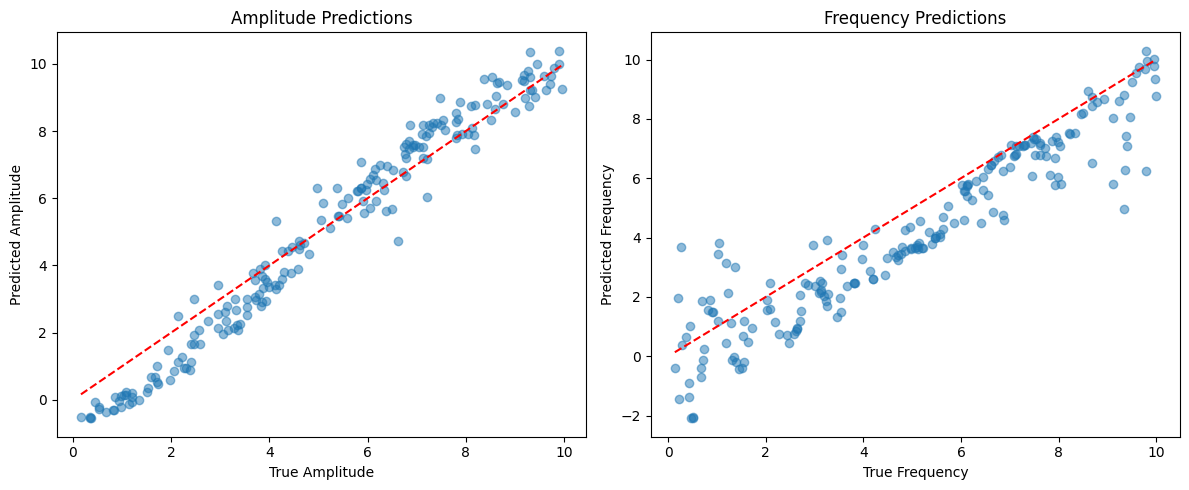

[I 2024-11-29 21:07:27,944] Trial 30 finished with values: [0.5542203783988953, 1.6837458610534668] and parameters: {'batch_size': 64, 'd_model': 32, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 512, 'dropout': 0.2, 'learning_rate': 0.0006137960903254035}.


Epoch [10/100], Train Loss: 0.0659, Val Loss: 0.0653, Time: 0.20s
Epoch [20/100], Train Loss: 0.0225, Val Loss: 0.0267, Time: 0.22s
Epoch [30/100], Train Loss: 0.0146, Val Loss: 0.0180, Time: 0.25s
Early stopping triggered
MSE - Amplitude: 1.9909, Frequency: 2.3828
MAE - Amplitude: 1.3175, Frequency: 1.2192


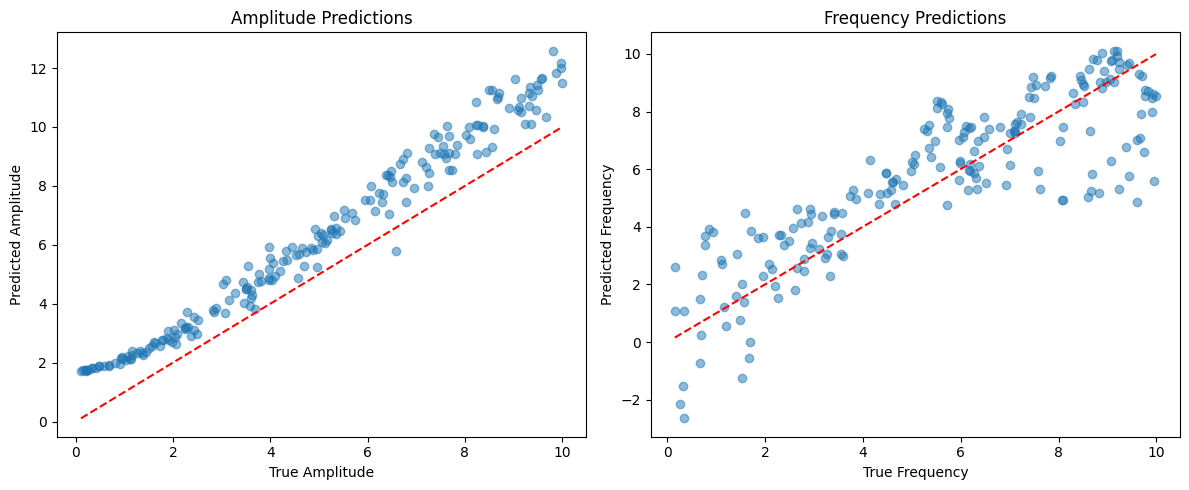

[I 2024-11-29 21:07:35,259] Trial 31 finished with values: [1.990921974182129, 2.3827619552612305] and parameters: {'batch_size': 64, 'd_model': 64, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00012607442793479461}.


Epoch [10/100], Train Loss: 0.0679, Val Loss: 0.0584, Time: 0.17s
Epoch [20/100], Train Loss: 0.0139, Val Loss: 0.0128, Time: 0.17s
Epoch [30/100], Train Loss: 0.0110, Val Loss: 0.0072, Time: 0.19s
Epoch [40/100], Train Loss: 0.0090, Val Loss: 0.0056, Time: 0.18s
Epoch [50/100], Train Loss: 0.0077, Val Loss: 0.0042, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 0.2150, Frequency: 0.6588
MAE - Amplitude: 0.3851, Frequency: 0.5740


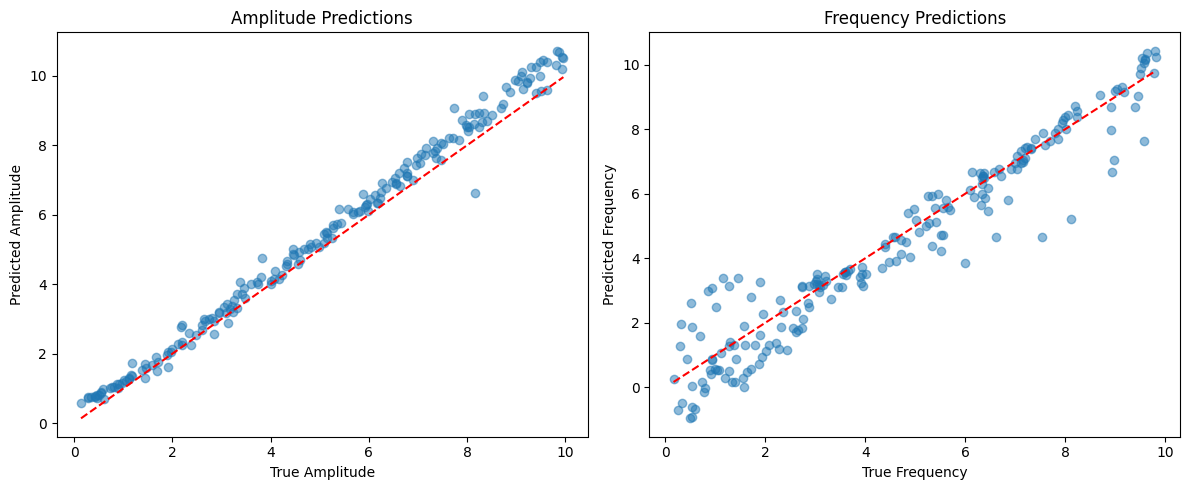

[I 2024-11-29 21:07:46,033] Trial 32 finished with values: [0.21500787138938904, 0.6587855815887451] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.000201551590901031}.


Epoch [10/100], Train Loss: 0.0109, Val Loss: 0.0085, Time: 0.45s
Epoch [20/100], Train Loss: 0.0067, Val Loss: 0.0057, Time: 0.45s
Epoch [30/100], Train Loss: 0.0054, Val Loss: 0.0045, Time: 0.46s
Epoch [40/100], Train Loss: 0.0041, Val Loss: 0.0025, Time: 0.46s
Epoch [50/100], Train Loss: 0.0046, Val Loss: 0.0034, Time: 0.46s
Early stopping triggered
MSE - Amplitude: 0.2140, Frequency: 0.3679
MAE - Amplitude: 0.3749, Frequency: 0.3997


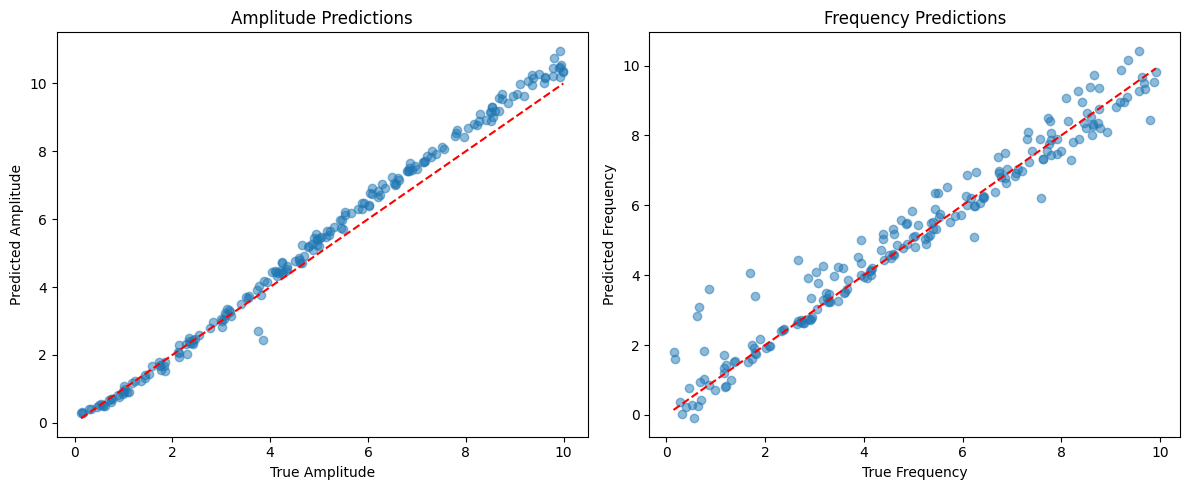

[I 2024-11-29 21:08:11,455] Trial 33 finished with values: [0.21395517885684967, 0.36790919303894043] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00011389918949650016}.


Epoch [10/100], Train Loss: 0.0060, Val Loss: 0.0258, Time: 0.64s
Early stopping triggered
MSE - Amplitude: 1.1841, Frequency: 1.7910
MAE - Amplitude: 0.8900, Frequency: 1.1952


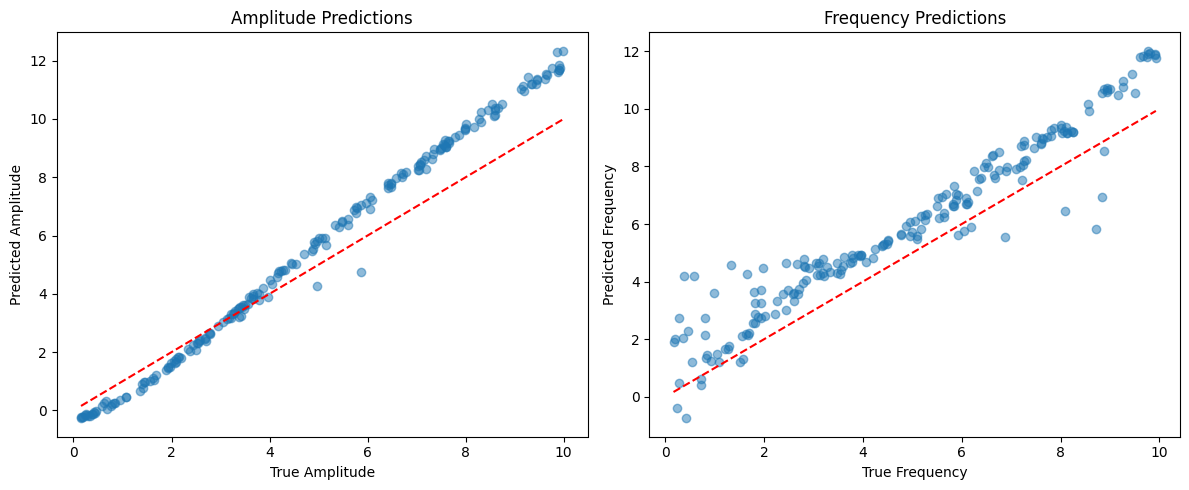

[I 2024-11-29 21:08:21,071] Trial 34 finished with values: [1.18409264087677, 1.7910171747207642] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.4, 'learning_rate': 0.0001768415527311333}.


Epoch [10/100], Train Loss: 0.0243, Val Loss: 0.0254, Time: 0.48s
Epoch [20/100], Train Loss: 0.0128, Val Loss: 0.0113, Time: 0.35s
Epoch [30/100], Train Loss: 0.0088, Val Loss: 0.0112, Time: 0.33s
Early stopping triggered
MSE - Amplitude: 0.5514, Frequency: 1.3979
MAE - Amplitude: 0.5683, Frequency: 0.9377


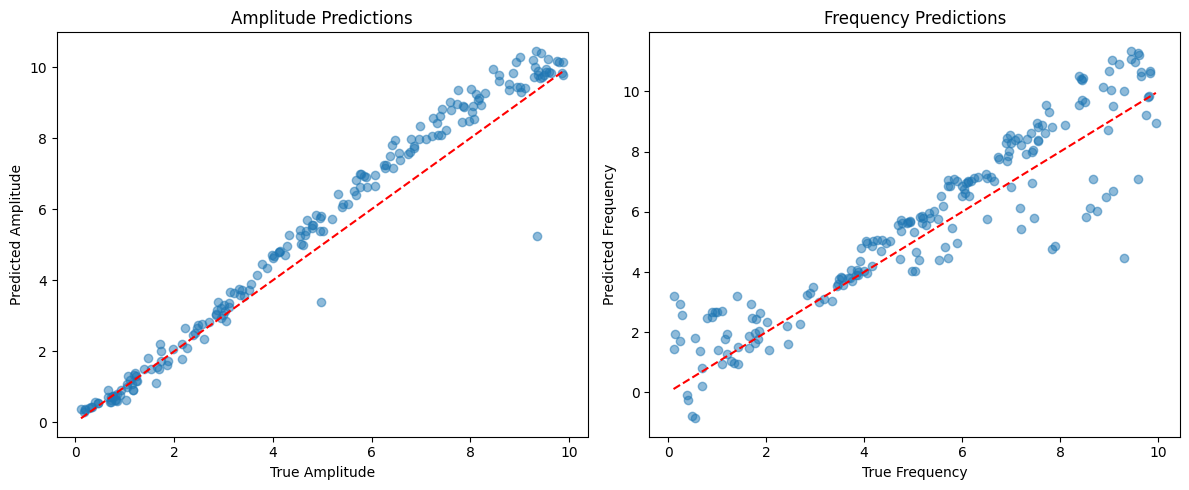

[I 2024-11-29 21:08:35,596] Trial 35 finished with values: [0.5514459013938904, 1.397865891456604] and parameters: {'batch_size': 16, 'd_model': 32, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.3, 'learning_rate': 0.0002805963453138966}.


Epoch [10/100], Train Loss: 0.0525, Val Loss: 0.0484, Time: 0.24s
Early stopping triggered
MSE - Amplitude: 1.7317, Frequency: 2.4604
MAE - Amplitude: 0.9752, Frequency: 1.2656


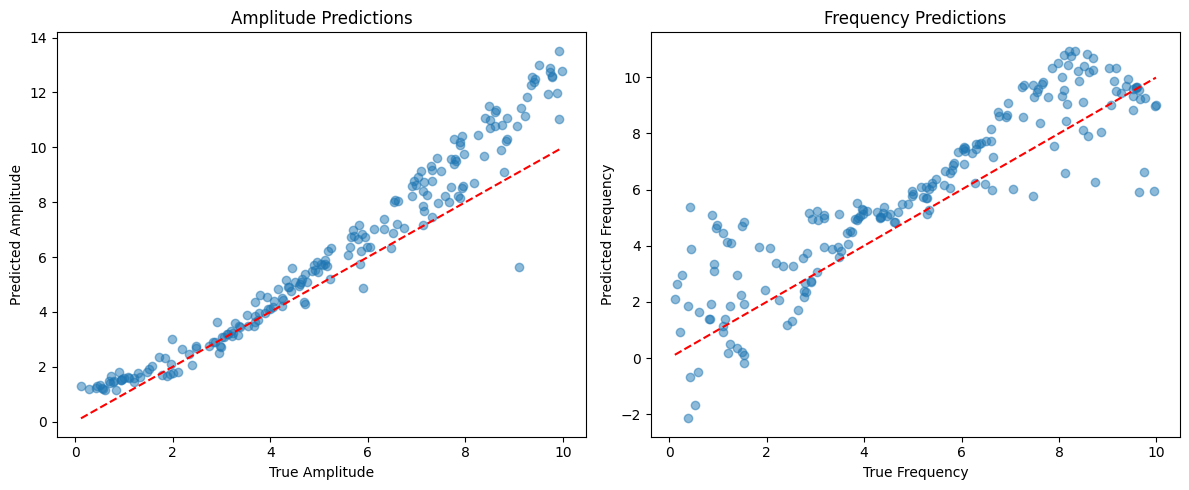

[I 2024-11-29 21:08:40,296] Trial 36 finished with values: [1.7317091226577759, 2.4604034423828125] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.00012558139950547402}.


Epoch [10/100], Train Loss: 0.0089, Val Loss: 0.0077, Time: 0.24s
Early stopping triggered
MSE - Amplitude: 0.3163, Frequency: 0.9527
MAE - Amplitude: 0.4908, Frequency: 0.6456


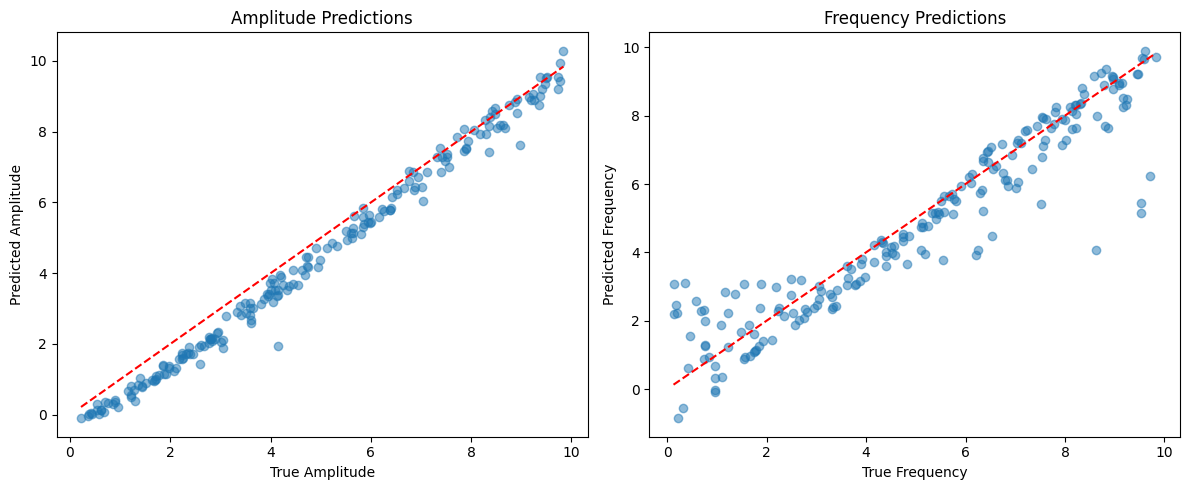

[I 2024-11-29 21:08:44,504] Trial 37 finished with values: [0.3163052201271057, 0.9526789784431458] and parameters: {'batch_size': 64, 'd_model': 128, 'nhead': 8, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.0007182641370799988}.


Epoch [10/100], Train Loss: 0.0109, Val Loss: 0.0115, Time: 0.46s
Early stopping triggered
MSE - Amplitude: 0.6320, Frequency: 1.2118
MAE - Amplitude: 0.6228, Frequency: 0.8527


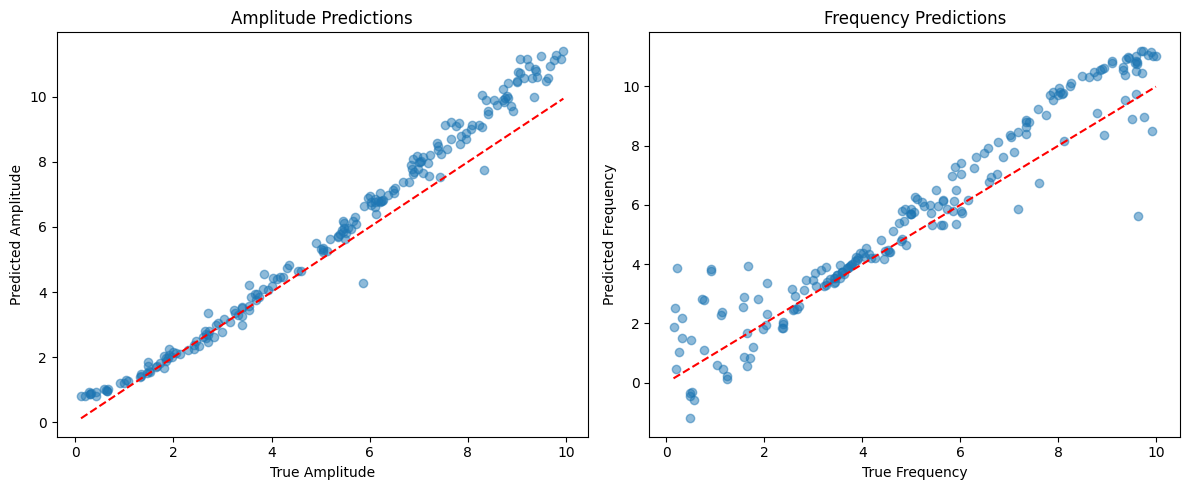

[I 2024-11-29 21:08:53,346] Trial 38 finished with values: [0.632002592086792, 1.2118393182754517] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00012393093945017937}.


Epoch [10/100], Train Loss: 0.0785, Val Loss: 0.0991, Time: 0.25s
Early stopping triggered
MSE - Amplitude: 9.2966, Frequency: 7.9076
MAE - Amplitude: 2.5756, Frequency: 2.4152


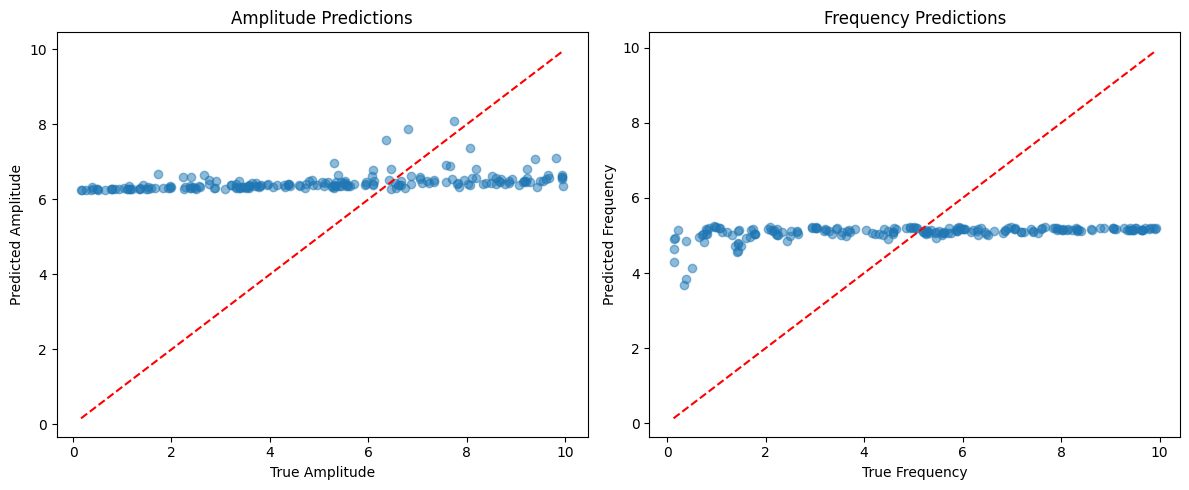

[I 2024-11-29 21:08:56,830] Trial 39 finished with values: [9.296603202819824, 7.907646656036377] and parameters: {'batch_size': 64, 'd_model': 32, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.00013795199559102163}.


Epoch [10/100], Train Loss: 0.0783, Val Loss: 0.0803, Time: 0.17s
Epoch [20/100], Train Loss: 0.0438, Val Loss: 0.0479, Time: 0.18s
Epoch [30/100], Train Loss: 0.0146, Val Loss: 0.0184, Time: 0.17s
Epoch [40/100], Train Loss: 0.0110, Val Loss: 0.0118, Time: 0.25s
Epoch [50/100], Train Loss: 0.0083, Val Loss: 0.0106, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 0.3186, Frequency: 2.0589
MAE - Amplitude: 0.4361, Frequency: 1.1932


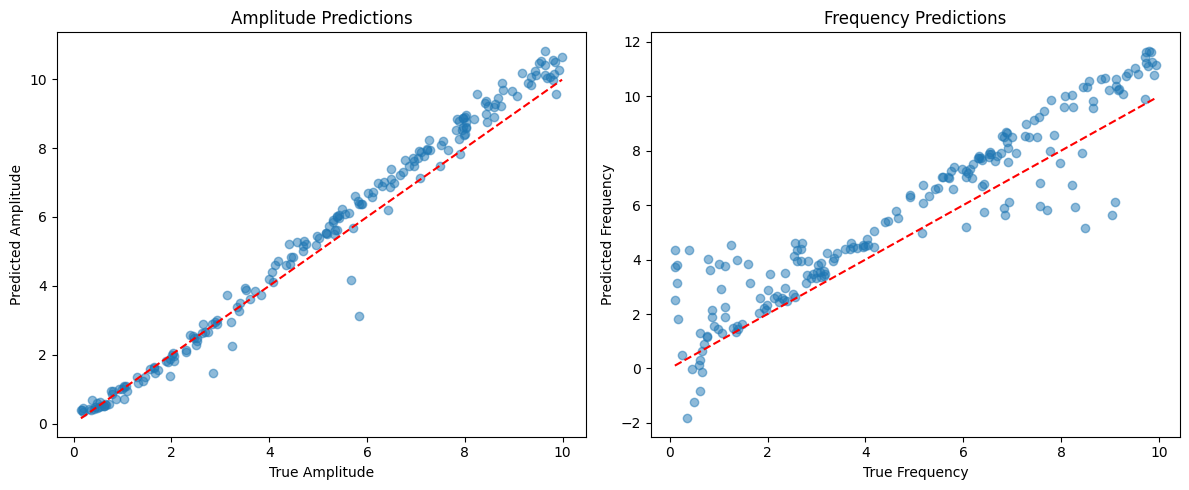

[I 2024-11-29 21:09:08,316] Trial 40 finished with values: [0.31864476203918457, 2.0589020252227783] and parameters: {'batch_size': 32, 'd_model': 32, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.0001798077362638412}.


Epoch [10/100], Train Loss: 0.0742, Val Loss: 0.0699, Time: 0.18s
Epoch [20/100], Train Loss: 0.0302, Val Loss: 0.0350, Time: 0.17s
Epoch [30/100], Train Loss: 0.0124, Val Loss: 0.0296, Time: 0.17s
Epoch [40/100], Train Loss: 0.0093, Val Loss: 0.0245, Time: 0.19s
Epoch [50/100], Train Loss: 0.0078, Val Loss: 0.0162, Time: 0.25s
Epoch [60/100], Train Loss: 0.0059, Val Loss: 0.0116, Time: 0.17s
Epoch [70/100], Train Loss: 0.0052, Val Loss: 0.0112, Time: 0.19s
Epoch [80/100], Train Loss: 0.0050, Val Loss: 0.0087, Time: 0.17s
Epoch [90/100], Train Loss: 0.0046, Val Loss: 0.0086, Time: 0.19s
Early stopping triggered
MSE - Amplitude: 0.7029, Frequency: 0.9611
MAE - Amplitude: 0.6795, Frequency: 0.8056


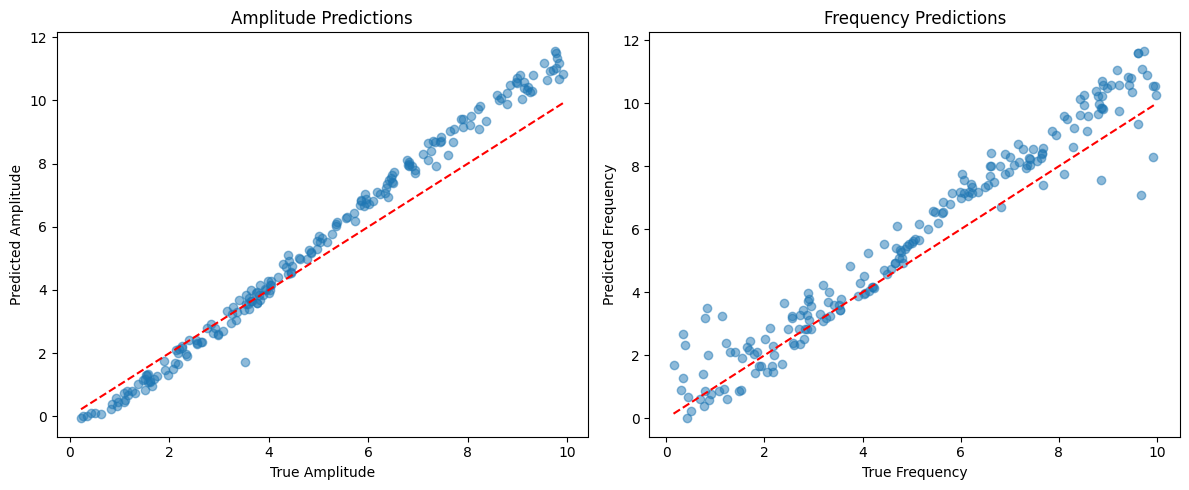

[I 2024-11-29 21:09:27,304] Trial 41 finished with values: [0.7029021978378296, 0.9610623121261597] and parameters: {'batch_size': 32, 'd_model': 32, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.00024968580011151896}.


Epoch [10/100], Train Loss: 0.0072, Val Loss: 0.0105, Time: 0.27s
Epoch [20/100], Train Loss: 0.0052, Val Loss: 0.0080, Time: 0.25s
Early stopping triggered
MSE - Amplitude: 0.6802, Frequency: 0.9555
MAE - Amplitude: 0.7175, Frequency: 0.7860


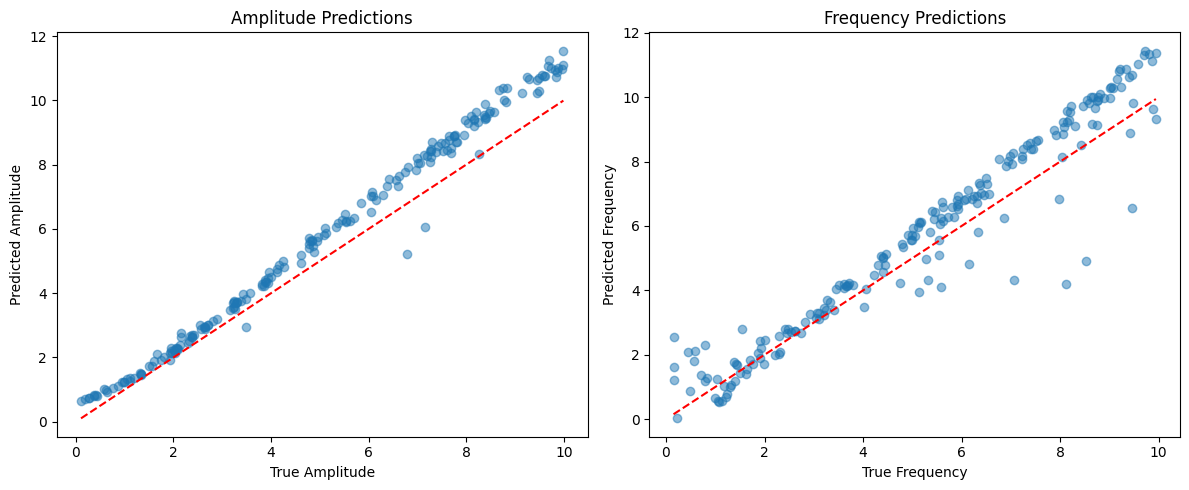

[I 2024-11-29 21:09:33,055] Trial 42 finished with values: [0.680173933506012, 0.9555197954177856] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.4, 'learning_rate': 0.0001618087737332339}.


Epoch [10/100], Train Loss: 0.0505, Val Loss: 0.0758, Time: 0.28s
Epoch [20/100], Train Loss: 0.0175, Val Loss: 0.0356, Time: 0.29s
Early stopping triggered
MSE - Amplitude: 5.1213, Frequency: 2.6434
MAE - Amplitude: 1.9625, Frequency: 1.3348


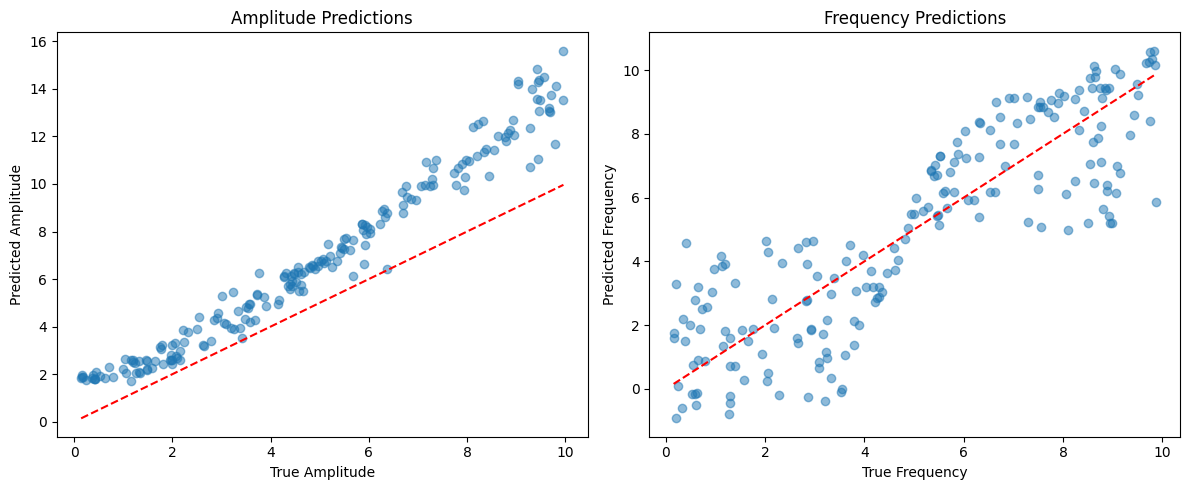

[I 2024-11-29 21:09:39,781] Trial 43 finished with values: [5.121346950531006, 2.643397331237793] and parameters: {'batch_size': 32, 'd_model': 64, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.4, 'learning_rate': 0.00011417302187827856}.


Epoch [10/100], Train Loss: 0.0135, Val Loss: 0.0133, Time: 0.42s
Epoch [20/100], Train Loss: 0.0086, Val Loss: 0.0078, Time: 0.34s
Early stopping triggered
MSE - Amplitude: 0.1954, Frequency: 1.2591
MAE - Amplitude: 0.3419, Frequency: 0.8600


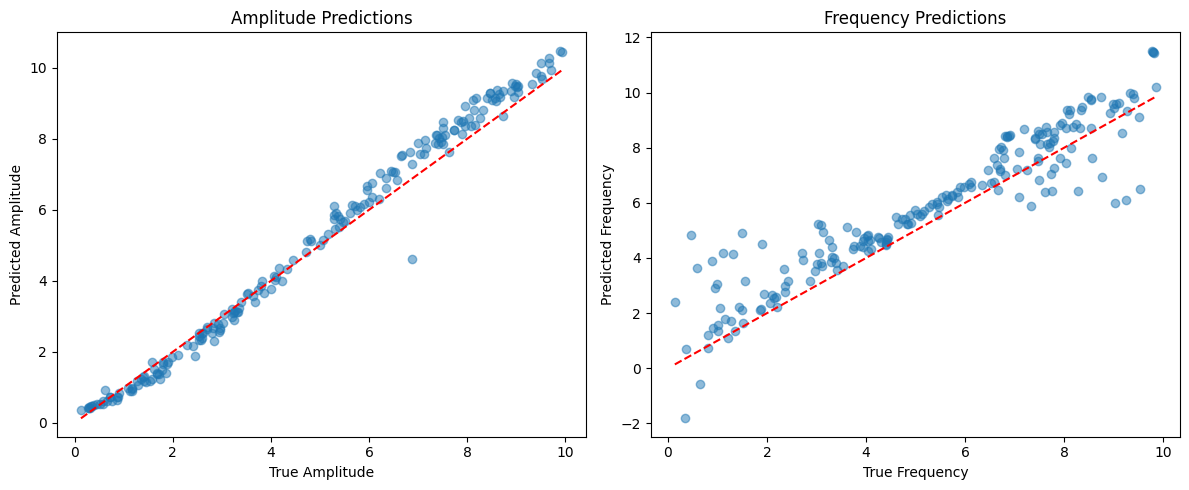

[I 2024-11-29 21:09:49,958] Trial 44 finished with values: [0.19535645842552185, 1.2591475248336792] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.0001871362658020414}.


Epoch [10/100], Train Loss: 0.0082, Val Loss: 0.0062, Time: 0.43s
Epoch [20/100], Train Loss: 0.0069, Val Loss: 0.0049, Time: 0.42s
Early stopping triggered
MSE - Amplitude: 0.0806, Frequency: 1.0258
MAE - Amplitude: 0.2230, Frequency: 0.6717


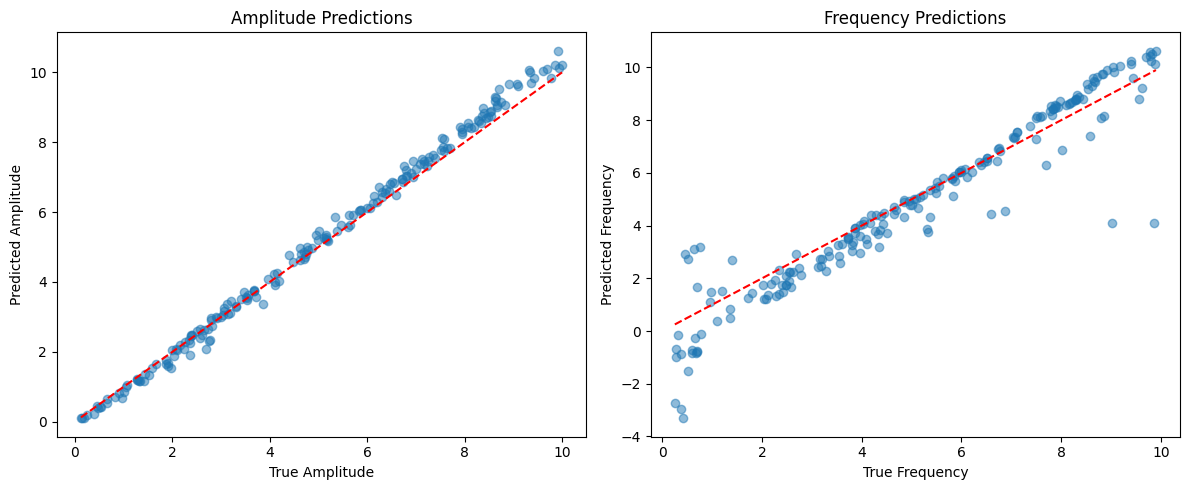

[I 2024-11-29 21:09:59,043] Trial 45 finished with values: [0.08056432008743286, 1.0258358716964722] and parameters: {'batch_size': 64, 'd_model': 256, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 512, 'dropout': 0.2, 'learning_rate': 0.0003344326509995286}.


Epoch [10/100], Train Loss: 0.0755, Val Loss: 0.0771, Time: 0.13s
Epoch [20/100], Train Loss: 0.0193, Val Loss: 0.0186, Time: 0.13s
Epoch [30/100], Train Loss: 0.0116, Val Loss: 0.0115, Time: 0.13s
Epoch [40/100], Train Loss: 0.0102, Val Loss: 0.0113, Time: 0.14s
Epoch [50/100], Train Loss: 0.0097, Val Loss: 0.0098, Time: 0.13s
Epoch [60/100], Train Loss: 0.0087, Val Loss: 0.0092, Time: 0.15s
Early stopping triggered
MSE - Amplitude: 0.3005, Frequency: 1.6348
MAE - Amplitude: 0.3508, Frequency: 0.9839


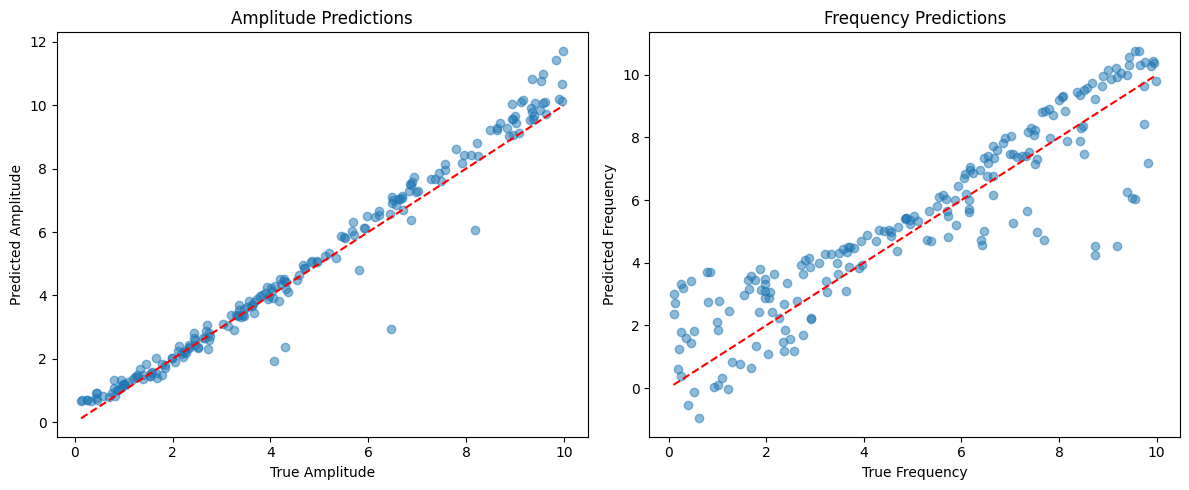

[I 2024-11-29 21:10:08,818] Trial 46 finished with values: [0.30054718255996704, 1.6347742080688477] and parameters: {'batch_size': 64, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.0001099093164757658}.


Epoch [10/100], Train Loss: 0.0082, Val Loss: 0.0104, Time: 0.34s
Epoch [20/100], Train Loss: 0.0038, Val Loss: 0.0043, Time: 0.36s
Early stopping triggered
MSE - Amplitude: 0.6056, Frequency: 0.6484
MAE - Amplitude: 0.6032, Frequency: 0.5370


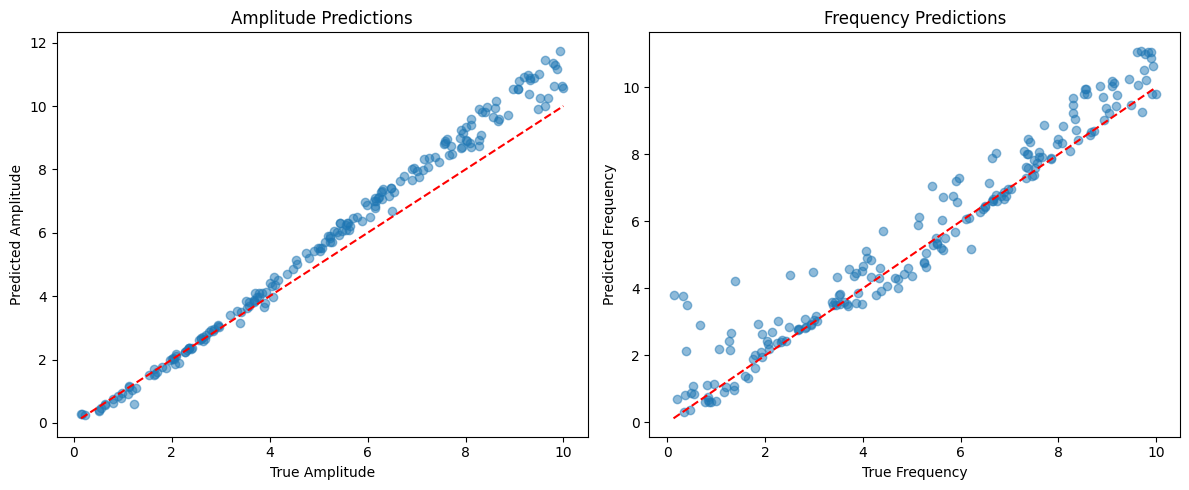

[I 2024-11-29 21:10:17,317] Trial 47 finished with values: [0.6055588722229004, 0.6484081745147705] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.0005376478686696385}.


Epoch [10/100], Train Loss: 0.0098, Val Loss: 0.0279, Time: 0.57s
Early stopping triggered
MSE - Amplitude: 2.1504, Frequency: 1.9834
MAE - Amplitude: 1.2753, Frequency: 1.0678


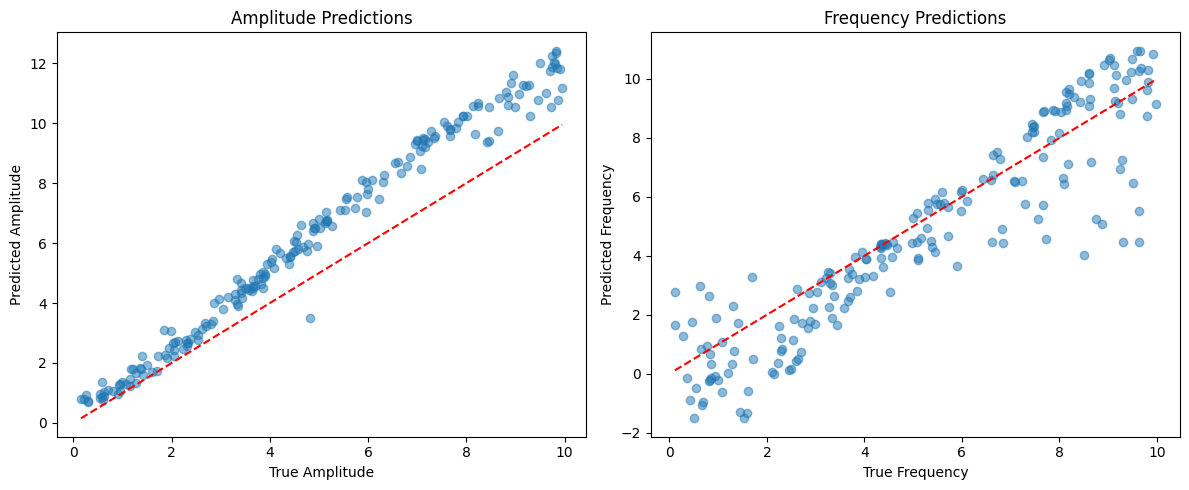

[I 2024-11-29 21:10:26,073] Trial 48 finished with values: [2.1503803730010986, 1.983443260192871] and parameters: {'batch_size': 16, 'd_model': 64, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.4, 'learning_rate': 0.00022795937048494734}.


Epoch [10/100], Train Loss: 0.0626, Val Loss: 0.0425, Time: 0.17s
Early stopping triggered
MSE - Amplitude: 1.2013, Frequency: 3.1392
MAE - Amplitude: 0.8376, Frequency: 1.4375


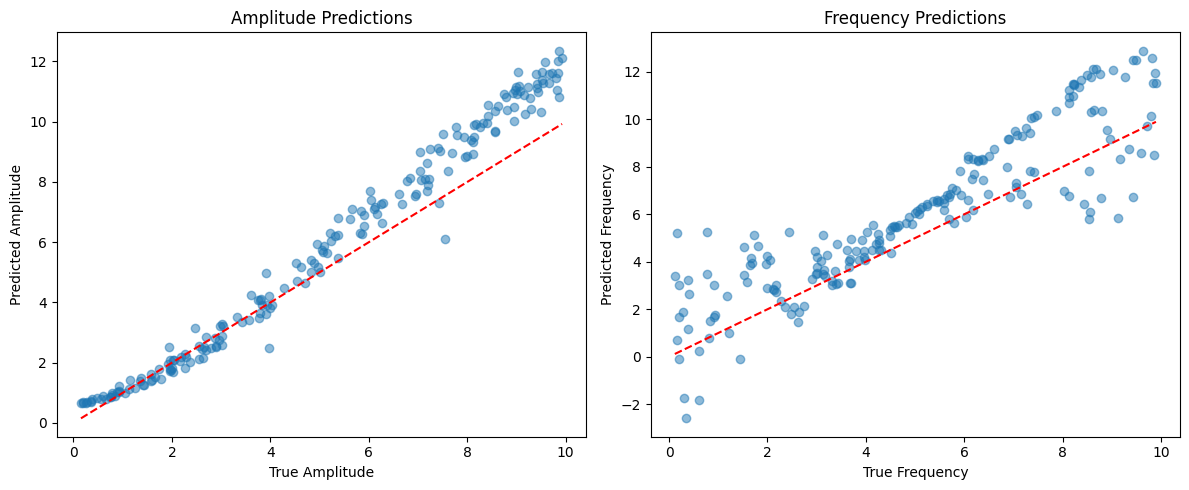

[I 2024-11-29 21:10:29,946] Trial 49 finished with values: [1.2013481855392456, 3.139160394668579] and parameters: {'batch_size': 32, 'd_model': 32, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4, 'learning_rate': 0.000465723142652115}.



--- Worst Performing Trials ---

Worst Trial 1:
 Amplitude MSE: 9.296603
 Frequency MSE: 7.907647
 Params:
  batch_size: 64
  d_model: 32
  nhead: 8
  num_layers: 4
  dim_feedforward: 512
  dropout: 0.4
  learning_rate: 0.00013795199559102163

Worst Trial 2:
 Amplitude MSE: 5.121347
 Frequency MSE: 2.643397
 Params:
  batch_size: 32
  d_model: 64
  nhead: 2
  num_layers: 4
  dim_feedforward: 128
  dropout: 0.4
  learning_rate: 0.00011417302187827856

Worst Trial 3:
 Amplitude MSE: 3.896438
 Frequency MSE: 2.781925
 Params:
  batch_size: 32
  d_model: 32
  nhead: 4
  num_layers: 2
  dim_feedforward: 512
  dropout: 0.4
  learning_rate: 0.0002564061734527641

Worst Trial 4:
 Amplitude MSE: 3.309694
 Frequency MSE: 1.357875
 Params:
  batch_size: 32
  d_model: 256
  nhead: 4
  num_layers: 2
  dim_feedforward: 256
  dropout: 0.4
  learning_rate: 0.00010109164180594765

Worst Trial 5:
 Amplitude MSE: 1.990922
 Frequency MSE: 2.382762
 Params:
  batch_size: 64
  d_model: 64
  nhead: 4
  num_

In [ ]:
best_params = optimize_hyperparameters(n_trials=50)

## Hyperparameter Optimization N=5000, second iteration
In this experiment, we evaluated the performance of a transformer model trained to predict amplitude and frequency from sine wave data, using hyperparameter optimization with Optuna. The results indicated that larger model dimensions (e.g.,
$𝑑_{model}$
=
128
−
256) and smaller numbers of attention heads (e.g., 2-4) yield the best performance, while maintaining an optimal dropout rate of 0.2-0.3 and smaller batch sizes (16-32). These configurations produced lower MSE values for both amplitude and frequency prediction.

For the next phase of our research, we will now experiment with a larger dataset of 10,000 samples to test if the model’s performance stabilizes further with more data, and to fine-tune hyperparameters for better generalization and accuracy on a larger scale.

In [ ]:
def objective(trial):
    """
    Objective function for Optuna - defines search space and evaluates model
    Tracks both best and worst performing hyperparameter configurations
    """
    # Define hyperparameter search space
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    d_model = trial.suggest_categorical('d_model', [128, 256])
    nhead = trial.suggest_categorical('nhead', [2, 4])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 4, 6])
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [128, 256])
    dropout = trial.suggest_categorical('dropout', [0.2, 0.3])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.0004, log=True)

    # Generate data
    sine_waves, labels = generate_sine_data(
        A_range=(0.1, 10),
        omega_range=(0.1, 10),
        t_points=100,
        N=5000
    )

    # Prepare data
    train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(
        sine_waves, labels,
        test_size=0.2,
        batch_size=batch_size
    )

    # Initialize model
    model = SineWaveTransformer(
        seq_len=100,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        epochs=100,
        optimizer=optimizer
    )

    # Evaluate model
    mse, mae = evaluate_model(model, val_loader, label_scaler)

    # Set user attributes for detailed tracking
    trial.set_user_attr('amplitude_mse', mse[0])
    trial.set_user_attr('frequency_mse', mse[1])

    return mse[0], mse[1]

def optimize_hyperparameters(n_trials=50):
    """
    Function to run hyperparameter optimization with Optuna
    Tracks and prints both best and worst trials
    """
    study = optuna.create_study(directions=["minimize", "minimize"])

    def callback(study, trial):
        if len(study.trials) == n_trials:
            # Track and print worst trials
            print("\n--- Worst Performing Trials ---")
            # Sort trials by total MSE (sum of amplitude and frequency MSE)
            worst_trials = sorted(study.trials, key=lambda t: sum(t.values) if t.values else float('inf'), reverse=True)

            for i, worst_trial in enumerate(worst_trials[:5], 1):
                print(f"\nWorst Trial {i}:")
                print(f" Amplitude MSE: {worst_trial.values[0] if worst_trial.values else 'N/A':.6f}")
                print(f" Frequency MSE: {worst_trial.values[1] if worst_trial.values else 'N/A':.6f}")
                print(" Params:")
                for key, value in worst_trial.params.items():
                    print(f"  {key}: {value}")

    # Run optimization
    study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    print("\n--- Optuna Hyperparameter Optimization Results ---")

    # Print best trials
    if study.best_trials:
        for i, best_trial in enumerate(study.best_trials[:5], 1):
            print(f"\nBest Trial {i}:")
            print(f" Amplitude MSE: {best_trial.values[0]:.6f}")
            print(f" Frequency MSE: {best_trial.values[1]:.6f}")
            print(" Params:")
            for key, value in best_trial.params.items():
                print(f"  {key}: {value}")
    else:
        print("No successful trials were completed.")

    return study.best_trials[0].params if study.best_trials else None

In [ ]:
best_params = optimize_hyperparameters(n_trials=50)

[I 2024-11-29 21:55:01,626] A new study created in memory with name: no-name-d16a6039-15c0-4bd8-8805-b6af3d23c20d


Epoch [10/100], Train Loss: 0.0033, Val Loss: 0.0070, Time: 1.72s
Epoch [20/100], Train Loss: 0.0019, Val Loss: 0.0029, Time: 2.13s


[I 2024-11-29 21:56:00,120] Trial 0 finished with values: [0.11429210007190704, 0.2693276107311249] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0001523693145655066}.


Epoch [30/100], Train Loss: 0.0015, Val Loss: 0.0020, Time: 1.71s
Early stopping triggered
MSE - Amplitude: 0.1143, Frequency: 0.2693
MAE - Amplitude: 0.2768, Frequency: 0.3197




[I 2024-11-29 21:56:17,717] Trial 1 finished with values: [0.6884222626686096, 2.208369493484497] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00014543586240258117}.


Early stopping triggered
MSE - Amplitude: 0.6884, Frequency: 2.2084
MAE - Amplitude: 0.6531, Frequency: 1.3079


Epoch [10/100], Train Loss: 0.0047, Val Loss: 0.0048, Time: 1.44s
Epoch [20/100], Train Loss: 0.0023, Val Loss: 0.0029, Time: 1.45s


[I 2024-11-29 21:56:52,873] Trial 2 finished with values: [0.22239738702774048, 0.47086307406425476] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.0001444505676249154}.


Early stopping triggered
MSE - Amplitude: 0.2224, Frequency: 0.4709
MAE - Amplitude: 0.3680, Frequency: 0.5621


Epoch [10/100], Train Loss: 0.0039, Val Loss: 0.0061, Time: 3.39s
Epoch [20/100], Train Loss: 0.0019, Val Loss: 0.0071, Time: 3.32s
Early stopping triggered


[I 2024-11-29 21:58:02,078] Trial 3 finished with values: [0.8459126353263855, 0.5518248081207275] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0001623793277069225}.


MSE - Amplitude: 0.8459, Frequency: 0.5518
MAE - Amplitude: 0.7835, Frequency: 0.5896


Epoch [10/100], Train Loss: 0.0058, Val Loss: 0.0062, Time: 0.60s
Epoch [20/100], Train Loss: 0.0029, Val Loss: 0.0035, Time: 0.71s
Epoch [30/100], Train Loss: 0.0025, Val Loss: 0.0027, Time: 0.57s


[I 2024-11-29 21:58:23,322] Trial 4 finished with values: [0.19423937797546387, 0.2502649128437042] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00012038892665168895}.


Early stopping triggered
MSE - Amplitude: 0.1942, Frequency: 0.2503
MAE - Amplitude: 0.3420, Frequency: 0.3650


Epoch [10/100], Train Loss: 0.0034, Val Loss: 0.0098, Time: 3.71s


[I 2024-11-29 21:59:17,562] Trial 5 finished with values: [0.23887094855308533, 0.6246269941329956] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00027560225373247547}.


Early stopping triggered
MSE - Amplitude: 0.2389, Frequency: 0.6246
MAE - Amplitude: 0.4096, Frequency: 0.5629


Epoch [10/100], Train Loss: 0.0035, Val Loss: 0.0045, Time: 4.26s
Epoch [20/100], Train Loss: 0.0025, Val Loss: 0.0034, Time: 3.99s
Epoch [30/100], Train Loss: 0.0019, Val Loss: 0.0021, Time: 5.20s
Early stopping triggered


[I 2024-11-29 22:01:38,244] Trial 6 finished with values: [0.09690146148204803, 0.08039271086454391] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00010455684348602149}.


MSE - Amplitude: 0.0969, Frequency: 0.0804
MAE - Amplitude: 0.2448, Frequency: 0.2150


Epoch [10/100], Train Loss: 0.0032, Val Loss: 0.0028, Time: 2.23s


[I 2024-11-29 22:02:02,524] Trial 7 finished with values: [0.10040981322526932, 0.633155107498169] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00028212450763726287}.


Early stopping triggered
MSE - Amplitude: 0.1004, Frequency: 0.6332
MAE - Amplitude: 0.2542, Frequency: 0.6130


Epoch [10/100], Train Loss: 0.0027, Val Loss: 0.0024, Time: 1.18s
Epoch [20/100], Train Loss: 0.0017, Val Loss: 0.0010, Time: 1.18s


[I 2024-11-29 22:02:33,123] Trial 8 finished with values: [0.054197609424591064, 0.13593263924121857] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00024351085762205703}.


Early stopping triggered
MSE - Amplitude: 0.0542, Frequency: 0.1359
MAE - Amplitude: 0.1866, Frequency: 0.2183


Epoch [10/100], Train Loss: 0.0028, Val Loss: 0.0017, Time: 1.12s
Epoch [20/100], Train Loss: 0.0019, Val Loss: 0.0024, Time: 1.10s


[I 2024-11-29 22:02:59,320] Trial 9 finished with values: [0.06630372256040573, 0.2152307629585266] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00036054524717076404}.


Early stopping triggered
MSE - Amplitude: 0.0663, Frequency: 0.2152
MAE - Amplitude: 0.1692, Frequency: 0.3538


Epoch [10/100], Train Loss: 0.0030, Val Loss: 0.0067, Time: 1.70s
Epoch [20/100], Train Loss: 0.0023, Val Loss: 0.0036, Time: 1.74s


[I 2024-11-29 22:03:38,047] Trial 10 finished with values: [0.24607665836811066, 0.375093936920166] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00015295568834091736}.


Early stopping triggered
MSE - Amplitude: 0.2461, Frequency: 0.3751
MAE - Amplitude: 0.4168, Frequency: 0.4023


Epoch [10/100], Train Loss: 0.0032, Val Loss: 0.0029, Time: 0.70s


[I 2024-11-29 22:03:52,947] Trial 11 finished with values: [0.11493372172117233, 0.26216286420822144] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00010218463870583896}.


Epoch [20/100], Train Loss: 0.0020, Val Loss: 0.0019, Time: 0.84s
Early stopping triggered
MSE - Amplitude: 0.1149, Frequency: 0.2622
MAE - Amplitude: 0.2619, Frequency: 0.2980


Epoch [10/100], Train Loss: 0.0034, Val Loss: 0.0024, Time: 2.86s


[I 2024-11-29 22:04:45,448] Trial 12 finished with values: [0.12154403328895569, 0.5285587310791016] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.0002031047585613466}.


Early stopping triggered
MSE - Amplitude: 0.1215, Frequency: 0.5286
MAE - Amplitude: 0.2542, Frequency: 0.5824


Epoch [10/100], Train Loss: 0.0033, Val Loss: 0.0049, Time: 1.73s


[I 2024-11-29 22:05:14,675] Trial 13 finished with values: [0.44847366213798523, 0.6651553511619568] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.0001005665102114964}.


Early stopping triggered
MSE - Amplitude: 0.4485, Frequency: 0.6652
MAE - Amplitude: 0.5462, Frequency: 0.6477


Epoch [10/100], Train Loss: 0.0035, Val Loss: 0.0064, Time: 2.91s
Epoch [20/100], Train Loss: 0.0025, Val Loss: 0.0077, Time: 2.91s


[I 2024-11-29 22:06:20,156] Trial 14 finished with values: [0.8068625330924988, 0.7202343344688416] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00022077318711610002}.


Early stopping triggered
MSE - Amplitude: 0.8069, Frequency: 0.7202
MAE - Amplitude: 0.7208, Frequency: 0.7418


Epoch [10/100], Train Loss: 0.0031, Val Loss: 0.0048, Time: 3.02s


[I 2024-11-29 22:07:15,351] Trial 15 finished with values: [0.1450674831867218, 0.27997854351997375] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.000324997830008894}.


Early stopping triggered
MSE - Amplitude: 0.1451, Frequency: 0.2800
MAE - Amplitude: 0.3046, Frequency: 0.4335


Epoch [10/100], Train Loss: 0.0027, Val Loss: 0.0043, Time: 5.26s
Early stopping triggered


[I 2024-11-29 22:08:25,834] Trial 16 finished with values: [0.45805278420448303, 0.12304535508155823] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0002664440653700742}.


MSE - Amplitude: 0.4581, Frequency: 0.1230
MAE - Amplitude: 0.5726, Frequency: 0.2427


Epoch [10/100], Train Loss: 0.0027, Val Loss: 0.0026, Time: 1.71s
Epoch [20/100], Train Loss: 0.0020, Val Loss: 0.0024, Time: 2.10s


[I 2024-11-29 22:09:09,147] Trial 17 finished with values: [0.0987144336104393, 0.3930249512195587] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00023888799533083093}.


Early stopping triggered
MSE - Amplitude: 0.0987, Frequency: 0.3930
MAE - Amplitude: 0.2394, Frequency: 0.4600


Epoch [10/100], Train Loss: 0.0024, Val Loss: 0.0027, Time: 2.14s
Epoch [20/100], Train Loss: 0.0020, Val Loss: 0.0018, Time: 1.68s


[I 2024-11-29 22:09:53,296] Trial 18 finished with values: [0.08355122059583664, 0.1366230845451355] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00020873463863131946}.


Early stopping triggered
MSE - Amplitude: 0.0836, Frequency: 0.1366
MAE - Amplitude: 0.2166, Frequency: 0.2451


Epoch [10/100], Train Loss: 0.0033, Val Loss: 0.0034, Time: 1.42s
Epoch [20/100], Train Loss: 0.0022, Val Loss: 0.0025, Time: 1.37s


[I 2024-11-29 22:10:26,879] Trial 19 finished with values: [0.05503834784030914, 0.38822275400161743] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00012759246460918508}.


Early stopping triggered
MSE - Amplitude: 0.0550, Frequency: 0.3882
MAE - Amplitude: 0.1532, Frequency: 0.3586


Epoch [10/100], Train Loss: 0.0036, Val Loss: 0.0049, Time: 3.39s
Early stopping triggered


[I 2024-11-29 22:11:18,145] Trial 20 finished with values: [0.37975504994392395, 1.5767713785171509] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00039822286476064395}.


MSE - Amplitude: 0.3798, Frequency: 1.5768
MAE - Amplitude: 0.4774, Frequency: 0.9680


Epoch [10/100], Train Loss: 0.0044, Val Loss: 0.0049, Time: 1.56s
Epoch [20/100], Train Loss: 0.0020, Val Loss: 0.0025, Time: 1.70s


[I 2024-11-29 22:11:56,824] Trial 21 finished with values: [0.1947527676820755, 0.29277220368385315] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00011441791462667717}.


Early stopping triggered
MSE - Amplitude: 0.1948, Frequency: 0.2928
MAE - Amplitude: 0.3568, Frequency: 0.3244


Epoch [10/100], Train Loss: 0.0024, Val Loss: 0.0033, Time: 2.47s


[I 2024-11-29 22:12:25,672] Trial 22 finished with values: [0.2732751667499542, 0.4070996642112732] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00033908922272404943}.


Early stopping triggered
MSE - Amplitude: 0.2733, Frequency: 0.4071
MAE - Amplitude: 0.4096, Frequency: 0.4968


Epoch [10/100], Train Loss: 0.0045, Val Loss: 0.0045, Time: 0.61s
Epoch [20/100], Train Loss: 0.0033, Val Loss: 0.0016, Time: 0.64s
Epoch [30/100], Train Loss: 0.0020, Val Loss: 0.0016, Time: 0.61s


[I 2024-11-29 22:12:49,484] Trial 23 finished with values: [0.06925652921199799, 0.5986554026603699] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.0002476027642372575}.


Early stopping triggered
MSE - Amplitude: 0.0693, Frequency: 0.5987
MAE - Amplitude: 0.1939, Frequency: 0.6923


Epoch [10/100], Train Loss: 0.0047, Val Loss: 0.0048, Time: 1.20s
Epoch [20/100], Train Loss: 0.0026, Val Loss: 0.0045, Time: 1.21s
Epoch [30/100], Train Loss: 0.0022, Val Loss: 0.0036, Time: 1.19s


[I 2024-11-29 22:13:34,760] Trial 24 finished with values: [0.16052483022212982, 0.2842473089694977] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00014231783780508847}.


Early stopping triggered
MSE - Amplitude: 0.1605, Frequency: 0.2842
MAE - Amplitude: 0.3184, Frequency: 0.3753


Epoch [10/100], Train Loss: 0.0023, Val Loss: 0.0033, Time: 1.81s


[I 2024-11-29 22:14:08,312] Trial 25 finished with values: [0.27750545740127563, 0.14190007746219635] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.0002933651566725944}.


Early stopping triggered
MSE - Amplitude: 0.2775, Frequency: 0.1419
MAE - Amplitude: 0.3871, Frequency: 0.2678


Epoch [10/100], Train Loss: 0.0027, Val Loss: 0.0103, Time: 2.52s


[I 2024-11-29 22:14:48,791] Trial 26 finished with values: [0.8649601936340332, 0.5695781707763672] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.0001717940685507027}.


Early stopping triggered
MSE - Amplitude: 0.8650, Frequency: 0.5696
MAE - Amplitude: 0.8483, Frequency: 0.5334


Epoch [10/100], Train Loss: 0.0023, Val Loss: 0.0022, Time: 2.17s
Early stopping triggered


[I 2024-11-29 22:15:22,148] Trial 27 finished with values: [0.10711142420768738, 0.3807649612426758] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00010635832558739503}.


MSE - Amplitude: 0.1071, Frequency: 0.3808
MAE - Amplitude: 0.2604, Frequency: 0.4088


Epoch [10/100], Train Loss: 0.0050, Val Loss: 0.0072, Time: 0.63s
Epoch [20/100], Train Loss: 0.0030, Val Loss: 0.0052, Time: 0.87s
Epoch [30/100], Train Loss: 0.0024, Val Loss: 0.0041, Time: 0.63s


[I 2024-11-29 22:15:46,607] Trial 28 finished with values: [0.30248692631721497, 0.456255704164505] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 1, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00011714143662018022}.


Early stopping triggered
MSE - Amplitude: 0.3025, Frequency: 0.4563
MAE - Amplitude: 0.4049, Frequency: 0.3810


Epoch [10/100], Train Loss: 0.0041, Val Loss: 0.0069, Time: 4.46s
Early stopping triggered


[I 2024-11-29 22:16:49,954] Trial 29 finished with values: [0.29229339957237244, 0.5051862001419067] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00033357202120555004}.


MSE - Amplitude: 0.2923, Frequency: 0.5052
MAE - Amplitude: 0.4397, Frequency: 0.5824


Epoch [10/100], Train Loss: 0.0031, Val Loss: 0.0023, Time: 0.78s
Epoch [20/100], Train Loss: 0.0017, Val Loss: 0.0016, Time: 0.62s


[I 2024-11-29 22:17:04,116] Trial 30 finished with values: [0.0802527591586113, 0.4099946618080139] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00038966842000894236}.


Early stopping triggered
MSE - Amplitude: 0.0803, Frequency: 0.4100
MAE - Amplitude: 0.2193, Frequency: 0.5633


Epoch [10/100], Train Loss: 0.0040, Val Loss: 0.0063, Time: 2.18s
Epoch [20/100], Train Loss: 0.0024, Val Loss: 0.0043, Time: 1.71s
Early stopping triggered
MSE - Amplitude: 0.4642, Frequency: 1.0721
MAE - Amplitude: 0.5797, Frequency: 0.7193




[I 2024-11-29 22:17:48,130] Trial 31 finished with values: [0.4642246663570404, 1.07211172580719] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0001387688527259075}.


Epoch [10/100], Train Loss: 0.0031, Val Loss: 0.0031, Time: 1.38s


[I 2024-11-29 22:18:10,616] Trial 32 finished with values: [0.35318025946617126, 0.5589252710342407] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00018942811576203738}.


Early stopping triggered
MSE - Amplitude: 0.3532, Frequency: 0.5589
MAE - Amplitude: 0.5469, Frequency: 0.6345


Epoch [10/100], Train Loss: 0.0045, Val Loss: 0.0083, Time: 2.18s


[I 2024-11-29 22:18:58,503] Trial 33 finished with values: [0.5255118012428284, 0.9211145043373108] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00014104328688540273}.


Epoch [20/100], Train Loss: 0.0021, Val Loss: 0.0074, Time: 2.22s
Early stopping triggered
MSE - Amplitude: 0.5255, Frequency: 0.9211
MAE - Amplitude: 0.6211, Frequency: 0.7526


Epoch [10/100], Train Loss: 0.0032, Val Loss: 0.0022, Time: 0.79s
Epoch [20/100], Train Loss: 0.0017, Val Loss: 0.0013, Time: 0.75s


[I 2024-11-29 22:19:20,023] Trial 34 finished with values: [0.034967511892318726, 0.20294657349586487] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00020165152892540704}.


Early stopping triggered
MSE - Amplitude: 0.0350, Frequency: 0.2029
MAE - Amplitude: 0.1149, Frequency: 0.3130


Epoch [10/100], Train Loss: 0.0024, Val Loss: 0.0013, Time: 1.21s


[I 2024-11-29 22:19:37,684] Trial 35 finished with values: [0.06400544941425323, 0.304311603307724] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00025405698505123455}.


Early stopping triggered
MSE - Amplitude: 0.0640, Frequency: 0.3043
MAE - Amplitude: 0.2074, Frequency: 0.4453


Epoch [10/100], Train Loss: 0.0038, Val Loss: 0.0035, Time: 2.31s


[I 2024-11-29 22:20:06,694] Trial 36 finished with values: [0.17799635231494904, 0.547458291053772] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00011042919301985484}.


Early stopping triggered
MSE - Amplitude: 0.1780, Frequency: 0.5475
MAE - Amplitude: 0.3493, Frequency: 0.5221


Epoch [10/100], Train Loss: 0.0023, Val Loss: 0.0064, Time: 1.73s


[I 2024-11-29 22:20:32,758] Trial 37 finished with values: [0.34104418754577637, 1.121687650680542] and parameters: {'batch_size': 16, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00020573540313189513}.


Early stopping triggered
MSE - Amplitude: 0.3410, Frequency: 1.1217
MAE - Amplitude: 0.4628, Frequency: 0.9551


Epoch [10/100], Train Loss: 0.0024, Val Loss: 0.0056, Time: 4.82s
Early stopping triggered


[I 2024-11-29 22:21:16,464] Trial 38 finished with values: [0.3732353448867798, 0.736507773399353] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00029471262932280137}.


MSE - Amplitude: 0.3732, Frequency: 0.7365
MAE - Amplitude: 0.5089, Frequency: 0.6186


Epoch [10/100], Train Loss: 0.0037, Val Loss: 0.0031, Time: 4.01s
Early stopping triggered


[I 2024-11-29 22:22:05,127] Trial 39 finished with values: [0.1211913526058197, 2.201443910598755] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 6, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00024676028763802327}.


MSE - Amplitude: 0.1212, Frequency: 2.2014
MAE - Amplitude: 0.2898, Frequency: 1.2140


Epoch [10/100], Train Loss: 0.0030, Val Loss: 0.0035, Time: 1.39s
Epoch [20/100], Train Loss: 0.0017, Val Loss: 0.0027, Time: 1.11s


[I 2024-11-29 22:22:31,029] Trial 40 finished with values: [0.3323385715484619, 0.768901526927948] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.0003351831550719699}.


Early stopping triggered
MSE - Amplitude: 0.3323, Frequency: 0.7689
MAE - Amplitude: 0.4612, Frequency: 0.7012


Epoch [10/100], Train Loss: 0.0037, Val Loss: 0.0047, Time: 1.44s
Epoch [20/100], Train Loss: 0.0027, Val Loss: 0.0042, Time: 1.43s


[I 2024-11-29 22:23:11,169] Trial 41 finished with values: [0.11315277218818665, 0.4491475224494934] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00015138825854665947}.


Early stopping triggered
MSE - Amplitude: 0.1132, Frequency: 0.4491
MAE - Amplitude: 0.2177, Frequency: 0.4964


Epoch [10/100], Train Loss: 0.0033, Val Loss: 0.0029, Time: 1.18s
Epoch [20/100], Train Loss: 0.0020, Val Loss: 0.0018, Time: 1.30s
Epoch [30/100], Train Loss: 0.0017, Val Loss: 0.0025, Time: 1.32s


[I 2024-11-29 22:23:51,114] Trial 42 finished with values: [0.17826581001281738, 0.6868720054626465] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00011226782766472807}.


Early stopping triggered
MSE - Amplitude: 0.1783, Frequency: 0.6869
MAE - Amplitude: 0.3783, Frequency: 0.5207


Epoch [10/100], Train Loss: 0.0028, Val Loss: 0.0033, Time: 0.58s
Epoch [20/100], Train Loss: 0.0017, Val Loss: 0.0016, Time: 0.59s


[I 2024-11-29 22:24:10,295] Trial 43 finished with values: [0.034152403473854065, 0.3425180912017822] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 4, 'num_layers': 1, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00033149506132522366}.


Epoch [30/100], Train Loss: 0.0014, Val Loss: 0.0019, Time: 0.59s
Early stopping triggered
MSE - Amplitude: 0.0342, Frequency: 0.3425
MAE - Amplitude: 0.1391, Frequency: 0.3880


Epoch [10/100], Train Loss: 0.0030, Val Loss: 0.0042, Time: 3.81s
Early stopping triggered


[I 2024-11-29 22:25:15,480] Trial 44 finished with values: [0.2167125791311264, 0.21754054725170135] and parameters: {'batch_size': 32, 'd_model': 256, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00016707413301030353}.


MSE - Amplitude: 0.2167, Frequency: 0.2175
MAE - Amplitude: 0.3867, Frequency: 0.2841


Epoch [10/100], Train Loss: 0.0044, Val Loss: 0.0050, Time: 1.58s
Epoch [20/100], Train Loss: 0.0023, Val Loss: 0.0049, Time: 1.76s


[I 2024-11-29 22:25:48,377] Trial 45 finished with values: [0.2669992744922638, 0.30453380942344666] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00018645199113714127}.


Early stopping triggered
MSE - Amplitude: 0.2670, Frequency: 0.3045
MAE - Amplitude: 0.4200, Frequency: 0.3530


Epoch [10/100], Train Loss: 0.0037, Val Loss: 0.0039, Time: 2.47s


[I 2024-11-29 22:26:32,472] Trial 46 finished with values: [0.1828199177980423, 0.301933228969574] and parameters: {'batch_size': 32, 'd_model': 128, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 128, 'dropout': 0.2, 'learning_rate': 0.00018979183446186693}.


Epoch [20/100], Train Loss: 0.0017, Val Loss: 0.0025, Time: 2.05s
Early stopping triggered
MSE - Amplitude: 0.1828, Frequency: 0.3019
MAE - Amplitude: 0.3341, Frequency: 0.3886


Epoch [10/100], Train Loss: 0.0030, Val Loss: 0.0045, Time: 2.03s


[I 2024-11-29 22:26:59,081] Trial 47 finished with values: [0.11943146586418152, 0.33467066287994385] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.3, 'learning_rate': 0.00017436379076200603}.


Early stopping triggered
MSE - Amplitude: 0.1194, Frequency: 0.3347
MAE - Amplitude: 0.2909, Frequency: 0.4688


Epoch [10/100], Train Loss: 0.0026, Val Loss: 0.0034, Time: 2.02s


[I 2024-11-29 22:27:22,849] Trial 48 finished with values: [0.1250912994146347, 0.3685823976993561] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.2, 'learning_rate': 0.00017351802372210488}.


Early stopping triggered
MSE - Amplitude: 0.1251, Frequency: 0.3686
MAE - Amplitude: 0.2884, Frequency: 0.4051


Epoch [10/100], Train Loss: 0.0034, Val Loss: 0.0075, Time: 2.04s


[I 2024-11-29 22:27:59,242] Trial 49 finished with values: [0.2744431495666504, 0.6585392951965332] and parameters: {'batch_size': 16, 'd_model': 128, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.3, 'learning_rate': 0.00015872319221856858}.


Epoch [20/100], Train Loss: 0.0019, Val Loss: 0.0050, Time: 1.70s
Early stopping triggered
MSE - Amplitude: 0.2744, Frequency: 0.6585
MAE - Amplitude: 0.4261, Frequency: 0.6723



--- Worst Performing Trials ---

Worst Trial 1:
 Amplitude MSE: 0.688422
 Frequency MSE: 2.208369
 Params:
  batch_size: 32
  d_model: 128
  nhead: 2
  num_layers: 6
  dim_feedforward: 128
  dropout: 0.3
  learning_rate: 0.00014543586240258117

Worst Trial 2:
 Amplitude MSE: 0.121191
 Frequency MSE: 2.201444
 Params:
  batch_size: 16
  d_model: 128
  nhead: 2
  num_layers: 6
  dim_feedforward: 256
  dropout: 0.2
  learning_rate: 0.00024676028763802327

Worst Trial 3:
 Amplitude MSE: 0.379755
 Frequency MSE: 1.576771
 Params:
  batch_size: 32
  d_model: 256
  nhead: 2
  num_layers: 6
  dim_feedforward: 128
  dropout: 0.3
  learning_rate: 0.00039822286476064395

Worst Trial 4:
 Amplitude MSE: 0.464225
 Frequency MSE: 1.072112
 Params:
  batch_size: 16
  d_model: 128
  nhead: 2
  num_layers: 2
  dim_feedforward:

### Let's take a closer look at the model with the best parameters

Epoch [10/100], Train Loss: 0.0115, Val Loss: 0.0195, Time: 0.71s
Epoch [20/100], Train Loss: 0.0077, Val Loss: 0.0084, Time: 0.53s
Epoch [30/100], Train Loss: 0.0056, Val Loss: 0.0063, Time: 0.58s
Epoch [40/100], Train Loss: 0.0049, Val Loss: 0.0121, Time: 0.54s
Epoch [50/100], Train Loss: 0.0039, Val Loss: 0.0041, Time: 0.55s
Epoch [60/100], Train Loss: 0.0040, Val Loss: 0.0033, Time: 0.52s
Epoch [70/100], Train Loss: 0.0030, Val Loss: 0.0026, Time: 0.55s
Epoch [80/100], Train Loss: 0.0029, Val Loss: 0.0030, Time: 0.54s
Epoch [90/100], Train Loss: 0.0024, Val Loss: 0.0020, Time: 0.55s
Epoch [100/100], Train Loss: 0.0027, Val Loss: 0.0017, Time: 0.79s
MSE - Amplitude: 0.1097, Frequency: 0.2335
MAE - Amplitude: 0.2227, Frequency: 0.2769




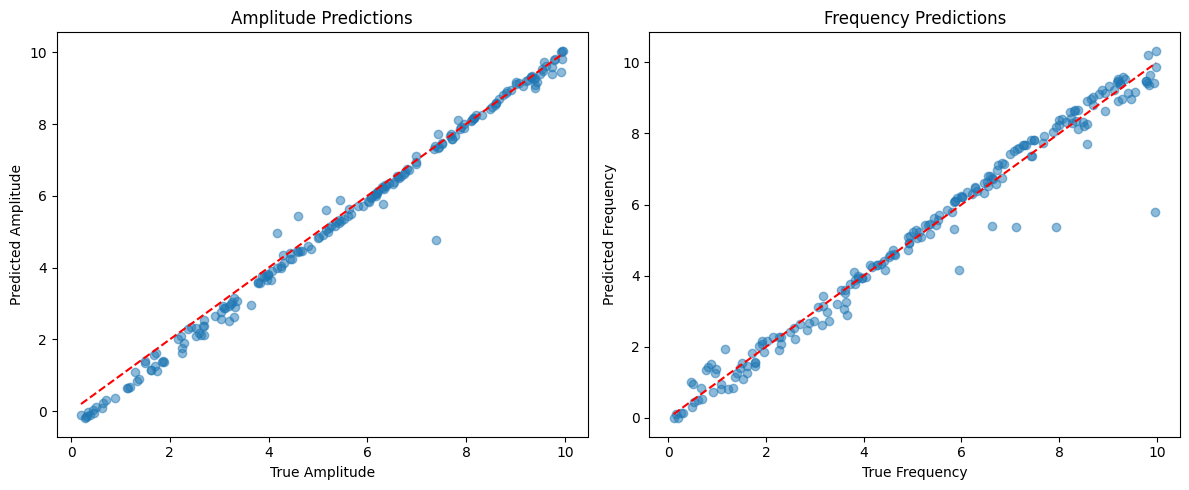

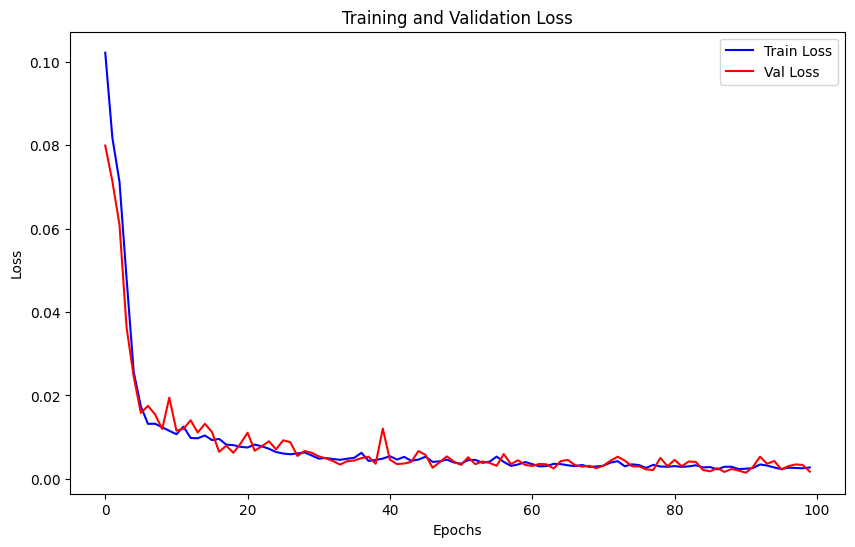

In [ ]:
sine_waves, labels = generate_sine_data(A_range=(0.1, 10), omega_range=(0.1, 10), t_points=100, N=1000)

# Prepare data
train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(sine_waves, labels, test_size=0.2, batch_size=16)

# Initialize model
best_model = SineWaveTransformer(seq_len=100, d_model=128, nhead=4, num_layers=4, dim_feedforward=256, dropout=0.2)

optimizer = optim.Adam(best_model.parameters(), lr=0.0001, weight_decay=1e-4)

train_losses, val_losses = train_model(best_model, train_loader, val_loader, epochs=100, optimizer=optimizer)

# Evaluate model
mse, mae = evaluate_model(best_model, val_loader, scalers[1], device=device)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Activation function tuning

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512,
                 dropout=0.1, activation='relu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = self._get_activation(activation)

    def _get_activation(self, activation):
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'tanh': nn.Tanh(),
            'elu': nn.ELU()
        }
        return activations.get(activation, nn.ReLU())

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

class SineWaveTransformer(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=512, dropout=0.1, activation='relu'):
        super().__init__()

        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))

        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, nhead, dim_feedforward,
                                    dropout, activation)
            for _ in range(num_layers)
        ])

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)  # Output for A and w

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        x = self.embedding(x)
        x = x + self.pos_encoding

        x = x.transpose(0, 1)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
import pandas as pd
import logging
from datetime import datetime

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

def compare_activation_functions(best_hyperparams):
    # List of activation functions to compare
    activation_functions = [
        'relu',
        'leaky_relu',
        'gelu',
        'silu',
        'tanh',
        'elu'
    ]

    # List to store the results
    results_list = []

    # Generate data
    sine_waves, labels = generate_sine_data(A_range=(0.1, 10), omega_range=(0.1, 10), t_points=100, N=1000)

    # Loop through activation functions
    for activation in activation_functions:
        logging.info(f"Testing activation function: {activation}")

        # Create the model with the current activation function
        model = SineWaveTransformer(
            seq_len=100,
            d_model=best_hyperparams['d_model'],
            nhead=best_hyperparams['nhead'],
            num_layers=best_hyperparams['num_layers'],
            dim_feedforward=best_hyperparams['dim_feedforward'],
            dropout=best_hyperparams['dropout'],
            activation=activation
        )

        # Prepare data
        train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(
            sine_waves, labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Optimizer with the best parameters
        optimizer = optim.Adam(
            model.parameters(),
            lr=best_hyperparams['learning_rate']
        )

        # Train the model
        train_losses, val_losses = train_model(
            model, train_loader, val_loader,
            epochs=100,
            optimizer=optimizer
        )

        # Evaluate the model
        mse, mae = evaluate_model(model, val_loader, label_scaler)

        # Prepare results for the current activation function
        result_entry = {
            'Activation Function': activation,
            'Amplitude MSE': mse[0],
            'Frequency MSE': mse[1],
            'Total MSE': mse[0] + mse[1],
            'Amplitude MAE': mae[0],
            'Frequency MAE': mae[1],
            'Final Train Loss': train_losses[-1],
            'Final Val Loss': val_losses[-1]
        }

        results_list.append(result_entry)

        logging.info(f"Results for {activation}:")
        logging.info(f"Amplitude MSE: {mse[0]:.4f}")
        logging.info(f"Frequency MSE: {mse[1]:.4f}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'activation_functions_results_{timestamp}.csv'
    results_df.to_csv(filename, index=False)

    logging.info(f"Results saved to file: {filename}")

    return results_df

def visualize_activation_comparison(results_df):
    plt.figure(figsize=(15, 10))

    # Plot for Total MSE
    plt.subplot(2, 2, 1)
    plt.bar(results_df['Activation Function'], results_df['Total MSE'])
    plt.title('Total MSE by Activation Functions')
    plt.ylabel('Total Mean Squared Error')
    plt.xticks(rotation=45)

    # Plot for Amplitude MSE
    plt.subplot(2, 2, 2)
    plt.bar(results_df['Activation Function'], results_df['Amplitude MSE'])
    plt.title('Amplitude MSE')
    plt.ylabel('Amplitude MSE')
    plt.xticks(rotation=45)

    # Plot for Frequency MSE
    plt.subplot(2, 2, 3)
    plt.bar(results_df['Activation Function'], results_df['Frequency MSE'])
    plt.title('Frequency MSE')
    plt.ylabel('Frequency MSE')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print out the results table
    print("\nFull results:\n", results_df)

    # Find the best activation function
    best_activation = results_df.loc[results_df['Total MSE'].idxmin(), 'Activation Function']
    logging.info(f"Best activation function: {best_activation}")


Epoch [10/100], Train Loss: 0.0123, Val Loss: 0.0112, Time: 0.57s
Epoch [20/100], Train Loss: 0.0071, Val Loss: 0.0062, Time: 0.56s
Epoch [30/100], Train Loss: 0.0060, Val Loss: 0.0063, Time: 0.58s
Epoch [40/100], Train Loss: 0.0052, Val Loss: 0.0059, Time: 0.57s
Epoch [50/100], Train Loss: 0.0043, Val Loss: 0.0048, Time: 0.58s
Epoch [60/100], Train Loss: 0.0034, Val Loss: 0.0042, Time: 0.56s
Epoch [70/100], Train Loss: 0.0028, Val Loss: 0.0063, Time: 0.57s
Epoch [80/100], Train Loss: 0.0028, Val Loss: 0.0022, Time: 0.56s
Epoch [90/100], Train Loss: 0.0019, Val Loss: 0.0030, Time: 0.57s
Epoch [100/100], Train Loss: 0.0019, Val Loss: 0.0021, Time: 0.57s
MSE - Amplitude: 0.1585, Frequency: 0.2559
MAE - Amplitude: 0.3270, Frequency: 0.3454




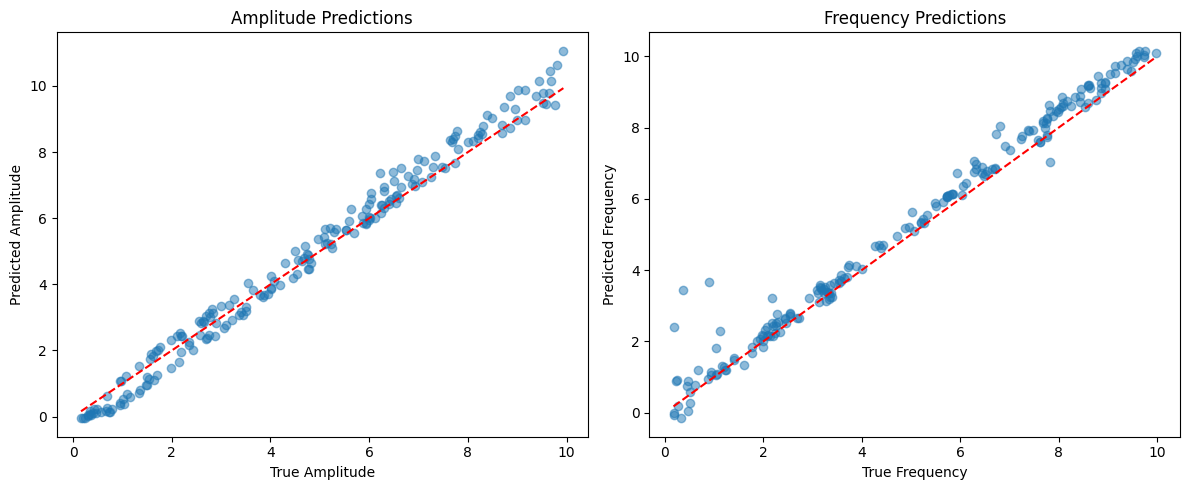

Epoch [10/100], Train Loss: 0.0104, Val Loss: 0.0088, Time: 0.59s
Epoch [20/100], Train Loss: 0.0075, Val Loss: 0.0089, Time: 0.56s
Epoch [30/100], Train Loss: 0.0050, Val Loss: 0.0048, Time: 0.59s
Epoch [40/100], Train Loss: 0.0042, Val Loss: 0.0049, Time: 0.57s
Epoch [50/100], Train Loss: 0.0036, Val Loss: 0.0037, Time: 0.87s
Epoch [60/100], Train Loss: 0.0036, Val Loss: 0.0088, Time: 0.56s
Epoch [70/100], Train Loss: 0.0030, Val Loss: 0.0033, Time: 0.81s
Epoch [80/100], Train Loss: 0.0025, Val Loss: 0.0038, Time: 0.56s
Epoch [90/100], Train Loss: 0.0020, Val Loss: 0.0022, Time: 0.57s
Epoch [100/100], Train Loss: 0.0016, Val Loss: 0.0036, Time: 0.58s
MSE - Amplitude: 0.2379, Frequency: 0.4872
MAE - Amplitude: 0.4153, Frequency: 0.4195




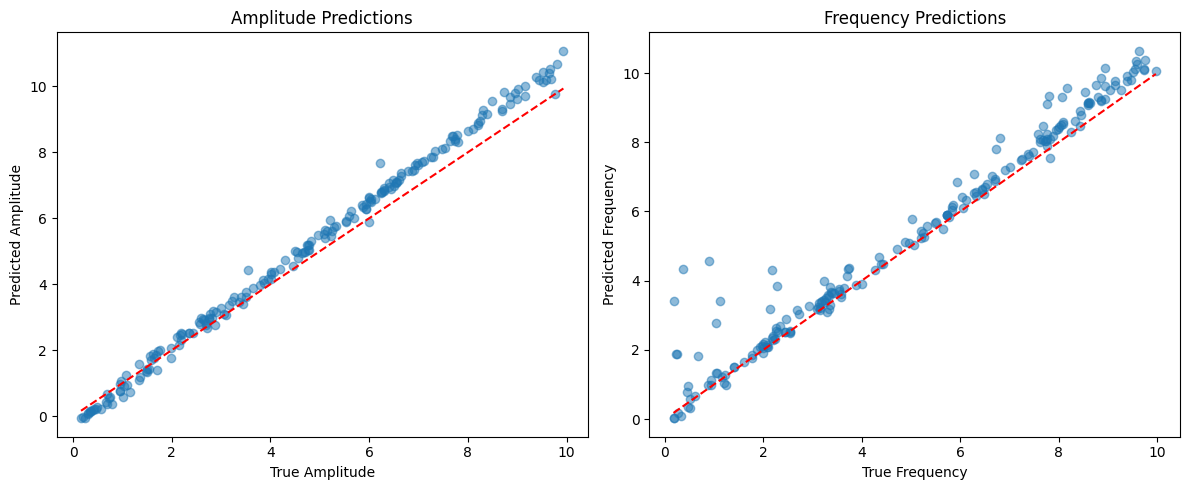

Epoch [10/100], Train Loss: 0.0103, Val Loss: 0.0104, Time: 0.57s
Epoch [20/100], Train Loss: 0.0064, Val Loss: 0.0057, Time: 0.59s
Epoch [30/100], Train Loss: 0.0050, Val Loss: 0.0066, Time: 0.56s
Epoch [40/100], Train Loss: 0.0038, Val Loss: 0.0038, Time: 0.56s
Epoch [50/100], Train Loss: 0.0039, Val Loss: 0.0037, Time: 0.59s
Epoch [60/100], Train Loss: 0.0030, Val Loss: 0.0028, Time: 0.57s
Epoch [70/100], Train Loss: 0.0027, Val Loss: 0.0020, Time: 0.57s
Epoch [80/100], Train Loss: 0.0022, Val Loss: 0.0020, Time: 0.56s
Epoch [90/100], Train Loss: 0.0016, Val Loss: 0.0018, Time: 0.56s
Epoch [100/100], Train Loss: 0.0023, Val Loss: 0.0028, Time: 0.56s
MSE - Amplitude: 0.1206, Frequency: 0.4375
MAE - Amplitude: 0.2575, Frequency: 0.5768




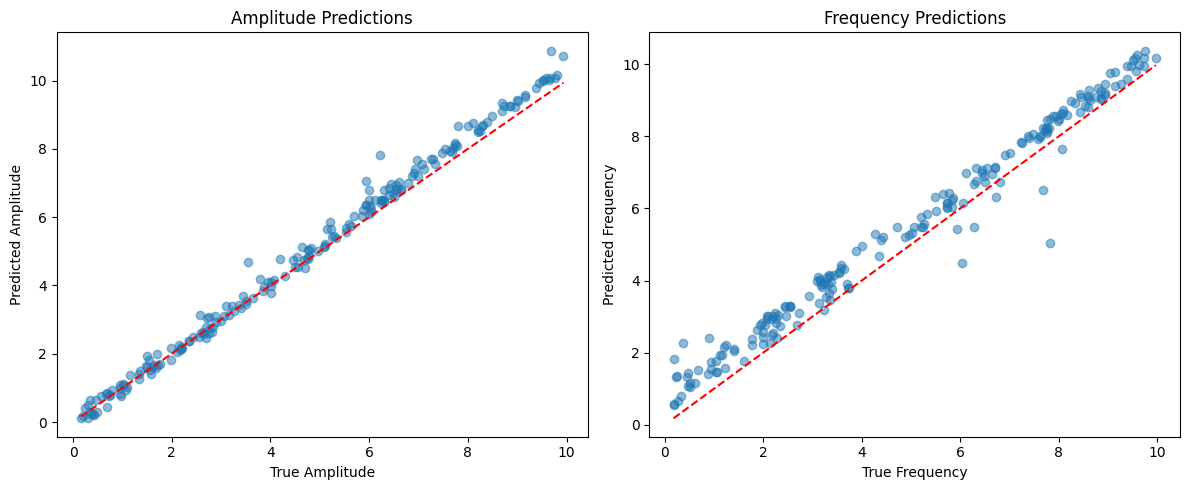

Epoch [10/100], Train Loss: 0.0109, Val Loss: 0.0101, Time: 0.56s
Epoch [20/100], Train Loss: 0.0095, Val Loss: 0.0139, Time: 0.59s
Epoch [30/100], Train Loss: 0.0068, Val Loss: 0.0080, Time: 0.58s
Epoch [40/100], Train Loss: 0.0045, Val Loss: 0.0058, Time: 0.58s
Epoch [50/100], Train Loss: 0.0036, Val Loss: 0.0043, Time: 0.57s
Epoch [60/100], Train Loss: 0.0034, Val Loss: 0.0068, Time: 0.57s
Epoch [70/100], Train Loss: 0.0025, Val Loss: 0.0040, Time: 0.57s
Epoch [80/100], Train Loss: 0.0024, Val Loss: 0.0090, Time: 0.58s
Epoch [90/100], Train Loss: 0.0022, Val Loss: 0.0030, Time: 0.56s
Epoch [100/100], Train Loss: 0.0023, Val Loss: 0.0010, Time: 0.86s
MSE - Amplitude: 0.0435, Frequency: 0.1476
MAE - Amplitude: 0.1638, Frequency: 0.2547




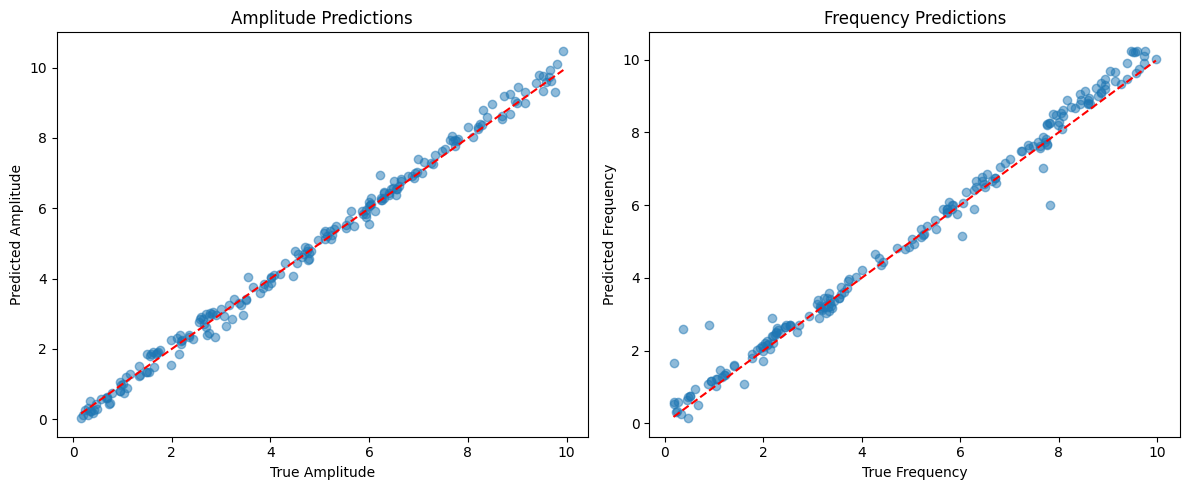

Epoch [10/100], Train Loss: 0.0099, Val Loss: 0.0149, Time: 0.56s
Epoch [20/100], Train Loss: 0.0065, Val Loss: 0.0083, Time: 0.57s
Epoch [30/100], Train Loss: 0.0055, Val Loss: 0.0062, Time: 0.56s
Epoch [40/100], Train Loss: 0.0048, Val Loss: 0.0054, Time: 0.76s
Epoch [50/100], Train Loss: 0.0035, Val Loss: 0.0054, Time: 0.58s
Epoch [60/100], Train Loss: 0.0032, Val Loss: 0.0047, Time: 0.88s
Epoch [70/100], Train Loss: 0.0031, Val Loss: 0.0043, Time: 0.55s
Epoch [80/100], Train Loss: 0.0029, Val Loss: 0.0022, Time: 0.83s
Epoch [90/100], Train Loss: 0.0027, Val Loss: 0.0028, Time: 0.55s
Epoch [100/100], Train Loss: 0.0023, Val Loss: 0.0037, Time: 0.73s
MSE - Amplitude: 0.3089, Frequency: 0.4274
MAE - Amplitude: 0.4852, Frequency: 0.4569




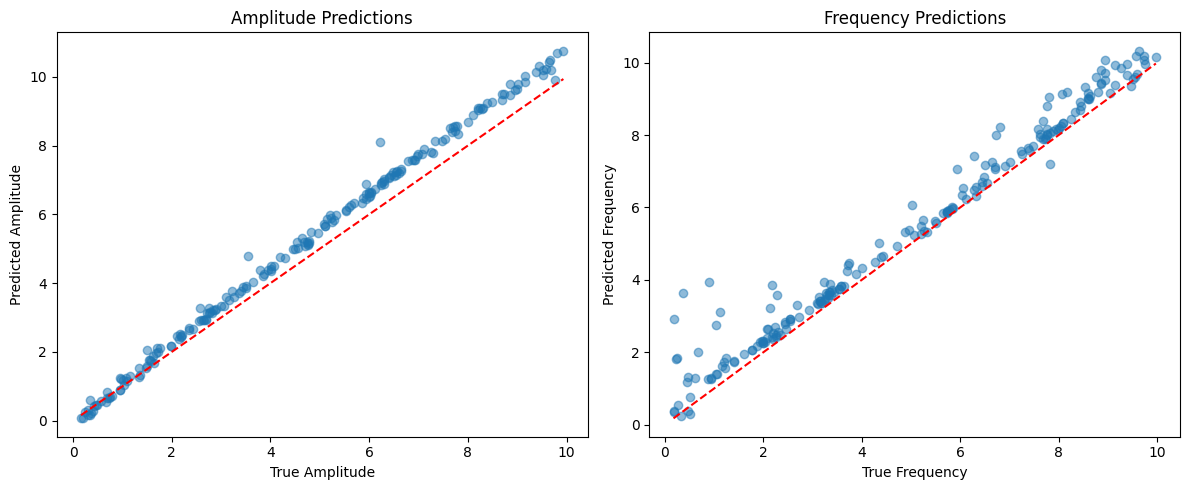

Epoch [10/100], Train Loss: 0.0104, Val Loss: 0.0161, Time: 0.60s
Epoch [20/100], Train Loss: 0.0071, Val Loss: 0.0108, Time: 0.73s
Epoch [30/100], Train Loss: 0.0053, Val Loss: 0.0088, Time: 0.57s
Epoch [40/100], Train Loss: 0.0051, Val Loss: 0.0083, Time: 0.81s
Epoch [50/100], Train Loss: 0.0030, Val Loss: 0.0043, Time: 0.59s
Epoch [60/100], Train Loss: 0.0036, Val Loss: 0.0031, Time: 0.62s
Epoch [70/100], Train Loss: 0.0038, Val Loss: 0.0028, Time: 0.57s
Epoch [80/100], Train Loss: 0.0019, Val Loss: 0.0022, Time: 0.57s
Epoch [90/100], Train Loss: 0.0016, Val Loss: 0.0069, Time: 0.58s
Epoch [100/100], Train Loss: 0.0016, Val Loss: 0.0028, Time: 0.63s
MSE - Amplitude: 0.1576, Frequency: 0.3924
MAE - Amplitude: 0.3280, Frequency: 0.5225




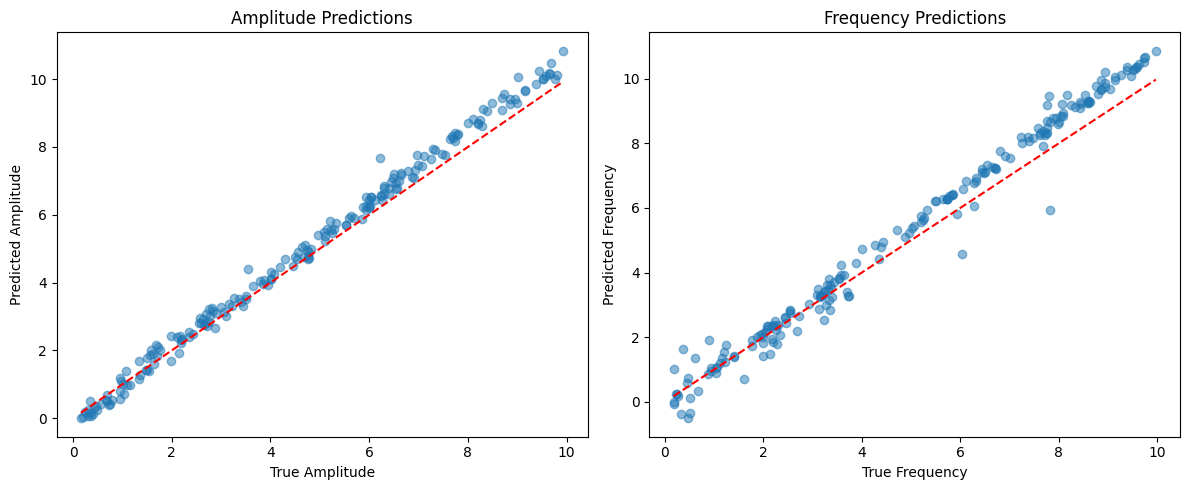

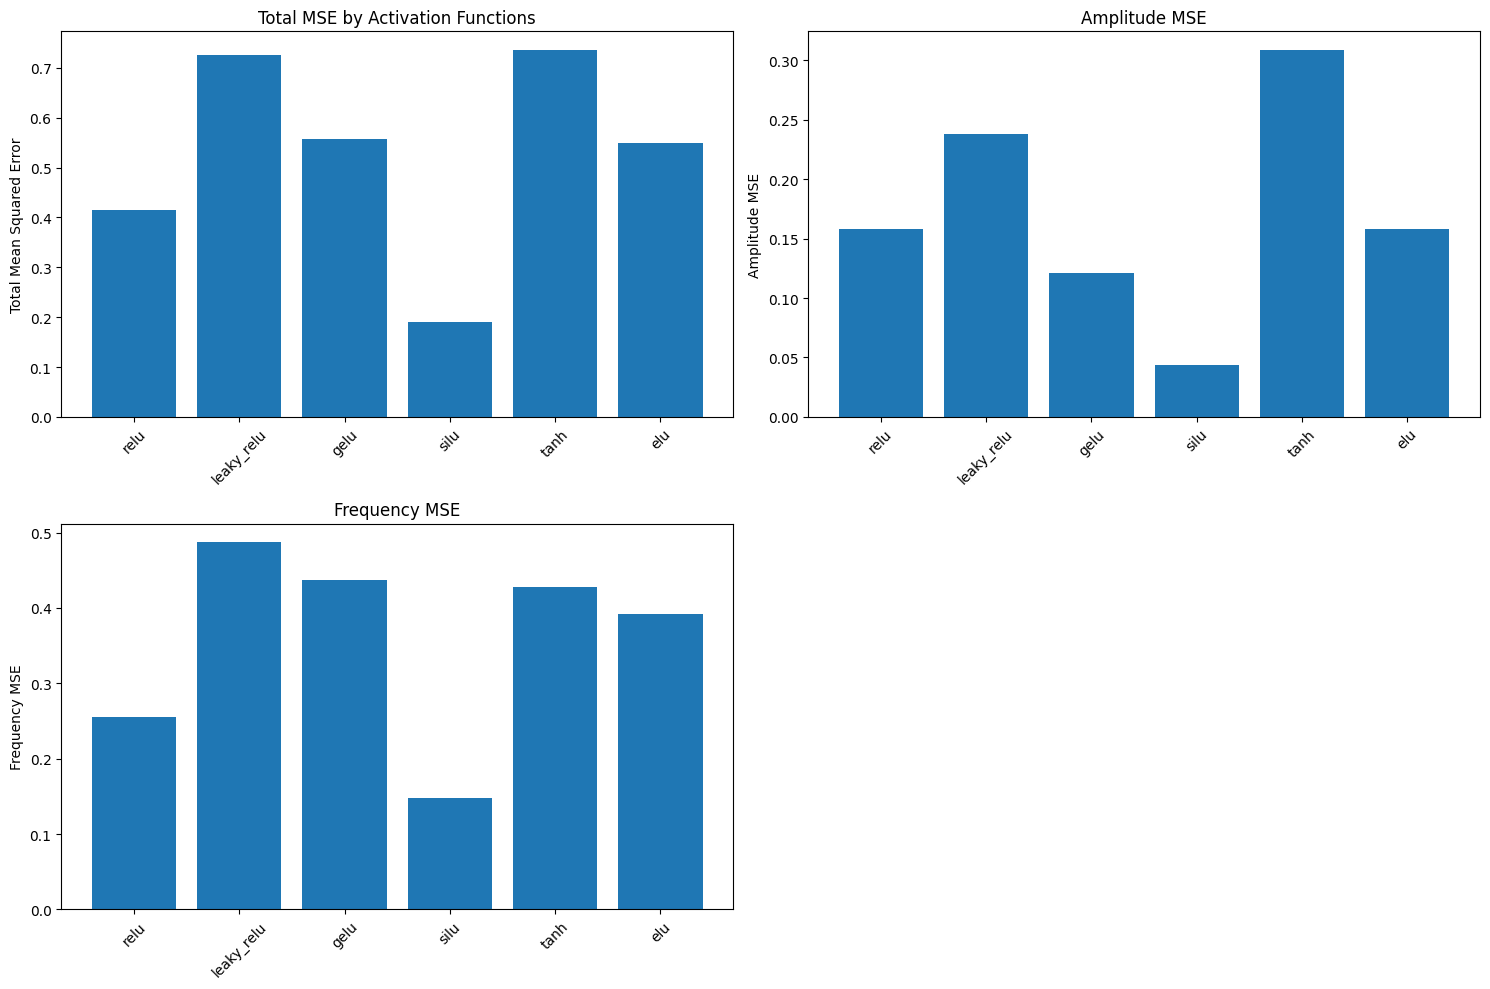


Full results:
   Activation Function  Amplitude MSE  Frequency MSE  Total MSE  Amplitude MAE  \
0                relu       0.158452       0.255883   0.414335       0.327034   
1          leaky_relu       0.237921       0.487192   0.725113       0.415252   
2                gelu       0.120631       0.437550   0.558181       0.257524   
3                silu       0.043539       0.147587   0.191126       0.163827   
4                tanh       0.308856       0.427381   0.736237       0.485203   
5                 elu       0.157638       0.392405   0.550043       0.327979   

   Frequency MAE  Final Train Loss  Final Val Loss  
0       0.345411          0.001945        0.002118  
1       0.419455          0.001637        0.003647  
2       0.576794          0.002258        0.002821  
3       0.254661          0.002259        0.000957  
4       0.456884          0.002312        0.003717  
5       0.522544          0.001636        0.002804  


In [ ]:

best_hyperparams = {
    'd_model': 128,
    'nhead': 4,
    'num_layers': 4,
    'dim_feedforward': 256,
    'dropout': 0.2,
    'batch_size': 16,
    'learning_rate': 0.0001
}

results = compare_activation_functions(best_hyperparams)
visualize_activation_comparison(results)

In [ ]:
results

Activation Function  Amplitude MSE  Frequency MSE  Total MSE  Amplitude MAE  \
0                relu       0.158452       0.255883   0.414335       0.327034   
1          leaky_relu       0.237921       0.487192   0.725113       0.415252   
2                gelu       0.120631       0.437550   0.558181       0.257524   
3                silu       0.043539       0.147587   0.191126       0.163827   
4                tanh       0.308856       0.427381   0.736237       0.485203   
5                 elu       0.157638       0.392405   0.550043       0.327979   

   Frequency MAE  Final Train Loss  Final Val Loss  
0       0.345411          0.001945        0.002118  
1       0.419455          0.001637        0.003647  
2       0.576794          0.002258        0.002821  
3       0.254661          0.002259        0.000957  
4       0.456884          0.002312        0.003717  
5       0.522544          0.001636        0.002804

## Let's use silu activation function!

In [ ]:
def experiment_with_dataset_sizes(dataset_sizes=[1000, 5000, 10000]):
    results = []

    for N in dataset_sizes:
        print(f"\n--- Experiment with Dataset Size: {N} ---")

        # Generate dataset
        sine_waves, labels = generate_sine_data(
            A_range=(0.1, 10.0),
            omega_range=(0.1, 10.0),
            t_points=100,
            N=N
        )

        # Prepare data
        train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(
            sine_waves,
            labels,
            test_size=0.2,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize model with best hyperparameters
        model = SineWaveTransformer(
            seq_len=100,
            d_model=best_hyperparams['d_model'],
            nhead=best_hyperparams['nhead'],
            num_layers=best_hyperparams['num_layers'],
            dim_feedforward=best_hyperparams['dim_feedforward'],
            dropout=best_hyperparams['dropout'],
            activation='silu'
        )

        # Setup optimizer
        optimizer = optim.Adam(
            model.parameters(),
            lr=best_hyperparams['learning_rate'],
        )

        # Train model
        train_losses, val_losses = train_model(
            model,
            train_loader,
            val_loader,
            optimizer,
            epochs=100,
            device='cuda'
        )

        # Evaluate model
        print(f"Performance metrics for dataset size {N}:")
        evaluate_model(model, val_loader, label_scaler, device='cuda')

        # Store results
        results.append({
            'dataset_size': N,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

    # Plotting
    plt.figure(figsize=(12, 5))

    # Training Loss Subplot
    plt.subplot(1, 2, 1)
    for result in results:
        plt.plot(result['train_losses'], label=f'N = {result["dataset_size"]}')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Validation Loss Subplot
    plt.subplot(1, 2, 2)
    for result in results:
        plt.plot(result['val_losses'], label=f'N = {result["dataset_size"]}')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results


--- Experiment with Dataset Size: 1000 ---
Epoch [10/100], Train Loss: 0.0185, Val Loss: 0.0198, Time: 0.30s
Epoch [20/100], Train Loss: 0.0105, Val Loss: 0.0154, Time: 0.40s
Epoch [30/100], Train Loss: 0.0077, Val Loss: 0.0083, Time: 0.29s
Epoch [40/100], Train Loss: 0.0067, Val Loss: 0.0060, Time: 0.30s
Epoch [50/100], Train Loss: 0.0060, Val Loss: 0.0046, Time: 0.30s
Epoch [60/100], Train Loss: 0.0053, Val Loss: 0.0047, Time: 0.42s
Epoch [70/100], Train Loss: 0.0042, Val Loss: 0.0034, Time: 0.29s
Epoch [80/100], Train Loss: 0.0042, Val Loss: 0.0035, Time: 0.57s
Epoch [90/100], Train Loss: 0.0037, Val Loss: 0.0034, Time: 0.37s
Epoch [100/100], Train Loss: 0.0034, Val Loss: 0.0023, Time: 0.29s
Performance metrics for dataset size 1000:
MSE - Amplitude: 0.0807, Frequency: 0.3803
MAE - Amplitude: 0.2324, Frequency: 0.4362




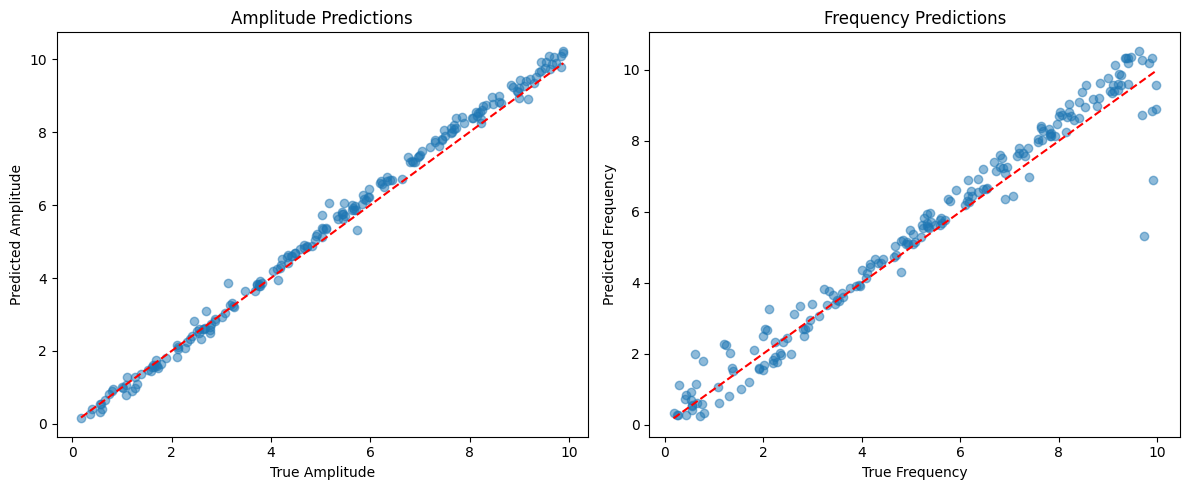


--- Experiment with Dataset Size: 5000 ---
Epoch [10/100], Train Loss: 0.0053, Val Loss: 0.0055, Time: 1.48s
Epoch [20/100], Train Loss: 0.0028, Val Loss: 0.0028, Time: 1.48s
Epoch [30/100], Train Loss: 0.0021, Val Loss: 0.0026, Time: 1.72s
Epoch [40/100], Train Loss: 0.0016, Val Loss: 0.0011, Time: 1.49s
Epoch [50/100], Train Loss: 0.0016, Val Loss: 0.0016, Time: 1.49s
Epoch [60/100], Train Loss: 0.0014, Val Loss: 0.0021, Time: 1.49s
Epoch [70/100], Train Loss: 0.0013, Val Loss: 0.0014, Time: 1.71s
Epoch [80/100], Train Loss: 0.0015, Val Loss: 0.0018, Time: 1.51s
Epoch [90/100], Train Loss: 0.0013, Val Loss: 0.0030, Time: 1.51s
Epoch [100/100], Train Loss: 0.0010, Val Loss: 0.0016, Time: 1.51s
Performance metrics for dataset size 5000:
MSE - Amplitude: 0.1813, Frequency: 0.1205
MAE - Amplitude: 0.3500, Frequency: 0.2460




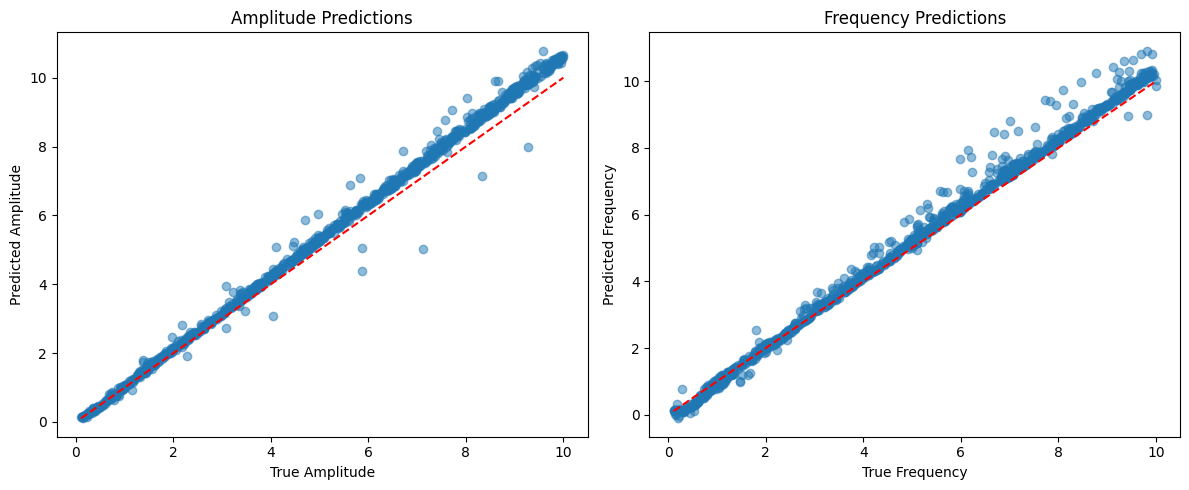


--- Experiment with Dataset Size: 10000 ---
Epoch [10/100], Train Loss: 0.0030, Val Loss: 0.0038, Time: 3.17s
Epoch [20/100], Train Loss: 0.0014, Val Loss: 0.0017, Time: 3.03s
Epoch [30/100], Train Loss: 0.0010, Val Loss: 0.0020, Time: 3.05s
Epoch [40/100], Train Loss: 0.0010, Val Loss: 0.0015, Time: 3.04s
Epoch [50/100], Train Loss: 0.0007, Val Loss: 0.0014, Time: 3.04s
Epoch [60/100], Train Loss: 0.0008, Val Loss: 0.0012, Time: 3.16s
Epoch [70/100], Train Loss: 0.0004, Val Loss: 0.0012, Time: 3.03s
Epoch [80/100], Train Loss: 0.0006, Val Loss: 0.0018, Time: 3.20s
Epoch [90/100], Train Loss: 0.0005, Val Loss: 0.0020, Time: 3.04s
Epoch [100/100], Train Loss: 0.0008, Val Loss: 0.0014, Time: 3.37s
Performance metrics for dataset size 10000:
MSE - Amplitude: 0.1779, Frequency: 0.1009
MAE - Amplitude: 0.3475, Frequency: 0.2235




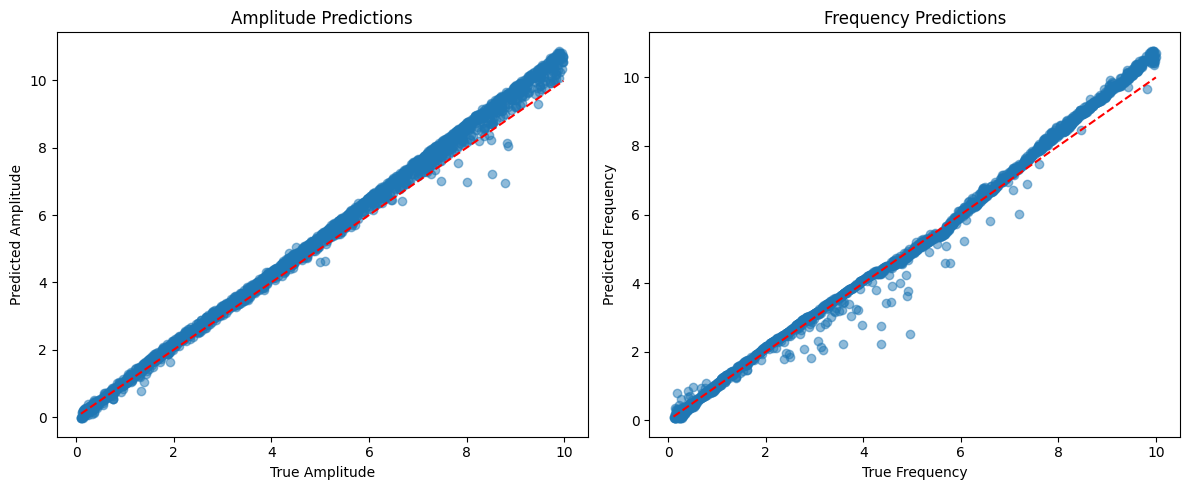

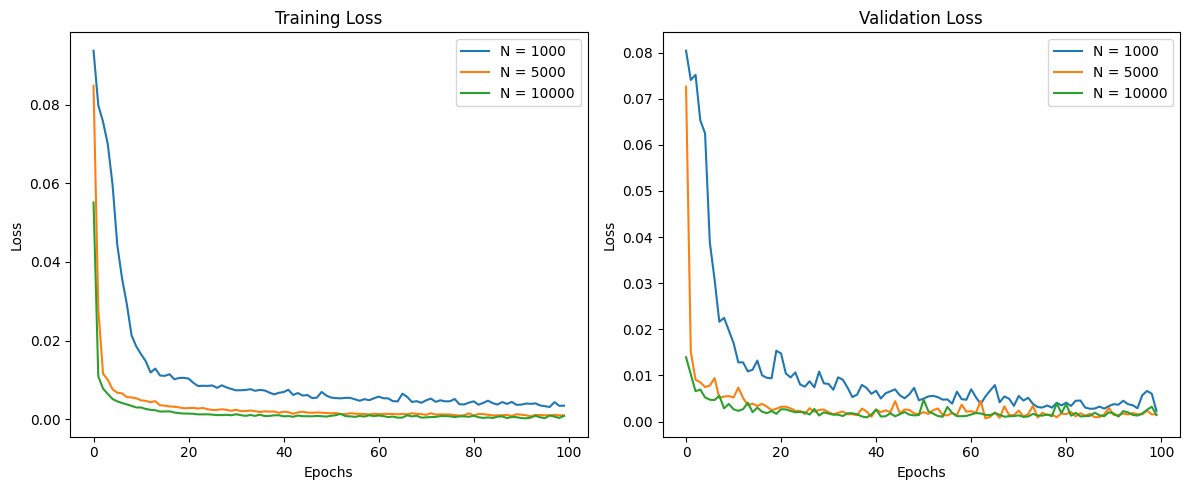

In [ ]:
# Run the experiment
best_hyperparams = {
    'd_model': 128,
    'nhead': 4,
    'num_layers': 4,
    'dim_feedforward': 256,
    'dropout': 0.2,
    'batch_size': 32,
    'learning_rate': 0.0001
}
experiment_results = experiment_with_dataset_sizes()

# 3. Different model architectures. Comparison

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): Number of epochs without improvement before stopping.
            delta (float): Minimum improvement considered significant.
            path (str): Path to save the best model.
            verbose (bool): Whether to print messages about saving the new model.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves the model if the validation loss has decreased."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f})")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.SiLU()  # Using SiLU instead of ReLU

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

# Transformer Model
class SineWaveTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=4, num_layers=4, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=8, num_layers=3, dim_feedforward=512):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)

        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))

        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)

        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        memory = x.clone()
        for layer in self.layers:
            x = layer(x, memory)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
class EncoderDecoderTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=8, num_layers=3, dim_feedforward=512):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)

        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)

        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        memory = self.encoder(x)
        x = self.decoder(x, memory)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
class TransformerModelComparator:
    def __init__(self, seq_len=100, device='cuda'):
        self.seq_len = seq_len
        self.device = device
        self.models = {
            'Encoder Transformer': self._create_encoder_transformer(),
            'Decoder Transformer': self._create_decoder_transformer(),
            'Encoder-Decoder Transformer': self._create_encoder_decoder_transformer()
        }

    def _create_encoder_transformer(self):
        return SineWaveTransformer(seq_len=self.seq_len, d_model=128, nhead=4, num_layers=4)

    def _create_decoder_transformer(self):
        return DecoderOnlyTransformer(seq_len=self.seq_len, d_model=128, nhead=4, num_layers=4)

    def _create_encoder_decoder_transformer(self):
        return EncoderDecoderTransformer(seq_len=self.seq_len, d_model=128, nhead=4, num_layers=4)

    def generate_data(self, N=5000, A_range=(0.1, 10), omega_range=(0.1, 10)):
        t = torch.linspace(0, 2 * torch.pi, self.seq_len)
        A_values = torch.empty(N).uniform_(*A_range)
        omega_values = torch.empty(N).uniform_(*omega_range)
        sine_waves = A_values.unsqueeze(1) * torch.sin(omega_values.unsqueeze(1) * t)
        labels = torch.stack([A_values, omega_values], dim=1)
        return sine_waves, labels

    def prepare_data(self, sine_waves, labels, test_size=0.2, batch_size=32):
        X = sine_waves.numpy()
        y = labels.numpy()
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

        input_scaler = MinMaxScaler()
        X_train_scaled = input_scaler.fit_transform(X_train)
        X_val_scaled = input_scaler.transform(X_val)

        label_scaler = MinMaxScaler()
        y_train_scaled = label_scaler.fit_transform(y_train)
        y_val_scaled = label_scaler.transform(y_val)

        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_scaled),
            torch.FloatTensor(y_train_scaled)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val_scaled),
            torch.FloatTensor(y_val_scaled)
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        return train_loader, val_loader, (input_scaler, label_scaler)

    def train_model(self, model, train_loader, val_loader, epochs=100, lr=0.0001,
                   patience=10, delta=0, checkpoint_path=None):
        model = model.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        r2_metric = R2Score().to(self.device)

        # Initialize early stopping
        if checkpoint_path is None:
            checkpoint_path = f'checkpoint_{type(model).__name__}.pt'
        early_stopping = EarlyStopping(
            patience=patience,
            delta=delta,
            path=checkpoint_path,
            verbose=True
        )

        train_losses, val_losses, r2_scores = [], [], []

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation
            model.eval()
            val_loss, val_r2 = 0, 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    outputs = model(batch_X)
                    val_loss += criterion(outputs, batch_y).item()
                    val_r2 += r2_metric(outputs, batch_y)

            val_loss /= len(val_loader)
            val_r2 /= len(val_loader)
            val_losses.append(val_loss)
            r2_scores.append(val_r2.item())

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {val_r2:.4f}')

            # Early stopping
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                # Load best model
                model.load_state_dict(torch.load(checkpoint_path))
                break

        return train_losses, val_losses, r2_scores

    def evaluate_model(self, model, val_loader, label_scaler):
        model.eval()
        predictions, true_values = [], []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = model(batch_X)
                predictions.append(outputs.cpu().numpy())
                true_values.append(batch_y.cpu().numpy())

        predictions = label_scaler.inverse_transform(np.vstack(predictions))
        true_values = label_scaler.inverse_transform(np.vstack(true_values))

        mse = np.mean((predictions - true_values) ** 2, axis=0)
        mae = np.mean(np.abs(predictions - true_values), axis=0)
        r2 = 1 - (np.sum((true_values - predictions) ** 2) / np.sum((true_values - true_values.mean()) ** 2))

        return mse, mae, r2, predictions, true_values

    def visualize_results(self, model_name, predictions, true_values):
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.scatter(true_values[:, 0], predictions[:, 0], alpha=0.5)
        plt.plot([true_values[:, 0].min(), true_values[:, 0].max()],
                 [true_values[:, 0].min(), true_values[:, 0].max()], 'r--')
        plt.title(f'{model_name} - Amplitude Prediction')
        plt.xlabel('True Amplitude')
        plt.ylabel('Predicted Amplitude')

        plt.subplot(122)
        plt.scatter(true_values[:, 1], predictions[:, 1], alpha=0.5)
        plt.plot([true_values[:, 1].min(), true_values[:, 1].max()],
                 [true_values[:, 1].min(), true_values[:, 1].max()], 'r--')
        plt.title(f'{model_name} - Frequency Prediction')
        plt.xlabel('True Frequency')
        plt.ylabel('Predicted Frequency')

        plt.tight_layout()
        plt.savefig(f'{model_name.replace(" ", "_")}_predictions.png')
        plt.close()

    def run_comparison(self):
        # Generate data
        sine_waves, labels = self.generate_data(N=5000)
        train_loader, val_loader, (input_scaler, label_scaler) = self.prepare_data(sine_waves, labels)

        # Timing and results
        results = []

        for name, model in self.models.items():
            print(f"\n--- Evaluating {name} ---")
            start_time = time.time()

            # Training with early stopping
            checkpoint_path = f'checkpoint_{name.replace(" ", "_")}.pt'
            train_losses, val_losses, r2_scores = self.train_model(
                model,
                train_loader,
                val_loader,
                checkpoint_path=checkpoint_path,
                patience=10,
                delta=1e-4
            )

            # Evaluation
            mse, mae, r2, predictions, true_values = self.evaluate_model(model, val_loader, label_scaler)

            # Save results
            results.append({
                'Model': name,
                'Training Time (s)': time.time() - start_time,
                'MSE Amplitude': mse[0],
                'MSE Frequency': mse[1],
                'MAE Amplitude': mae[0],
                'MAE Frequency': mae[1],
                'R2 Score': r2
            })

            # Visualize predictions
            self.visualize_results(name, predictions, true_values)

            # Plot loss curves
            plt.figure(figsize=(12, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title(f'{name} - Loss Curves')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f'{name.replace(" ", "_")}_loss_curve.png')
            plt.close()

        # Create DataFrame with results
        results_df = pd.DataFrame(results)
        print("\nComparison Results:")
        print(results_df)
        results_df.to_csv('transformer_comparison_results.csv', index=False)

        return results_df

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
comparator = TransformerModelComparator(device=device)
results = comparator.run_comparison()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- Evaluating Encoder Transformer ---
Validation loss decreased (inf --> 0.069854)
Validation loss decreased (0.069854 --> 0.011305)
Validation loss decreased (0.011305 --> 0.008383)
Validation loss decreased (0.008383 --> 0.006826)
EarlyStopping counter: 1/10
Validation loss decreased (0.006826 --> 0.006105)
Validation loss decreased (0.006105 --> 0.005729)
EarlyStopping counter: 1/10
Validation loss decreased (0.005729 --> 0.004495)
EarlyStopping counter: 1/10
Validation loss decreased (0.004495 --> 0.004048)
EarlyStopping counter: 1/10
Validation loss decreased (0.004048 --> 0.003519)
Validation loss decreased (0.003519 --> 0.003357)
EarlyStopping counter: 1/10
Validation loss decreased (0.003357 --> 0.002732)
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
EarlyStopping counter: 3/10
Epoch [20/100], Train Loss: 0.0026, Val Loss: 0.0022, R2: 0.9726
Validation loss decreased (0.002732 --> 0.002230)
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
Validation loss decr

<ipython-input-17-ac37d9efb271>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



--- Evaluating Decoder Transformer ---
Validation loss decreased (inf --> 0.049554)
Validation loss decreased (0.049554 --> 0.014996)
Validation loss decreased (0.014996 --> 0.009718)
Validation loss decreased (0.009718 --> 0.007102)
Validation loss decreased (0.007102 --> 0.006762)
Validation loss decreased (0.006762 --> 0.005460)
Validation loss decreased (0.005460 --> 0.005032)
EarlyStopping counter: 1/10
Validation loss decreased (0.005032 --> 0.003760)
Validation loss decreased (0.003760 --> 0.003444)
EarlyStopping counter: 1/10
Validation loss decreased (0.003444 --> 0.003263)
EarlyStopping counter: 1/10
Validation loss decreased (0.003263 --> 0.003153)
EarlyStopping counter: 1/10
Validation loss decreased (0.003153 --> 0.002757)
Validation loss decreased (0.002757 --> 0.002477)
Validation loss decreased (0.002477 --> 0.002358)
EarlyStopping counter: 1/10
Epoch [20/100], Train Loss: 0.0029, Val Loss: 0.0048, R2: 0.9406
EarlyStopping counter: 2/10
Validation loss decreased (0.002

<ipython-input-17-ac37d9efb271>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



--- Evaluating Encoder-Decoder Transformer ---
Validation loss decreased (inf --> 0.058598)
Validation loss decreased (0.058598 --> 0.009200)
Validation loss decreased (0.009200 --> 0.004667)
Validation loss decreased (0.004667 --> 0.002859)
EarlyStopping counter: 1/10
Validation loss decreased (0.002859 --> 0.002174)
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
Validation loss decreased (0.002174 --> 0.001535)
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
EarlyStopping counter: 3/10
EarlyStopping counter: 4/10
EarlyStopping counter: 5/10
EarlyStopping counter: 6/10
EarlyStopping counter: 7/10
EarlyStopping counter: 8/10
EarlyStopping counter: 9/10
Validation loss decreased (0.001535 --> 0.001385)
Epoch [20/100], Train Loss: 0.0024, Val Loss: 0.0024, R2: 0.9705
EarlyStopping counter: 1/10
Validation loss decreased (0.001385 --> 0.001035)
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
EarlyStopping counter: 3/10
EarlyStopping counter: 4/10
Validation loss 

<ipython-input-17-ac37d9efb271>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



Comparison Results:
                         Model  Training Time (s)  MSE Amplitude  \
0          Encoder Transformer          55.113973       0.076939   
1          Decoder Transformer         154.587564       0.028098   
2  Encoder-Decoder Transformer         162.943300       0.045229   

   MSE Frequency  MAE Amplitude  MAE Frequency  R2 Score  
0       0.265539       0.207789       0.337926  0.979101  
1       0.079430       0.109377       0.140570  0.993438  
2       0.110106       0.138678       0.190743  0.990521  


In [ ]:
results

Model  Training Time (s)  MSE Amplitude  \
0          Encoder Transformer          55.113973       0.076939   
1          Decoder Transformer         154.587564       0.028098   
2  Encoder-Decoder Transformer         162.943300       0.045229   

   MSE Frequency  MAE Amplitude  MAE Frequency  R2 Score  
0       0.265539       0.207789       0.337926  0.979101  
1       0.079430       0.109377       0.140570  0.993438  
2       0.110106       0.138678       0.190743  0.990521

# Fourier transform

## Fourier transform Encoder-only

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): Number of epochs without improvement before stopping.
            delta (float): Minimum improvement considered significant.
            path (str): Path to save the best model.
            verbose (bool): Whether to print messages about saving the new model.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves the model if the validation loss has decreased."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f})")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.SiLU()  # Using SiLU instead of ReLU

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

# Transformer Model
class SineWaveTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=4, num_layers=4, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

# Data Generation
def generate_data(seq_len, N=5000, A_range=(0.1, 10), omega_range=(0.1, 10)):
    t = torch.linspace(0, 2 * torch.pi, seq_len)
    A_values = torch.empty(N).uniform_(*A_range)
    omega_values = torch.empty(N).uniform_(*omega_range)
    sine_waves = A_values.unsqueeze(1) * torch.sin(omega_values.unsqueeze(1) * t)
    labels = torch.stack([A_values, omega_values], dim=1)
    return sine_waves, labels

# Fourier Transformation
def apply_fourier_transform(data):
    return torch.fft.fft(data, dim=-1).abs()

# Data Preparation
def prepare_data(sine_waves, labels, test_size=0.2, batch_size=32):
    X = sine_waves.numpy()
    y = labels.numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

    input_scaler = MinMaxScaler()
    X_train_scaled = input_scaler.fit_transform(X_train)
    X_val_scaled = input_scaler.transform(X_val)

    label_scaler = MinMaxScaler()
    y_train_scaled = label_scaler.fit_transform(y_train)
    y_val_scaled = label_scaler.transform(y_val)

    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_scaled),
        torch.FloatTensor(y_train_scaled)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val_scaled),
        torch.FloatTensor(y_val_scaled)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, (input_scaler, label_scaler)

def train_model_with_fourier(model, train_loader, val_loader, use_fourier=False, epochs=100, lr=0.0001):
    model = model.to(device)  # Move model to GPU or CPU
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    r2_metric = R2Score().to(device)

    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=10, verbose=True)

    train_losses, val_losses, r2_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move tensors to the same device

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss, val_r2 = 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move tensors to the same device
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_r2 += r2_metric(outputs, batch_y)

        val_loss /= len(val_loader)
        val_r2 /= len(val_loader)
        val_losses.append(val_loss)
        r2_scores.append(val_r2.item())

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {val_r2:.4f}")

        # Early Stopping Check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load(early_stopping.path))

    return train_losses, val_losses, r2_scores


def evaluate_model(model, val_loader, label_scaler, use_fourier=False):
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move tensors to the same device

            # Apply Fourier Transform if specified
            if use_fourier:
                batch_X = apply_fourier_transform(batch_X)

            outputs = model(batch_X)
            predictions.append(outputs.cpu().numpy())
            true_values.append(batch_y.cpu().numpy())

    predictions = label_scaler.inverse_transform(np.vstack(predictions))
    true_values = label_scaler.inverse_transform(np.vstack(true_values))

    mse = np.mean((predictions - true_values) ** 2, axis=0)
    mae = np.mean(np.abs(predictions - true_values), axis=0)
    r2 = 1 - (np.sum((true_values - predictions) ** 2) / np.sum((true_values - true_values.mean()) ** 2))

    return mse, mae, r2, predictions, true_values


In [ ]:
def compare_results(model, train_loader, val_loader, label_scaler, epochs=70, lr=0.0001):
    results = []

    # Training without Fourier transformation
    print("\n Training model without Fourier transformation... \n")
    train_losses, val_losses, r2_scores_no_fourier = train_model_with_fourier(
        model, train_loader, val_loader, use_fourier=False, epochs=epochs, lr=lr
    )
    mse_no_fourier, mae_no_fourier, r2_no_fourier, _, _ = evaluate_model(model, val_loader, label_scaler)
    results.append({
        "Method": "Without Fourier",
        "MSE Amplitude": mse_no_fourier[0],
        "MSE Frequency": mse_no_fourier[1],
        "MAE Amplitude": mae_no_fourier[0],
        "MAE Frequency": mae_no_fourier[1],
        "R2 Score": r2_no_fourier
    })

    # Training with Fourier transformation
    print("\n Training model with Fourier transformation... \n")
    train_losses, val_losses, r2_scores_fourier = train_model_with_fourier(
        model, train_loader, val_loader, use_fourier=True, epochs=epochs, lr=lr
    )
    mse_fourier, mae_fourier, r2_fourier, _, _ = evaluate_model(model, val_loader, label_scaler)
    results.append({
        "Method": "With Fourier",
        "MSE Amplitude": mse_fourier[0],
        "MSE Frequency": mse_fourier[1],
        "MAE Amplitude": mae_fourier[0],
        "MAE Frequency": mae_fourier[1],
        "R2 Score": r2_fourier
    })

    # Creating the table
    results_df = pd.DataFrame(results)
    print("\nComparison Results:")
    print(results_df)

    # Saving the table to a file
    results_df.to_csv("comparison_results.csv", index=False)
    print("\nResults saved to 'comparison_results.csv'.")

    return results_df

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_params = {
    'd_model': 128,
    'nhead': 4,
    'num_layers': 4,
    'dim_feedforward': 256,
    'dropout': 0.2
}

model_f = SineWaveTransformer(seq_len=100, **model_params)

In [ ]:
sine_waves, labels = generate_data(seq_len=100)

In [ ]:
train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(sine_waves, labels)

In [ ]:
results_df = compare_results(
    model_f,
    train_loader,
    val_loader,
    label_scaler,
    epochs=100,
    lr=0.0001
)

print(results_df)


 Training model without Fourier transformation... 

Epoch [1/100], Train Loss: 0.0717, Val Loss: 0.0377, R2: 0.5350
Validation loss decreased (inf --> 0.037691)
Epoch [2/100], Train Loss: 0.0228, Val Loss: 0.0169, R2: 0.7863
Validation loss decreased (0.037691 --> 0.016919)
Epoch [3/100], Train Loss: 0.0140, Val Loss: 0.0143, R2: 0.8163
Validation loss decreased (0.016919 --> 0.014350)
Epoch [4/100], Train Loss: 0.0120, Val Loss: 0.0122, R2: 0.8429
Validation loss decreased (0.014350 --> 0.012220)
Epoch [5/100], Train Loss: 0.0096, Val Loss: 0.0097, R2: 0.8774
Validation loss decreased (0.012220 --> 0.009680)
Epoch [6/100], Train Loss: 0.0081, Val Loss: 0.0110, R2: 0.8598
EarlyStopping counter: 1/10
Epoch [7/100], Train Loss: 0.0072, Val Loss: 0.0076, R2: 0.9038
Validation loss decreased (0.009680 --> 0.007612)
Epoch [8/100], Train Loss: 0.0065, Val Loss: 0.0070, R2: 0.9122
Validation loss decreased (0.007612 --> 0.006953)
Epoch [9/100], Train Loss: 0.0062, Val Loss: 0.0065, R2: 0.917

<ipython-input-30-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 0.0014, Val Loss: 0.0015, R2: 0.9798
Validation loss decreased (inf --> 0.001533)
Epoch [2/100], Train Loss: 0.0010, Val Loss: 0.0020, R2: 0.9754
EarlyStopping counter: 1/10
Epoch [3/100], Train Loss: 0.0012, Val Loss: 0.0014, R2: 0.9819
Validation loss decreased (0.001533 --> 0.001385)
Epoch [4/100], Train Loss: 0.0012, Val Loss: 0.0008, R2: 0.9900
Validation loss decreased (0.001385 --> 0.000795)
Epoch [5/100], Train Loss: 0.0009, Val Loss: 0.0017, R2: 0.9791
EarlyStopping counter: 1/10
Epoch [6/100], Train Loss: 0.0011, Val Loss: 0.0012, R2: 0.9844
EarlyStopping counter: 2/10
Epoch [7/100], Train Loss: 0.0010, Val Loss: 0.0007, R2: 0.9911
Validation loss decreased (0.000795 --> 0.000719)
Epoch [8/100], Train Loss: 0.0010, Val Loss: 0.0017, R2: 0.9777
EarlyStopping counter: 1/10
Epoch [9/100], Train Loss: 0.0010, Val Loss: 0.0014, R2: 0.9828
EarlyStopping counter: 2/10
Epoch [10/100], Train Loss: 0.0010, Val Loss: 0.0027, R2: 0.9639
EarlyStopping counter: 3

<ipython-input-30-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


In [ ]:
results_df

Method  MSE Amplitude  MSE Frequency  MAE Amplitude  \
0  Without Fourier       0.074051       0.083018       0.197286   
1     With Fourier       0.101256       0.040785       0.245737   

   MAE Frequency  R2 Score  
0       0.186467  0.990769  
1       0.125910  0.991652

## Fourier transform Decoder-only

In [ ]:
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=4, num_layers=4, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))

        # Create custom decoder layer
        decoder_layers = []
        for _ in range(num_layers):
            decoder_layer = nn.ModuleDict({
                'self_attn': nn.MultiheadAttention(d_model, nhead, dropout=dropout),
                'norm1': nn.LayerNorm(d_model),
                'linear1': nn.Linear(d_model, dim_feedforward),
                'linear2': nn.Linear(dim_feedforward, d_model),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout),
                'activation': nn.SiLU()
            })
            decoder_layers.append(decoder_layer)

        self.layers = nn.ModuleList(decoder_layers)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input shape: [batch_size, seq_len]
        x = x.unsqueeze(-1)  # [batch_size, seq_len, 1]
        x = self.embedding(x)  # [batch_size, seq_len, d_model]

        # Add positional encoding
        x = x + self.pos_encoding

        # Change shape for attention
        x = x.transpose(0, 1)  # [seq_len, batch_size, d_model]

        # Apply decoder layers
        for layer in self.layers:
            # Self-attention
            attn_output, _ = layer['self_attn'](x, x, x)
            x = x + self.dropout(attn_output)
            x = layer['norm1'](x)

            # Feed forward
            ff_output = layer['linear2'](self.dropout(layer['activation'](layer['linear1'](x)))))
            x = x + self.dropout(ff_output)
            x = layer['norm2'](x)

        # Return to original shape
        x = x.transpose(0, 1)  # [batch_size, seq_len, d_model]

        # Apply pooling and final layer
        x = x.transpose(1, 2)  # [batch_size, d_model, seq_len]
        x = self.pooling(x).squeeze(-1)  # [batch_size, d_model]
        x = self.fc(x)  # [batch_size, 2]

        return x

def test_decoder_model(decoder_model, train_loader, val_loader, label_scaler, existing_results_df, epochs=70, lr=0.0001):
    new_results = []

    # Testing Decoder-only without Fourier transformation
    print("\nTraining Decoder-only model without Fourier transformation...")
    train_losses, val_losses, r2_scores = train_model_with_fourier(
        decoder_model, train_loader, val_loader, use_fourier=False, epochs=epochs, lr=lr
    )
    mse, mae, r2, _, _ = evaluate_model(decoder_model, val_loader, label_scaler)
    new_results.append({
        "Method": "Without Fourier",
        "MSE Amplitude": mse[0],
        "MSE Frequency": mse[1],
        "MAE Amplitude": mae[0],
        "MAE Frequency": mae[1],
        "R2 Score": r2,
        "Architecture": "Decoder-only"
    })

    # Testing Decoder-only with Fourier transformation
    print("\nTraining Decoder-only model with Fourier transformation...")
    train_losses, val_losses, r2_scores = train_model_with_fourier(
        decoder_model, train_loader, val_loader, use_fourier=True, epochs=epochs, lr=lr
    )
    mse, mae, r2, _, _ = evaluate_model(decoder_model, val_loader, label_scaler)
    new_results.append({
        "Method": "With Fourier",
        "MSE Amplitude": mse[0],
        "MSE Frequency": mse[1],
        "MAE Amplitude": mae[0],
        "MAE Frequency": mae[1],
        "R2 Score": r2,
        "Architecture": "Decoder-only"
    })

    # Add architecture to existing results
    existing_results_df['Architecture'] = 'Encoder-only'

    # Create DataFrame from new results
    decoder_results_df = pd.DataFrame(new_results)

    # Combine the results
    combined_results = pd.concat([existing_results_df, decoder_results_df], ignore_index=True)

    print("\nComparison Results:")
    print(combined_results)

    combined_results.to_csv("combined_architecture_comparison.csv", index=False)
    print("\nResults saved to 'combined_architecture_comparison.csv'.")

    return combined_results


In [ ]:
decoder_model = DecoderOnlyTransformer(seq_len=100, **model_params)

combined_results = test_decoder_model(
    decoder_model,
    train_loader,
    val_loader,
    label_scaler,
    results_df,
    epochs=100,
    lr=0.0001
)


Training Decoder-only model without Fourier transformation...
Epoch [1/100], Train Loss: 0.0825, Val Loss: 0.0464, R2: 0.4221
Validation loss decreased (inf --> 0.046441)
Epoch [2/100], Train Loss: 0.0229, Val Loss: 0.0146, R2: 0.8179
Validation loss decreased (0.046441 --> 0.014640)
Epoch [3/100], Train Loss: 0.0110, Val Loss: 0.0093, R2: 0.8824
Validation loss decreased (0.014640 --> 0.009330)
Epoch [4/100], Train Loss: 0.0081, Val Loss: 0.0077, R2: 0.9026
Validation loss decreased (0.009330 --> 0.007739)
Epoch [5/100], Train Loss: 0.0072, Val Loss: 0.0130, R2: 0.8335
EarlyStopping counter: 1/10
Epoch [6/100], Train Loss: 0.0066, Val Loss: 0.0058, R2: 0.9262
Validation loss decreased (0.007739 --> 0.005779)
Epoch [7/100], Train Loss: 0.0057, Val Loss: 0.0066, R2: 0.9152
EarlyStopping counter: 1/10
Epoch [8/100], Train Loss: 0.0060, Val Loss: 0.0068, R2: 0.9143
EarlyStopping counter: 2/10
Epoch [9/100], Train Loss: 0.0051, Val Loss: 0.0045, R2: 0.9419
Validation loss decreased (0.005

<ipython-input-30-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 0.0018, Val Loss: 0.0016, R2: 0.9809
Validation loss decreased (inf --> 0.001556)
Epoch [2/100], Train Loss: 0.0014, Val Loss: 0.0010, R2: 0.9873
Validation loss decreased (0.001556 --> 0.001031)
Epoch [3/100], Train Loss: 0.0011, Val Loss: 0.0020, R2: 0.9743
EarlyStopping counter: 1/10
Epoch [4/100], Train Loss: 0.0013, Val Loss: 0.0034, R2: 0.9561
EarlyStopping counter: 2/10
Epoch [5/100], Train Loss: 0.0015, Val Loss: 0.0015, R2: 0.9809
EarlyStopping counter: 3/10
Epoch [6/100], Train Loss: 0.0012, Val Loss: 0.0019, R2: 0.9765
EarlyStopping counter: 4/10
Epoch [7/100], Train Loss: 0.0011, Val Loss: 0.0015, R2: 0.9808
EarlyStopping counter: 5/10
Epoch [8/100], Train Loss: 0.0013, Val Loss: 0.0035, R2: 0.9571
EarlyStopping counter: 6/10
Epoch [9/100], Train Loss: 0.0011, Val Loss: 0.0024, R2: 0.9700
EarlyStopping counter: 7/10
Epoch [10/100], Train Loss: 0.0012, Val Loss: 0.0024, R2: 0.9699
EarlyStopping counter: 8/10
Epoch [11/100], Train Loss: 0.0011, Val 

<ipython-input-30-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


In [ ]:
combined_results

Method  MSE Amplitude  MSE Frequency  MAE Amplitude  \
0  Without Fourier       0.074051       0.083018       0.197286   
1     With Fourier       0.101256       0.040785       0.245737   
2  Without Fourier       0.148505       0.099650       0.286074   
3     With Fourier       0.091786       0.112735       0.240786   

   MAE Frequency  R2 Score  Architecture  
0       0.186467  0.990769  Encoder-only  
1       0.125910  0.991652  Encoder-only  
2       0.201202  0.985415  Decoder-only  
3       0.197463  0.987980  Decoder-only

## Fourier transform improving

In [ ]:
def apply_fourier_transform(data, device = device):
    """
    Enhanced Fourier transform with amplitude and phase handling
    """
    # Perform FFT
    fft_result = torch.fft.fft(data, dim=-1)

    # Get the amplitude spectrum
    amplitudes = torch.abs(fft_result)

    # Get the phase spectrum
    phases = torch.angle(fft_result)

    # Normalize amplitudes
    amplitudes = amplitudes / data.shape[-1]

    # Take only the first half of the spectrum (due to symmetry)
    n = data.shape[-1]
    n_freqs = n // 2 + 1
    amplitudes = amplitudes[..., :n_freqs]
    phases = phases[..., :n_freqs]

    # Scale the amplitudes for better numerical stability without log1p
    amplitudes = amplitudes / torch.max(amplitudes)  # Scaling to [0, 1]

    # Normalize amplitudes (Min-Max scaling)
    scaler = MinMaxScaler()
    amplitudes = torch.tensor(scaler.fit_transform(amplitudes.cpu().numpy()), device=data.device)

    # Combine amplitudes and phases
    return torch.stack([amplitudes, phases], dim=-1)


In [ ]:
def compare_all_architectures(encoder_model, decoder_model, train_loader, val_loader, label_scaler, epochs=70, lr=0.0001, device = device):
    results = []

    # Test Encoder-only without Fourier
    print("\nTraining Encoder-only model without Fourier transformation...")
    train_losses, val_losses, r2_scores = train_model_with_fourier(
        encoder_model, train_loader, val_loader, use_fourier=False, epochs=epochs, lr=lr
    )
    mse, mae, r2, _, _ = evaluate_model(encoder_model, val_loader, label_scaler)
    results.append({
        "Architecture": "Encoder-only",
        "Method": "Without Fourier",
        "MSE Amplitude": mse[0],
        "MSE Frequency": mse[1],
        "MAE Amplitude": mae[0],
        "MAE Frequency": mae[1],
        "R2 Score": r2
    })

    # Test Encoder-only with Fourier
    print("\nTraining Encoder-only model with Fourier transformation...")
    train_losses, val_losses, r2_scores = train_model_with_fourier(
        encoder_model, train_loader, val_loader, use_fourier=True, epochs=epochs, lr=lr
    )
    mse, mae, r2, _, _ = evaluate_model(encoder_model, val_loader, label_scaler)
    results.append({
        "Architecture": "Encoder-only",
        "Method": "With Fourier",
        "MSE Amplitude": mse[0],
        "MSE Frequency": mse[1],
        "MAE Amplitude": mae[0],
        "MAE Frequency": mae[1],
        "R2 Score": r2
    })

    # Test Decoder-only without Fourier
    print("\nTraining Decoder-only model without Fourier transformation...")
    train_losses, val_losses, r2_scores = train_model_with_fourier(
        decoder_model, train_loader, val_loader, use_fourier=False, epochs=epochs, lr=lr
    )
    mse, mae, r2, _, _ = evaluate_model(decoder_model, val_loader, label_scaler)
    results.append({
        "Architecture": "Decoder-only",
        "Method": "Without Fourier",
        "MSE Amplitude": mse[0],
        "MSE Frequency": mse[1],
        "MAE Amplitude": mae[0],
        "MAE Frequency": mae[1],
        "R2 Score": r2
    })

    # Test Decoder-only with Fourier
    print("\nTraining Decoder-only model with Fourier transformation...")
    train_losses, val_losses, r2_scores = train_model_with_fourier(
        decoder_model, train_loader, val_loader, use_fourier=True, epochs=epochs, lr=lr
    )
    mse, mae, r2, _, _ = evaluate_model(decoder_model, val_loader, label_scaler)
    results.append({
        "Architecture": "Decoder-only",
        "Method": "With Fourier",
        "MSE Amplitude": mse[0],
        "MSE Frequency": mse[1],
        "MAE Amplitude": mae[0],
        "MAE Frequency": mae[1],
        "R2 Score": r2
    })

    results_df = pd.DataFrame(results)
    print("\nComparison Results:")
    print(results_df)

    results_df.to_csv("all_architectures_comparison.csv", index=False)
    print("\nResults saved to 'all_architectures_comparison.csv'.")

    return results_df


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_model = SineWaveTransformer(seq_len=100, **model_params)
decoder_model = DecoderOnlyTransformer(seq_len=100, **model_params)

results_df = compare_all_architectures(
    encoder_model,
    decoder_model,
    train_loader,
    val_loader,
    label_scaler,
    epochs=100,
    lr=0.0001,
    device = device
)


Training Encoder-only model without Fourier transformation...
Epoch [1/100], Train Loss: 0.0799, Val Loss: 0.0535, R2: 0.3313
Validation loss decreased (inf --> 0.053467)
Epoch [2/100], Train Loss: 0.0310, Val Loss: 0.0143, R2: 0.8202
Validation loss decreased (0.053467 --> 0.014301)
Epoch [3/100], Train Loss: 0.0117, Val Loss: 0.0130, R2: 0.8347
Validation loss decreased (0.014301 --> 0.012994)
Epoch [4/100], Train Loss: 0.0098, Val Loss: 0.0077, R2: 0.9003
Validation loss decreased (0.012994 --> 0.007745)
Epoch [5/100], Train Loss: 0.0075, Val Loss: 0.0072, R2: 0.9077
Validation loss decreased (0.007745 --> 0.007241)
Epoch [6/100], Train Loss: 0.0065, Val Loss: 0.0075, R2: 0.9057
EarlyStopping counter: 1/10
Epoch [7/100], Train Loss: 0.0058, Val Loss: 0.0071, R2: 0.9083
Validation loss decreased (0.007241 --> 0.007116)
Epoch [8/100], Train Loss: 0.0053, Val Loss: 0.0063, R2: 0.9176
Validation loss decreased (0.007116 --> 0.006320)
Epoch [9/100], Train Loss: 0.0048, Val Loss: 0.0043,

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 0.0013, Val Loss: 0.0017, R2: 0.9792
Validation loss decreased (inf --> 0.001659)
Epoch [2/100], Train Loss: 0.0017, Val Loss: 0.0012, R2: 0.9855
Validation loss decreased (0.001659 --> 0.001186)
Epoch [3/100], Train Loss: 0.0014, Val Loss: 0.0024, R2: 0.9703
EarlyStopping counter: 1/10
Epoch [4/100], Train Loss: 0.0013, Val Loss: 0.0018, R2: 0.9782
EarlyStopping counter: 2/10
Epoch [5/100], Train Loss: 0.0012, Val Loss: 0.0018, R2: 0.9778
EarlyStopping counter: 3/10
Epoch [6/100], Train Loss: 0.0013, Val Loss: 0.0013, R2: 0.9847
EarlyStopping counter: 4/10
Epoch [7/100], Train Loss: 0.0011, Val Loss: 0.0026, R2: 0.9665
EarlyStopping counter: 5/10
Epoch [8/100], Train Loss: 0.0013, Val Loss: 0.0018, R2: 0.9778
EarlyStopping counter: 6/10
Epoch [9/100], Train Loss: 0.0012, Val Loss: 0.0017, R2: 0.9796
EarlyStopping counter: 7/10
Epoch [10/100], Train Loss: 0.0011, Val Loss: 0.0028, R2: 0.9652
EarlyStopping counter: 8/10
Epoch [11/100], Train Loss: 0.0012, Val 

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 0.0809, Val Loss: 0.0583, R2: 0.2812
Validation loss decreased (inf --> 0.058252)
Epoch [2/100], Train Loss: 0.0354, Val Loss: 0.0140, R2: 0.8253
Validation loss decreased (0.058252 --> 0.013998)
Epoch [3/100], Train Loss: 0.0111, Val Loss: 0.0114, R2: 0.8578
Validation loss decreased (0.013998 --> 0.011356)
Epoch [4/100], Train Loss: 0.0097, Val Loss: 0.0132, R2: 0.8349
EarlyStopping counter: 1/10
Epoch [5/100], Train Loss: 0.0084, Val Loss: 0.0089, R2: 0.8878
Validation loss decreased (0.011356 --> 0.008937)
Epoch [6/100], Train Loss: 0.0071, Val Loss: 0.0072, R2: 0.9090
Validation loss decreased (0.008937 --> 0.007159)
Epoch [7/100], Train Loss: 0.0061, Val Loss: 0.0068, R2: 0.9138
Validation loss decreased (0.007159 --> 0.006815)
Epoch [8/100], Train Loss: 0.0051, Val Loss: 0.0063, R2: 0.9201
Validation loss decreased (0.006815 --> 0.006308)
Epoch [9/100], Train Loss: 0.0049, Val Loss: 0.0044, R2: 0.9445
Validation loss decreased (0.006308 --> 0.004360)
E

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 0.0020, Val Loss: 0.0017, R2: 0.9785
Validation loss decreased (inf --> 0.001739)
Epoch [2/100], Train Loss: 0.0014, Val Loss: 0.0013, R2: 0.9837
Validation loss decreased (0.001739 --> 0.001327)
Epoch [3/100], Train Loss: 0.0017, Val Loss: 0.0024, R2: 0.9701
EarlyStopping counter: 1/10
Epoch [4/100], Train Loss: 0.0016, Val Loss: 0.0015, R2: 0.9821
EarlyStopping counter: 2/10
Epoch [5/100], Train Loss: 0.0016, Val Loss: 0.0010, R2: 0.9867
Validation loss decreased (0.001327 --> 0.001026)
Epoch [6/100], Train Loss: 0.0015, Val Loss: 0.0021, R2: 0.9725
EarlyStopping counter: 1/10
Epoch [7/100], Train Loss: 0.0014, Val Loss: 0.0016, R2: 0.9806
EarlyStopping counter: 2/10
Epoch [8/100], Train Loss: 0.0012, Val Loss: 0.0020, R2: 0.9751
EarlyStopping counter: 3/10
Epoch [9/100], Train Loss: 0.0014, Val Loss: 0.0027, R2: 0.9672
EarlyStopping counter: 4/10
Epoch [10/100], Train Loss: 0.0011, Val Loss: 0.0010, R2: 0.9873
Validation loss decreased (0.001026 --> 0.0010

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


In [ ]:
results_df

Architecture           Method  MSE Amplitude  MSE Frequency  MAE Amplitude  \
0  Encoder-only  Without Fourier       0.111745       0.086671       0.272654   
1  Encoder-only     With Fourier       0.041303       0.138589       0.125268   
2  Decoder-only  Without Fourier       0.085654       0.127309       0.218858   
3  Decoder-only     With Fourier       0.069185       0.128880       0.200063   

   MAE Frequency  R2 Score  
0       0.191683  0.988339  
1       0.232043  0.989427  
2       0.217435  0.987484  
3       0.226432  0.988359

### Complex experiment

In [ ]:
def apply_simple_fourier(data):
    fft_result = torch.fft.fft(data, dim=-1).abs()
    scaler = MinMaxScaler()
    return torch.tensor(scaler.fit_transform(fft_result.numpy()), device=data.device)

def apply_log_fourier(data):
    fft_result = torch.fft.fft(data, dim=-1).abs()
    return torch.log1p(fft_result)

def apply_hann_fourier(data):
    window = torch.hann_window(data.shape[-1], device=data.device)
    windowed_data = data * window
    fft_result = torch.fft.fft(windowed_data, dim=-1)
    return fft_result.abs()

def apply_segmented_fourier(data, segment_size=32):
    # Check if the sequence length is sufficient
    if data.size(-1) < segment_size:
        raise ValueError(f"Sequence length ({data.size(-1)}) is smaller than segment size ({segment_size}).")

    # Segment the data
    segmented_data = data.unfold(-1, segment_size, segment_size // 2)  # 50% overlap
    fft_result = torch.fft.fft(segmented_data, dim=-1).abs()

    # Average and return to the original dimension
    averaged_fft = fft_result.mean(dim=-2)

    # If the dimension has changed, adjust it back to the original
    return torch.nn.functional.interpolate(
        averaged_fft.unsqueeze(1), size=data.size(-1), mode="linear", align_corners=False
    ).squeeze(1)


In [ ]:
def compare_fourier_methods(model, data, labels, methods, label_scaler, epochs=70, lr=0.0001):
    """
    Comparison of Encoder-only model results with different Fourier transformation methods.
    """
    results = []

    # Iterate over Fourier transformation methods
    for method_name, method_func in methods.items():
        print(f"\nTraining model with Fourier transformation method: {method_name}...\n")

        # Apply the Fourier transformation method
        transformed_data = method_func(data)

        # Prepare the data
        train_loader, val_loader, _ = prepare_data(transformed_data, labels)

        # Train the model
        train_losses, val_losses, r2_scores = train_model_with_fourier(
            model, train_loader, val_loader, use_fourier=True, epochs=epochs, lr=lr
        )

        # Evaluate the model
        mse, mae, r2, _, _ = evaluate_model(model, val_loader, label_scaler)

        # Save the results
        results.append({
            "Method": method_name,
            "MSE Amplitude": mse[0],
            "MSE Frequency": mse[1],
            "MAE Amplitude": mae[0],
            "MAE Frequency": mae[1],
            "R2 Score": r2
        })

    # Create a table of results
    results_df = pd.DataFrame(results)
    print("\nComparison Results:")
    print(results_df)

    # Save the table to a file
    results_df.to_csv("fourier_methods_comparison_results.csv", index=False)
    print("\nResults saved to 'fourier_methods_comparison_results.csv'.")

    return results_df


In [ ]:
methods = {
    "Simple Fourier (Min/Max)": apply_simple_fourier,
    "Log Fourier": apply_log_fourier,
    "Hann Window Fourier": apply_hann_fourier,
}


In [ ]:
encoder_model = SineWaveTransformer(seq_len=100, **model_params)

In [ ]:
results_ft_experiment = compare_fourier_methods(encoder_model, sine_waves, labels, methods, label_scaler, epochs=70, lr=0.0001)


Training model with Fourier transformation method: Simple Fourier (Min/Max)...

Epoch [1/70], Train Loss: 0.0664, Val Loss: 0.0603, R2: 0.2619
Validation loss decreased (inf --> 0.060297)
Epoch [2/70], Train Loss: 0.0598, Val Loss: 0.0586, R2: 0.2801
Validation loss decreased (0.060297 --> 0.058574)
Epoch [3/70], Train Loss: 0.0437, Val Loss: 0.0326, R2: 0.5821
Validation loss decreased (0.058574 --> 0.032603)
Epoch [4/70], Train Loss: 0.0153, Val Loss: 0.0164, R2: 0.7934
Validation loss decreased (0.032603 --> 0.016354)
Epoch [5/70], Train Loss: 0.0119, Val Loss: 0.0132, R2: 0.8323
Validation loss decreased (0.016354 --> 0.013169)
Epoch [6/70], Train Loss: 0.0102, Val Loss: 0.0089, R2: 0.8869
Validation loss decreased (0.013169 --> 0.008946)
Epoch [7/70], Train Loss: 0.0093, Val Loss: 0.0085, R2: 0.8934
Validation loss decreased (0.008946 --> 0.008482)
Epoch [8/70], Train Loss: 0.0088, Val Loss: 0.0097, R2: 0.8764
EarlyStopping counter: 1/10
Epoch [9/70], Train Loss: 0.0082, Val Loss

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/70], Train Loss: 0.0227, Val Loss: 0.0093, R2: 0.8864
Validation loss decreased (inf --> 0.009326)
Epoch [2/70], Train Loss: 0.0066, Val Loss: 0.0041, R2: 0.9498
Validation loss decreased (0.009326 --> 0.004100)
Epoch [3/70], Train Loss: 0.0034, Val Loss: 0.0030, R2: 0.9639
Validation loss decreased (0.004100 --> 0.002982)
Epoch [4/70], Train Loss: 0.0024, Val Loss: 0.0028, R2: 0.9662
Validation loss decreased (0.002982 --> 0.002791)
Epoch [5/70], Train Loss: 0.0020, Val Loss: 0.0017, R2: 0.9795
Validation loss decreased (0.002791 --> 0.001680)
Epoch [6/70], Train Loss: 0.0016, Val Loss: 0.0015, R2: 0.9813
Validation loss decreased (0.001680 --> 0.001539)
Epoch [7/70], Train Loss: 0.0014, Val Loss: 0.0015, R2: 0.9818
Validation loss decreased (0.001539 --> 0.001480)
Epoch [8/70], Train Loss: 0.0012, Val Loss: 0.0016, R2: 0.9806
EarlyStopping counter: 1/10
Epoch [9/70], Train Loss: 0.0011, Val Loss: 0.0013, R2: 0.9841
Validation loss decreased (0.001480 --> 0.001306)
Epoch [10/

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/70], Train Loss: 0.0074, Val Loss: 0.0025, R2: 0.9691
Validation loss decreased (inf --> 0.002508)
Epoch [2/70], Train Loss: 0.0022, Val Loss: 0.0016, R2: 0.9800
Validation loss decreased (0.002508 --> 0.001605)
Epoch [3/70], Train Loss: 0.0017, Val Loss: 0.0040, R2: 0.9504
EarlyStopping counter: 1/10
Epoch [4/70], Train Loss: 0.0016, Val Loss: 0.0016, R2: 0.9806
Validation loss decreased (0.001605 --> 0.001573)
Epoch [5/70], Train Loss: 0.0015, Val Loss: 0.0020, R2: 0.9732
EarlyStopping counter: 1/10
Epoch [6/70], Train Loss: 0.0011, Val Loss: 0.0013, R2: 0.9829
Validation loss decreased (0.001573 --> 0.001347)
Epoch [7/70], Train Loss: 0.0014, Val Loss: 0.0011, R2: 0.9866
Validation loss decreased (0.001347 --> 0.001091)
Epoch [8/70], Train Loss: 0.0013, Val Loss: 0.0010, R2: 0.9869
Validation loss decreased (0.001091 --> 0.001027)
Epoch [9/70], Train Loss: 0.0010, Val Loss: 0.0022, R2: 0.9734
EarlyStopping counter: 1/10
Epoch [10/70], Train Loss: 0.0010, Val Loss: 0.0022, R

<ipython-input-93-4fbfcc7fe633>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


In [ ]:
results_ft_experiment

Method  MSE Amplitude  MSE Frequency  MAE Amplitude  \
0  Simple Fourier (Min/Max)       0.081999       0.155247       0.197955   
1               Log Fourier       0.063269       0.058093       0.173678   
2       Hann Window Fourier       0.087342       0.081492       0.169505   

   MAE Frequency  R2 Score  
0       0.273719  0.986057  
1       0.178337  0.992867  
2       0.195399  0.990077

# Final Models with FT: Encoder-only vs Decoder-only vs Encoder-Decoder (N=10000)

In [ ]:
# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.2):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.SiLU()

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        ff_output = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

# Encoder-Only Transformer
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=4, num_layers=4, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

# Decoder-Only Transformer
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=8, num_layers=3, dim_feedforward=512):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        memory = x.clone()
        for layer in self.layers:
            x = layer(x, memory)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, seq_len, d_model=128, nhead=8, num_layers=3, dim_feedforward=512):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)

        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)

        x = x + self.pos_encoding.to(x.device)

        x = x.transpose(0, 1)
        memory = self.encoder(x)
        x = self.decoder(x, memory)
        x = x.transpose(0, 1)

        x = x.transpose(1, 2)
        x = self.pooling(x).squeeze(-1)
        x = self.fc(x)
        return x

# Early Stopping Helper
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Data Generation
def generate_data(seq_len, N=5000, A_range=(0.1, 10), omega_range=(0.1, 10)):
    t = torch.linspace(0, 2 * torch.pi, seq_len)
    A_values = torch.empty(N).uniform_(*A_range)
    omega_values = torch.empty(N).uniform_(*omega_range)
    sine_waves = A_values.unsqueeze(1) * torch.sin(omega_values.unsqueeze(1) * t)
    labels = torch.stack([A_values, omega_values], dim=1)
    return sine_waves, labels

# Fourier Transform
def apply_log_fourier(data):
    fft_result = torch.fft.fft(data, dim=-1).abs()
    return torch.log1p(fft_result)

# Data Preparation
def prepare_data(sine_waves, labels, test_size=0.2, batch_size=32):
    X = sine_waves.numpy()
    y = labels.numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

    input_scaler = MinMaxScaler()
    X_train_scaled = input_scaler.fit_transform(X_train)
    X_val_scaled = input_scaler.transform(X_val)

    label_scaler = MinMaxScaler()
    y_train_scaled = label_scaler.fit_transform(y_train)
    y_val_scaled = label_scaler.transform(y_val)

    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_scaled),
        torch.FloatTensor(y_train_scaled)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val_scaled),
        torch.FloatTensor(y_val_scaled)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, (input_scaler, label_scaler)

# Training Function
def train_model(model, train_loader, val_loader, model_name, epochs=100, lr=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    r2_metric = R2Score().to(device)

    early_stopping = EarlyStopping(patience=10, verbose=True, path=f'{model_name}_checkpoint.pt')
    train_losses, val_losses, r2_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss, val_r2 = 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                val_r2 += r2_metric(outputs, batch_y)

        val_loss /= len(val_loader)
        val_r2 /= len(val_loader)
        val_losses.append(val_loss)
        r2_scores.append(val_r2.item())

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {val_r2:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    model.load_state_dict(torch.load(early_stopping.path))
    return model, train_losses, val_losses, r2_scores

# Model Evaluation
def evaluate_model(model, val_loader, label_scaler):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predictions, true_values = [], []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            predictions.append(outputs.cpu().numpy())
            true_values.append(batch_y.cpu().numpy())

    predictions = label_scaler.inverse_transform(np.vstack(predictions))
    true_values = label_scaler.inverse_transform(np.vstack(true_values))

    mse = np.mean((predictions - true_values) ** 2, axis=0)
    mae = np.mean(np.abs(predictions - true_values), axis=0)
    r2 = 1 - (np.sum((true_values - predictions) ** 2) / np.sum((true_values - true_values.mean()) ** 2))

    return mse, mae, r2, predictions, true_values

# Plot Training Results
def plot_training_results(encoder_metrics, decoder_metrics, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(encoder_metrics, label='Encoder-Only')
    plt.plot(decoder_metrics, label='Decoder-Only')
    plt.title(f'{title}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def save_models(models, path='models/'):
    """
    Save all models
    """
    import os
    os.makedirs(path, exist_ok=True)

    for name, model in models.items():
        torch.save({
            'model_state_dict': model.state_dict(),
            'architecture_params': {
                'seq_len': model.pos_encoding.shape[1],
                'd_model': model.embedding.out_features,
                'num_layers': len(model.layers) if hasattr(model, 'layers') else 3,
                'dim_feedforward': (model.layers[0].linear1.out_features
                                  if hasattr(model, 'layers')
                                  else model.encoder.layers[0].linear1.out_features)
            }
        }, os.path.join(path, f'{name}_model.pth'))

    print(f"Models saved successfully in {path}")

# Main Comparison Function
def compare_models(seq_len, N):
    # Generate and prepare data
    sine_waves, labels = generate_data(seq_len, N=N)
    sine_waves_fourier = apply_log_fourier(sine_waves)
    train_loader, val_loader, scalers = prepare_data(sine_waves_fourier, labels)

    # Initialize models
    encoder_model = EncoderOnlyTransformer(seq_len=seq_len)
    decoder_model = DecoderOnlyTransformer(seq_len=seq_len)
    encoder_decoder_model = EncoderDecoderTransformer(seq_len=seq_len)

    # Train models
    print("\nTraining Encoder-Only Model:")
    encoder_model, encoder_train_losses, encoder_val_losses, encoder_r2 = train_model(
        encoder_model, train_loader, val_loader, 'encoder')

    print("\nTraining Decoder-Only Model:")
    decoder_model, decoder_train_losses, decoder_val_losses, decoder_r2 = train_model(
        decoder_model, train_loader, val_loader, 'decoder')

    print("\nTraining Encoder-Decoder Model:")
    encoder_decoder_model, encdec_train_losses, encdec_val_losses, encdec_r2 = train_model(
        encoder_decoder_model, train_loader, val_loader, 'encoder_decoder')

    # Plot training metrics
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(encoder_train_losses, label='Encoder-Only')
    plt.plot(decoder_train_losses, label='Decoder-Only')
    plt.plot(encdec_train_losses, label='Encoder-Decoder')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(encoder_val_losses, label='Encoder-Only')
    plt.plot(decoder_val_losses, label='Decoder-Only')
    plt.plot(encdec_val_losses, label='Encoder-Decoder')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(encoder_r2, label='Encoder-Only')
    plt.plot(decoder_r2, label='Decoder-Only')
    plt.plot(encdec_r2, label='Encoder-Decoder')
    plt.title('R2 Score')
    plt.xlabel('Epoch')
    plt.ylabel('R2')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Evaluate models
    encoder_metrics = evaluate_model(encoder_model, val_loader, scalers[1])
    decoder_metrics = evaluate_model(decoder_model, val_loader, scalers[1])
    encdec_metrics = evaluate_model(encoder_decoder_model, val_loader, scalers[1])

    # Create comparison table
    metrics_df = pd.DataFrame({
        'Model': ['Encoder-Only', 'Decoder-Only', 'Encoder-Decoder'],
        'MSE (A)': [encoder_metrics[0][0], decoder_metrics[0][0], encdec_metrics[0][0]],
        'MSE (ω)': [encoder_metrics[0][1], decoder_metrics[0][1], encdec_metrics[0][1]],
        'MAE (A)': [encoder_metrics[1][0], decoder_metrics[1][0], encdec_metrics[1][0]],
        'MAE (ω)': [encoder_metrics[1][1], decoder_metrics[1][1], encdec_metrics[1][1]],
        'R2': [encoder_metrics[2], decoder_metrics[2], encdec_metrics[2]]
    })

    # Round the values for better readability
    numeric_columns = metrics_df.columns.drop('Model')
    metrics_df[numeric_columns] = metrics_df[numeric_columns].round(4)

    # Calculate relative improvement compared to Encoder-Only model
    baseline = metrics_df.iloc[0]
    improvement_data = []

    for idx, row in metrics_df.iloc[1:].iterrows():
        improvements = {}
        improvements['Model'] = row['Model']
        for col in numeric_columns:
            if 'MSE' in col or 'MAE' in col:  # Lower is better
                improvement = ((baseline[col] - row[col]) / baseline[col]) * 100
            else:  # R2 Score - higher is better
                improvement = ((row[col] - baseline[col]) / baseline[col]) * 100
            improvements[f'{col} Improvement (%)'] = round(improvement, 2)
        improvement_data.append(improvements)

    improvement_df = pd.DataFrame(improvement_data)

    # Save models
    save_models({
        'encoder': encoder_model,
        'decoder': decoder_model,
        'encoder_decoder': encoder_decoder_model
    })

    return (encoder_model, decoder_model, encoder_decoder_model,
            metrics_df, improvement_df)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Training Encoder-Only Model:
Epoch [1/100], Train Loss: 0.0657, Val Loss: 0.0344, R2: 0.5747
Validation loss decreased (inf --> 0.034426). Saving model ...
Epoch [2/100], Train Loss: 0.0239, Val Loss: 0.0120, R2: 0.8503
Validation loss decreased (0.034426 --> 0.012019). Saving model ...
Epoch [3/100], Train Loss: 0.0095, Val Loss: 0.0083, R2: 0.8957
Validation loss decreased (0.012019 --> 0.008277). Saving model ...
Epoch [4/100], Train Loss: 0.0070, Val Loss: 0.0051, R2: 0.9356
Validation loss decreased (0.008277 --> 0.005146). Saving model ...
Epoch [5/100], Train Loss: 0.0045, Val Loss: 0.0029, R2: 0.9634
Validation loss decreased (0.005146 --> 0.002907). Saving model ...
Epoch [6/100], Train Loss: 0.0030, Val Loss: 0.0028, R2: 0.9647
Validation loss decreased (0.002907 --> 0.002772). Saving model ...
Epoch [7/100], Train Loss: 0.0024, Val Loss: 0.0020, R2: 0.9742
Validation loss decreased (0.002772 --> 0.002029). Saving model ...
Epoch [8/100], Train Loss: 0.0020, Val Loss: 0.0021

<ipython-input-23-b9bdb3e2c44d>:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 0.0565, Val Loss: 0.0323, R2: 0.5952
Validation loss decreased (inf --> 0.032302). Saving model ...
Epoch [2/100], Train Loss: 0.0197, Val Loss: 0.0108, R2: 0.8659
Validation loss decreased (0.032302 --> 0.010820). Saving model ...
Epoch [3/100], Train Loss: 0.0094, Val Loss: 0.0068, R2: 0.9163
Validation loss decreased (0.010820 --> 0.006810). Saving model ...
Epoch [4/100], Train Loss: 0.0067, Val Loss: 0.0051, R2: 0.9362
Validation loss decreased (0.006810 --> 0.005075). Saving model ...
Epoch [5/100], Train Loss: 0.0042, Val Loss: 0.0035, R2: 0.9564
Validation loss decreased (0.005075 --> 0.003505). Saving model ...
Epoch [6/100], Train Loss: 0.0028, Val Loss: 0.0027, R2: 0.9667
Validation loss decreased (0.003505 --> 0.002658). Saving model ...
Epoch [7/100], Train Loss: 0.0024, Val Loss: 0.0020, R2: 0.9744
Validation loss decreased (0.002658 --> 0.002038). Saving model ...
Epoch [8/100], Train Loss: 0.0019, Val Loss: 0.0013, R2: 0.9832
Validation loss d

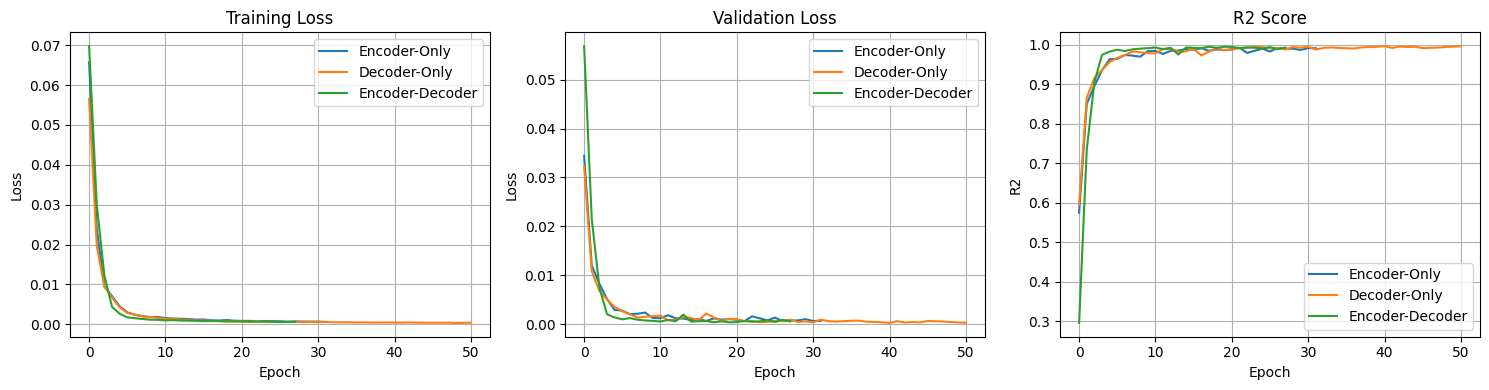

Models saved successfully in models/

Model Performance Metrics:
             Model  MSE (A)  MSE (ω)  MAE (A)  MAE (ω)      R2
0     Encoder-Only   0.0610   0.0580   0.1558   0.2020  0.9928
1     Decoder-Only   0.0417   0.0099   0.1260   0.0777  0.9969
2  Encoder-Decoder   0.0586   0.0164   0.1477   0.0880  0.9954

Relative Improvement vs Encoder-Only:
             Model  MSE (A) Improvement (%)  MSE (ω) Improvement (%)  \
0     Decoder-Only                    31.64                    82.93   
1  Encoder-Decoder                     3.93                    71.72   

   MAE (A) Improvement (%)  MAE (ω) Improvement (%)  R2 Improvement (%)  
0                    19.13                    61.53                0.41  
1                     5.20                    56.44                0.26  


In [ ]:
seq_len = 100
N = 10000

# Train and compare all models
encoder_model, decoder_model, encoder_decoder_model, metrics_df, improvement_df = compare_models(seq_len, N)

# Display the results
print("\nModel Performance Metrics:")
print(metrics_df)
print("\nRelative Improvement vs Encoder-Only:")
print(improvement_df)

In [ ]:
metrics_df

Model  MSE (A)  MSE (ω)  MAE (A)  MAE (ω)      R2
0     Encoder-Only   0.0610   0.0580   0.1558   0.2020  0.9928
1     Decoder-Only   0.0417   0.0099   0.1260   0.0777  0.9969
2  Encoder-Decoder   0.0586   0.0164   0.1477   0.0880  0.9954

In [ ]:
improvement_df

Model  MSE (A) Improvement (%)  MSE (ω) Improvement (%)  \
0     Decoder-Only                    31.64                    82.93   
1  Encoder-Decoder                     3.93                    71.72   

   MAE (A) Improvement (%)  MAE (ω) Improvement (%)  R2 Improvement (%)  
0                    19.13                    61.53                0.41  
1                     5.20                    56.44                0.26

# Let's fix A=1 and find out in which ranges our models are able to predict (N=5000)

In [ ]:
def load_models(path='models/'):
    """
    Load both encoder and decoder models
    """
    import os

    # Load encoder model
    encoder_checkpoint = torch.load(os.path.join(path, 'encoder_model.pth'))
    encoder_params = encoder_checkpoint['architecture_params']
    encoder_model = EncoderOnlyTransformer(**encoder_params)
    encoder_model.load_state_dict(encoder_checkpoint['model_state_dict'])

    # Load decoder model
    decoder_checkpoint = torch.load(os.path.join(path, 'decoder_model.pth'))
    decoder_params = decoder_checkpoint['architecture_params']
    decoder_model = DecoderOnlyTransformer(**decoder_params)
    decoder_model.load_state_dict(decoder_checkpoint['model_state_dict'])

    # Load encoder_decoder model
    encoder_decoder_checkpoint = torch.load(os.path.join(path, 'encoder_decoder_model.pth'))
    encoder_decoder_params = encoder_decoder_checkpoint['architecture_params']
    encoder_decoder = DecoderOnlyTransformer(**encoder_decoder_params)
    encoder_decoder_model.load_state_dict(encoder_decoder_checkpoint['model_state_dict'])

    print("Models loaded successfully")
    return encoder_model, decoder_model, encoder_decoder_model

In [ ]:
def generate_fixed_amplitude_data(seq_len, N=5000, A=1.0, omega_range=(0.1, 10)):
    """
    Generate sine wave data with fixed amplitude and specified frequency range
    """
    t = torch.linspace(0, 2 * torch.pi, seq_len)
    A_values = torch.full((N,), A)
    omega_values = torch.empty(N).uniform_(*omega_range)
    sine_waves = A_values.unsqueeze(1) * torch.sin(omega_values.unsqueeze(1) * t)
    labels = torch.stack([A_values, omega_values], dim=1)  # Both amplitude and frequency
    return sine_waves, labels

def apply_log_fourier(sine_waves):
    """
    Apply Fourier transform and take the logarithm of the magnitude
    """
    fft_values = torch.fft.fft(sine_waves, dim=1)
    magnitude = torch.abs(fft_values)
    log_magnitude = torch.log(magnitude + 1e-9)  # Add small value to avoid log(0)
    return log_magnitude

def prepare_data(sine_waves_fourier, labels):
    """
    Prepare DataLoader and scalers for input and labels
    """
    # Scale inputs
    input_scaler = MinMaxScaler()
    X_scaled = input_scaler.fit_transform(sine_waves_fourier.numpy())

    # Scale labels
    label_scaler = MinMaxScaler()
    y_scaled = label_scaler.fit_transform(labels.numpy())

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(torch.FloatTensor(X_scaled), torch.FloatTensor(y_scaled))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, (input_scaler, label_scaler)

def evaluate_model(model, val_loader, label_scaler):
    """
    Evaluate the model on the validation set
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            true_values.append(y_batch.numpy())

    predictions = np.vstack(predictions)
    true_values = np.vstack(true_values)

    # Inverse transform the scaled predictions and true values
    predictions = label_scaler.inverse_transform(predictions)
    true_values = label_scaler.inverse_transform(true_values)

    # Calculate metrics
    mse = np.mean((predictions - true_values) ** 2, axis=0)
    mae = np.mean(np.abs(predictions - true_values), axis=0)
    r2 = 1 - (np.sum((true_values - predictions) ** 2) / np.sum((true_values - true_values.mean()) ** 2))

    return mse, mae, r2, predictions, true_values

In [ ]:
# Main logic for model evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_len = 100
N = 5000
A = 1.0

frequency_ranges = [
    (0.01, 0.1),    # Very low frequencies
    (0.1, 1.0),     # Low frequencies
    (0.1, 10),      # Standard range
    (1.0, 10.0),    # Medium frequencies
    (10.0, 50.0),   # High frequencies
    (50.0, 100.0),  # Very high frequencies
    (100.0, 1000.0) # Ultra high frequencies
]

# Loading models
encoder_model, decoder_model, encoder_decoder_model = load_models()

# Evaluating models on each frequency range
results = []

for model_name, model in [('Encoder', encoder_model), ('Decoder', decoder_model), ('Encoder-Decoder', encoder_decoder_model)]:
    for omega_range in frequency_ranges:
        print(f"\nEvaluating {model_name} on frequency range: {omega_range}")

        # Generating data with fixed amplitude
        sine_waves, labels = generate_fixed_amplitude_data(seq_len, N, A, omega_range)

        # Applying Fourier transformation
        sine_waves_fourier = apply_log_fourier(sine_waves)

        # Preparing DataLoader
        train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(sine_waves_fourier, labels)

        # Evaluating the model
        mse, mae, r2, predictions, true_values = evaluate_model(model, val_loader, label_scaler)

        # Saving results
        results.append({
            "Model": model_name,
            "Frequency Range": omega_range,
            "MSE Frequency": mse[1],
            "MAE Frequency": mae[1],
            "R2 Score": r2
        })

# Displaying results in a table
results_df = pd.DataFrame(results)
print(results_df)

# Saving results to CSV
results_df.to_csv('model_evaluation_results.csv', index=False)


<ipython-input-55-6aabef671e05>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_checkpoint = torch.load(os.path.join(path, 'encoder_model.pth'))
<ipython-input-55-6

Models loaded successfully

Evaluating Encoder on frequency range: (0.01, 0.1)

Evaluating Encoder on frequency range: (0.1, 1.0)

Evaluating Encoder on frequency range: (0.1, 10)

Evaluating Encoder on frequency range: (1.0, 10.0)

Evaluating Encoder on frequency range: (10.0, 50.0)

Evaluating Encoder on frequency range: (50.0, 100.0)

Evaluating Encoder on frequency range: (100.0, 1000.0)

Evaluating Decoder on frequency range: (0.01, 0.1)

Evaluating Decoder on frequency range: (0.1, 1.0)

Evaluating Decoder on frequency range: (0.1, 10)

Evaluating Decoder on frequency range: (1.0, 10.0)

Evaluating Decoder on frequency range: (10.0, 50.0)

Evaluating Decoder on frequency range: (50.0, 100.0)

Evaluating Decoder on frequency range: (100.0, 1000.0)

Evaluating Encoder-Decoder on frequency range: (0.01, 0.1)

Evaluating Encoder-Decoder on frequency range: (0.1, 1.0)

Evaluating Encoder-Decoder on frequency range: (0.1, 10)

Evaluating Encoder-Decoder on frequency range: (1.0, 10.0)


In [ ]:
results_df

Model  Frequency Range  MSE Frequency  MAE Frequency   R2 Score
0           Encoder      (0.01, 0.1)       0.000631       0.021592  -2.110562
1           Encoder       (0.1, 1.0)       0.069023       0.195465 -19.558853
2           Encoder        (0.1, 10)       1.553503       1.007744   0.811423
3           Encoder      (1.0, 10.0)       0.863925       0.772706   0.862912
4           Encoder     (10.0, 50.0)     212.463669      11.947613   0.614542
5           Encoder    (50.0, 100.0)     272.211060      12.958292   0.907378
6           Encoder  (100.0, 1000.0)   87440.945312     246.654404   0.595273
7           Decoder      (0.01, 0.1)       0.000946       0.026515  -0.624858
8           Decoder       (0.1, 1.0)       0.250356       0.414728 -10.614365
9           Decoder        (0.1, 10)       1.815034       1.087288   0.823230
10          Decoder      (1.0, 10.0)       1.445779       0.936289   0.846817
11          Decoder     (10.0, 50.0)     252.318756      13.109768   0.549494
12          Decoder    (50.0, 100.0)     291.688995      14.811506   0.899772
13          Decoder  (100.0, 1000.0)  116972.679688     279.757935   0.465887
14  Encoder-Decoder      (0.01, 0.1)       0.000709       0.023228  -0.476813
15  Encoder-Decoder       (0.1, 1.0)       0.140780       0.291002 -10.262549
16  Encoder-Decoder        (0.1, 10)       1.665024       1.038595   0.812812
17  Encoder-Decoder      (1.0, 10.0)       1.308577       0.914377   0.856884
18  Encoder-Decoder     (10.0, 50.0)     252.153687      13.697452   0.553136
19  Encoder-Decoder    (50.0, 100.0)     243.030319      12.868630   0.918334
20  Encoder-Decoder  (100.0, 1000.0)   90195.156250     253.202927   0.584181

## Results with amplitude in range A=(0.1, 10)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_len = 100
N = 5000
A_range = (0.1, 10)

frequency_ranges = [
    (0.01, 0.1),    # Very low frequencies
    (0.1, 1.0),     # Low frequencies
    (0.1, 10),      # Standard range
    (1.0, 10.0),    # Medium frequencies
    (10.0, 50.0),   # High frequencies
    (50.0, 100.0),  # Very high frequencies
    (100.0, 1000.0) # Ultra high frequencies
]

# Loading models
encoder_model, decoder_model, encoder_decoder_model = load_models()

# Evaluating models on each frequency range
results = []

for model_name, model in [('Encoder', encoder_model), ('Decoder', decoder_model), ('Encoder-Decoder', encoder_decoder_model)]:
    for omega_range in frequency_ranges:
        print(f"\nEvaluating {model_name} on frequency range: {omega_range}")

        # Generating data with fixed amplitude
        sine_waves, labels = generate_data(seq_len, N, A_range, omega_range)

        # Applying Fourier transformation
        sine_waves_fourier = apply_log_fourier(sine_waves)

        # Preparing DataLoader
        train_loader, val_loader, (input_scaler, label_scaler) = prepare_data(sine_waves_fourier, labels)

        # Evaluating the model
        mse, mae, r2, predictions, true_values = evaluate_model(model, val_loader, label_scaler)

        # Saving results
        results.append({
            "Model": model_name,
            "Frequency Range": omega_range,
            "MSE Frequency": mse[1],
            "MAE Frequency": mae[1],
            "R2 Score": r2
        })

# Displaying results in a table
results_df = pd.DataFrame(results)
print(results_df)

# Saving results to CSV
results_df.to_csv('model_evaluation_results.csv', index=False)


<ipython-input-55-6aabef671e05>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_checkpoint = torch.load(os.path.join(path, 'encoder_model.pth'))
<ipython-input-55-6

Models loaded successfully

Evaluating Encoder on frequency range: (0.01, 0.1)

Evaluating Encoder on frequency range: (0.1, 1.0)

Evaluating Encoder on frequency range: (0.1, 10)

Evaluating Encoder on frequency range: (1.0, 10.0)

Evaluating Encoder on frequency range: (10.0, 50.0)

Evaluating Encoder on frequency range: (50.0, 100.0)

Evaluating Encoder on frequency range: (100.0, 1000.0)

Evaluating Decoder on frequency range: (0.01, 0.1)

Evaluating Decoder on frequency range: (0.1, 1.0)

Evaluating Decoder on frequency range: (0.1, 10)

Evaluating Decoder on frequency range: (1.0, 10.0)

Evaluating Decoder on frequency range: (10.0, 50.0)

Evaluating Decoder on frequency range: (50.0, 100.0)

Evaluating Decoder on frequency range: (100.0, 1000.0)

Evaluating Encoder-Decoder on frequency range: (0.01, 0.1)

Evaluating Encoder-Decoder on frequency range: (0.1, 1.0)

Evaluating Encoder-Decoder on frequency range: (0.1, 10)

Evaluating Encoder-Decoder on frequency range: (1.0, 10.0)


In [ ]:
results_df

Model  Frequency Range  MSE Frequency  MAE Frequency  R2 Score
0           Encoder      (0.01, 0.1)       0.000693       0.022745 -0.483278
1           Encoder       (0.1, 1.0)       0.067137       0.211147 -2.791920
2           Encoder        (0.1, 10)       1.200093       0.889999 -0.022545
3           Encoder      (1.0, 10.0)       0.974267       0.819214 -0.320020
4           Encoder     (10.0, 50.0)     196.224335      11.594696  0.512040
5           Encoder    (50.0, 100.0)     238.967804      11.870941  0.908007
6           Encoder  (100.0, 1000.0)   91173.265625     253.530365  0.578492
7           Decoder      (0.01, 0.1)       0.001307       0.029829  0.522197
8           Decoder       (0.1, 1.0)       0.162788       0.316422 -0.151325
9           Decoder        (0.1, 10)       3.428635       1.474503  0.249401
10          Decoder      (1.0, 10.0)       6.116010       2.033845 -0.021837
11          Decoder     (10.0, 50.0)     235.031540      12.999815  0.468524
12          Decoder    (50.0, 100.0)     325.517426      15.554658  0.878742
13          Decoder  (100.0, 1000.0)  120296.179688     284.150818  0.456438
14  Encoder-Decoder      (0.01, 0.1)       0.000986       0.026405  0.547293
15  Encoder-Decoder       (0.1, 1.0)       0.114648       0.267011 -1.194358
16  Encoder-Decoder        (0.1, 10)       2.092221       1.163417  0.200367
17  Encoder-Decoder      (1.0, 10.0)       1.083877       0.834870  0.508552
18  Encoder-Decoder     (10.0, 50.0)     196.505157      11.961046  0.522631
19  Encoder-Decoder    (50.0, 100.0)     246.858856      13.116399  0.903227
20  Encoder-Decoder  (100.0, 1000.0)   89494.609375     250.810242  0.591695